# What Makes A Good Speech?

A speech is a rare opportunity to influence an audience.  And while being able to convey your message in the most effective manner is hardly a science, I would like to do some research into how to communicate more effectively.  This work that follows is my investigating what features of a speech have a measurable positive or negative impact on how well it is liked by an audience.    

To investiate which features positively or negatively impact a speech, I used Natural Language Processing (NLP), as well as other available and/or engineered features (ex. the number of laughs that a talk received, or the words spoken per minute).  For a full list of the features used, please see the data dictionary below.

The data was scrapped from the TED website. (Special thanks to Miguel Corral Jr. for scraping these data: [link to scraping github](https://github.com/corralm/ted-scraper)

We have two datasets which we will merge into one.
The first dataset (which was scrapped on Apr. 30th, 2020) has the transcripts from each speech, as well as other data.
The second data set (which was scrapped on Oct. 12th, 2022) has updated views and likes information.  

[First Dataset URL](https://www.kaggle.com/datasets/miguelcorraljr/ted-ultimate-dataset/data)

[Second Dataset URL](https://www.kaggle.com/datasets/miguelcorraljr/ted-talks-2022)

# Data Dictionary:

I will first list all the available columns in both datasets.  I will then list the data that I retained for analysis.

### Unedited Original Dataset Data Dictionaries:

Dataset #1 (with the transcripts):
| Column Name     | Rows | Datatype |
|-----------------|------|----------|
| talk_id         | 4005 | int64    |
| title           | 4005 | object   |
| speaker_1       | 4005 | object   |
| all_speakers    | 4001 | object   |
| occupations     | 3483 | object   |
| about_speakers  | 3502 | object   |
| views           | 4005 | int64    |
| recorded_date   | 4004 | object   |
| published_date  | 4005 | object   |
| event           | 4005 | object   |
| native_lang     | 4005 | object   |
| available_lang  | 4005 | object   |
| comments        | 3350 | float64  |
| duration        | 4005 | int64    |
| topics          | 4005 | object   |
| related_talks   | 4005 | object   |
| url             | 4005 | object   |
| description     | 4005 | object   |
| transcript      | 4005 | object   |


Dataset #2 (as it was scraped more recently, this has with updated likes and views information which we will use):
| Column Name     | Rows | Datatype |
|-----------------|------|----------|
| talk_id         | 5701 | int64    |
| title           | 5701 | object   |
| speaker         | 5700 | object   |
| recorded_date   | 5699 | object   |
| published_date  | 5701 | object   |
| event           | 5700 | object   |
| duration        | 5701 | int64    |
| views           | 5701 | int64    |
| likes           | 5701 | int64    |



### Analysis Dataset Dictionaries:

This is the data I used in the analysis, after merging the two datasets, removing duplicate columns, and removing nulls.


| Column Name      | Rows | Original Datatype | Updated Datatype / Decision             |
|------------------|------|----------|--------------------------------------------------|
| all_speakers     | 3331 | object   | DROPPED / multiple_speakers variable created     |
| occupations      | 3331 | object   | Dummy (via MultiLabelBinarizer)                  |
| about_speakers   | 3331 | object   | DROPPED                                          |
| native_lang      | 3331 | object   | DROPPED                                          |
| available_lang   | 3331 | object   | DROPPED                                          |
| comments         | 3331 | float64  | Ready for analysis                               |
| topics           | 3331 | object   | Dummy (via MultiLabelBinarizer), and CountVectorized in Section #7                  |
| related_talks    | 3331 | object   | DROPPED                                          |
| url              | 3331 | object   | DROPPED                                          |
| description      | 3331 | object   | Possible Future CountVectorization               |
| transcript       | 3331 | object   | CountVectorize                                   |
| title            | 3331 | object   | Possible Future CountVectorization               |
| speaker          | 3331 | object   | DROPPED                                          |
| recorded_date    | 3331 | object   | Changed to DateTime                              |
| published_date   | 3331 | object   | Changed to DateTime                              |
| event            | 3331 | object   | DROPPED / ted_mainstage variable created         |

### Feature Engineering: Features Created from Original Data:

| Feature Created            | Notes                                                         | Datatype |
|----------------------------|---------------------------------------------------------------|----------|
| percent_likes              | likes / views                                                 | float64  |
| ted_mainstage              | mainstage ted events                                          | binary   |
| word_count                 | from the "transcript" column                                  | int64    |
| words_per_minute           | total_words_count / duration                                  | float64  |
| total_question_count       | summing the instances of "?" in the transcript                | int64    |
| questions_per_minute       | total_question_count / duration                               | float64  |
| total_laugh_count          | "Laughter" is included in the transcripts, summing occurrences| int64    |
| laugh_per_minute           | total_laugh_count / duration                                  | float64  |
| multiple_speakers          | whether there were multiple speakers or not                   | binary   |
| published month            | from published_date                                           | int64    |
| published year             | from published_date                                           | int64    |
| recorded month             | from recorded_date                                            | int64    |
| recorded year              | from recorded_date                                            | int64    |

# Table of Contents:

1. Merging the DataFrames
2. Data Cleaning
3. Initial EDA
4. Feature Engineering (incl. Vectorizing Text)
5. Baseline Model
6. Model Iteration & Determining the Features of Highest Influence
7. Various Investigative Tests
8. Conclusion

In [5]:
# importing necessary libraries
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import re
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import text 
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, BertModel
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import ast
from wordcloud import WordCloud
from wordcloud import WordCloud, get_single_color_func
import torch

# 1. Merging the DataFrames

In [2]:
# we have two csv files, one with the transcripts and one with the likes data.
# we will import them both here and merge them into one dataframe
transcript_df = pd.read_csv("s3://dmaciver-bstn-bucket/TED Dataset #1 (n-4003) with Transcripts.csv")
likes_df = pd.read_csv("s3://dmaciver-bstn-bucket/TED Dataset #2 (n=5701).csv")

In [3]:
# viewing the first 3 rows of the transcript dataframe
transcript_df.head(3)

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript
0,1,Averting the climate crisis,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523392,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,977,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre..."
1,92,The best stats you've ever seen,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501685,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac..."
2,7,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920832,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,1286,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun..."


In [4]:
# viewing the first 3 rows of the likes dataframe
likes_df.head(3)

,talk_id,title,speaker,recorded_date,published_date,event,duration,views,likes
0,1,Averting the climate crisis,Al Gore,2006-02-25,2006-06-27,TED2006,957,3681537,110000
1,7,Simplicity sells,David Pogue,2006-02-24,2006-06-27,TED2006,1266,2012797,60000
2,53,Greening the ghetto,Majora Carter,2006-02-26,2006-06-27,TED2006,1096,3006315,90000


In [5]:
print(transcript_df.shape)
print(likes_df.shape)

(4005, 19)
(5701, 9)


There are 4005 rows in the transcipts dataframe.  As this dataframe has the transcript data we wish to use, we will be limited to at least that number of samples after the merge.

We will merge the dataframes to obtain [from the larger 'likes' dataframe] the likes and (updated) views columns. 

Lets investigate how many times each dataframe contains the same primary key to merge on - this will tell us how many rows of data we will actually have to work with after the merge.  

#### Investigating how our data will look after merging:

Calculating the matches of talk_id (our primary key).

In [6]:
# the dataframe with the transcripts has 4003 rows and 3 columns.  How many rows will we have in our merged dataframe?
# to do this, lets check to make sure that the talk_id's are unique in the likes dataframe, 
# and check how many talk_id's in our smaller "likes_df" match those in our larger "transcript_df".  This whill show us, assuming all other information is there, how many rows we will have in our merged dataframe.

# extracting the unique talk_id's from both dataframes
unique_likes = set(likes_df['talk_id'].unique())
unique_transcripts = set(transcript_df['talk_id'].unique())
matching_talk_ids = unique_likes & unique_transcripts

# checking to see if the talk_id's are unique in the likes dataframe
if unique_likes == unique_transcripts:
    print("The talk_id's are unique in both dataframes")
    print("There are a total of:", len(matching_talk_ids), "matching unique talk_id's in the likes dataframe.  This is how many rows we will have in our merged dataframe.")
else:
    print("The talk_id's are not unique in both dataframes")
    print("There are a total of:", len(matching_talk_ids), "matching unique talk_id's in the likes dataframe.  This is how many rows we will have in our merged dataframe.")

    # finding out which 'talk_id's are different between the two dataframes
    missing_in_likes = unique_transcripts - unique_likes
    missing_in_transcripts = unique_likes - unique_transcripts

    print("There are a total of: ", len(missing_in_likes), "Missing in likes_df:", missing_in_likes)
    print("There are a total of: ", len(missing_in_transcripts), "Missing in transcripts_df:", missing_in_transcripts)

The talk_id's are not unique in both dataframes
There are a total of: 3996 matching unique talk_id's in the likes dataframe.  This is how many rows we will have in our merged dataframe.
There are a total of:  9 Missing in likes_df: {323, 45412, 2405, 2127, 3632, 2577, 2453, 2102, 347}
There are a total of:  1705 Missing in transcripts_df: {40965, 98324, 24, 8225, 57377, 57378, 81960, 81961, 81962, 81963, 90154, 90162, 81988, 98381, 98383, 81999, 82000, 82001, 82002, 82003, 82004, 65622, 82005, 82006, 73824, 73825, 82027, 57461, 41093, 82056, 82057, 138, 82058, 169, 90282, 49324, 82092, 82094, 82095, 82093, 90287, 90288, 73908, 186, 90330, 73953, 73954, 8424, 8425, 8426, 8427, 8428, 8429, 49391, 49392, 49394, 49395, 49399, 98559, 82179, 265, 74002, 74003, 74006, 98590, 98591, 65825, 290, 90404, 90405, 49450, 82218, 24874, 24876, 65856, 74051, 65876, 65877, 65878, 65879, 90453, 65881, 98662, 82289, 41330, 82290, 65915, 82299, 82300, 82301, 82302, 16778, 16779, 8590, 82318, 8592, 98706, 9

Since there are 3996 matching talk ID's this is how many talks we have to analyze (prior to data cleaning and pre-processing).

#### Merging the dataframes

In [7]:
# I will add a suffix of "_from_likes_df" to this more updated dataset, so that I know which columns are from which dataset after merging them.
# Select the columns you want to rename
columns_to_modify = ['duration', 'event', 'recorded_date', 'views', 'title', 'published_date']

# Create a dictionary where the keys are the old column names and the values are the new column names
renamed_columns = {col: col + '_from_likes_df' for col in columns_to_modify}

# Rename the columns in the DataFrame
likes_df.rename(columns=renamed_columns, inplace=True)
likes_df.head(3)

,talk_id,title_from_likes_df,speaker,recorded_date_from_likes_df,published_date_from_likes_df,event_from_likes_df,duration_from_likes_df,views_from_likes_df,likes
0,1,Averting the climate crisis,Al Gore,2006-02-25,2006-06-27,TED2006,957,3681537,110000
1,7,Simplicity sells,David Pogue,2006-02-24,2006-06-27,TED2006,1266,2012797,60000
2,53,Greening the ghetto,Majora Carter,2006-02-26,2006-06-27,TED2006,1096,3006315,90000


In [8]:
# I will now merge the two dataframes together, using the talk_id as the key.
merged_df = transcript_df.merge(likes_df, on='talk_id')
merged_df.head(3)

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,...,description,transcript,title_from_likes_df,speaker,recorded_date_from_likes_df,published_date_from_likes_df,event_from_likes_df,duration_from_likes_df,views_from_likes_df,likes
0,1,Averting the climate crisis,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523392,2006-02-25,2006-06-27,TED2006,...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre...",Averting the climate crisis,Al Gore,2006-02-25,2006-06-27,TED2006,957,3681537,110000
1,92,The best stats you've ever seen,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501685,2006-02-22,2006-06-27,TED2006,...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac...",The best stats you've ever seen,Hans Rosling,2006-02-22,2006-06-27,TED2006,1176,15432904,462000
2,7,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920832,2006-02-24,2006-06-27,TED2006,...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun...",Simplicity sells,David Pogue,2006-02-24,2006-06-27,TED2006,1266,2012797,60000


#### Removing duplicate columns

In [9]:
# Lets see which columns are redundant, and which ones we can drop.
merged_df.columns

Index(['talk_id', 'title', 'speaker_1', 'all_speakers', 'occupations',
       'about_speakers', 'views', 'recorded_date', 'published_date', 'event',
       'native_lang', 'available_lang', 'comments', 'duration', 'topics',
       'related_talks', 'url', 'description', 'transcript',
       'title_from_likes_df', 'speaker', 'recorded_date_from_likes_df',
       'published_date_from_likes_df', 'event_from_likes_df',
       'duration_from_likes_df', 'views_from_likes_df', 'likes'],
      dtype='object')

In [10]:
# here we'll remove duplicate columns
merged_cleaved_df = merged_df.drop(["speaker_1", "title_from_likes_df", "views", "recorded_date_from_likes_df", "published_date_from_likes_df", "event_from_likes_df", "duration_from_likes_df"], axis=1)
merged_cleaved_df

,talk_id,title,all_speakers,occupations,about_speakers,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript,speaker,views_from_likes_df,likes
0,1,Averting the climate crisis,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,977,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre...",Al Gore,3681537,110000
1,92,The best stats you've ever seen,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac...",Hans Rosling,15432904,462000
2,7,Simplicity sells,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,1286,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun...",David Pogue,2012797,60000
3,53,Greening the ghetto,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,2006-02-26,2006-06-27,TED2006,en,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,1116,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...,Majora Carter,3006315,90000
4,66,Do schools kill creativity?,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",2006-02-25,2006-06-27,TED2006,en,"['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,1164,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...,Sir Ken Robinson,73935964,2200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3991,62678,"Crisis support for the world, one text away",{0: 'Nancy Lublin'},{0: ['health activist']},"{0: 'Nancy Lublin, cofounder and CEO of Crisis...",2020-04-22,2020-04-27,TED2020: The Prequel,en,['en'],6.0,690,"['activism', 'data', 'technology', 'mental hea...",{2362: 'How data from a crisis text line is sa...,https://www.ted.com/talks/nancy_lublin_crisis_...,What if we could help people in crisis anytime...,"""I'm 14, and I want to go home."" ""My name is B...",Nancy Lublin,1014188,30000
3992,62782,The dark history of IQ tests,{0: 'Stefan C Dombrowski'},NaN,NaN,2020-04-27,2020-04-27,TED-Ed,en,"['en', 'es', 'my', 'pt-br']",NaN,346,"['TED-Ed', 'education', 'history', 'animation'...",{35386: 'How does the Rorschach inkblot test w...,https://www.ted.com/talks/stefan_c_dombrowski_...,"In 1905, psychologists Alfred Binet and Théodo...","In 1905, psychologists Alfred Binet and Théodo...",Stefan C. Dombrowski,2111794,63000
3993,62263,"How ""policing for profit"" undermines your rights",{0: 'Dick M. Carpenter II'},{0: ['law researcher']},{0: 'Dick M. Carpenter II studies cutting edge...,2019-06-22,2020-04-2

#### Cleaning column names

In [11]:
# Here we're removing the '_y' from any column names that have it
# merged_cleaved_df.columns = [col.rstrip('_y') if col.endswith('_y') else col for col in merged_cleaved_df.columns]
merged_cleaved_df.columns = [col.rstrip('_from_likes_df') if col.endswith('_from_likes_df') else col for col in merged_cleaved_df.columns]
merged_cleaved_df

,talk_id,title,all_speakers,occupations,about_speakers,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript,speaker,view,likes
0,1,Averting the climate crisis,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,977,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre...",Al Gore,3681537,110000
1,92,The best stats you've ever seen,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac...",Hans Rosling,15432904,462000
2,7,Simplicity sells,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,1286,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun...",David Pogue,2012797,60000
3,53,Greening the ghetto,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,2006-02-26,2006-06-27,TED2006,en,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,1116,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...,Majora Carter,3006315,90000
4,66,Do schools kill creativity?,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",2006-02-25,2006-06-27,TED2006,en,"['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,1164,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...,Sir Ken Robinson,73935964,2200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3991,62678,"Crisis support for the world, one text away",{0: 'Nancy Lublin'},{0: ['health activist']},"{0: 'Nancy Lublin, cofounder and CEO of Crisis...",2020-04-22,2020-04-27,TED2020: The Prequel,en,['en'],6.0,690,"['activism', 'data', 'technology', 'mental hea...",{2362: 'How data from a crisis text line is sa...,https://www.ted.com/talks/nancy_lublin_crisis_...,What if we could help people in crisis anytime...,"""I'm 14, and I want to go home."" ""My name is B...",Nancy Lublin,1014188,30000
3992,62782,The dark history of IQ tests,{0: 'Stefan C Dombrowski'},NaN,NaN,2020-04-27,2020-04-27,TED-Ed,en,"['en', 'es', 'my', 'pt-br']",NaN,346,"['TED-Ed', 'education', 'history', 'animation'...",{35386: 'How does the Rorschach inkblot test w...,https://www.ted.com/talks/stefan_c_dombrowski_...,"In 1905, psychologists Alfred Binet and Théodo...","In 1905, psychologists Alfred Binet and Théodo...",Stefan C. Dombrowski,2111794,63000
3993,62263,"How ""policing for profit"" undermines your rights",{0: 'Dick M. Carpenter II'},{0: ['law researcher']},{0: 'Dick M. Carpenter II studies cutting edge...,2019-06-22,2020-04-28,TEDxMileHigh,

In [12]:
# There are no more duplicate columns
print(merged_cleaved_df.columns)
print(merged_cleaved_df.shape)

Index(['talk_id', 'title', 'all_speakers', 'occupations', 'about_speakers',
       'recorded_date', 'published_date', 'event', 'native_lang',
       'available_lang', 'comments', 'duration', 'topics', 'related_talks',
       'url', 'description', 'transcript', 'speaker', 'view', 'likes'],
      dtype='object')
(3996, 20)


There are no more duplicate columns.  

The dataset has 3996 rows and 20 columns in the merged_df dataframe.

# 2. Data Cleaning

- dealing with nulls
- addressing datatypes


### Dealing with nulls

In [13]:
# how many nulls do we have now?
pd.options.display.max_rows = 25
merged_cleaved_df.isnull().sum()

talk_id             0
title               0
all_speakers        4
occupations       522
about_speakers    503
recorded_date       1
published_date      0
event               0
native_lang         0
available_lang      0
comments          654
duration            0
topics              0
related_talks       0
url                 0
description         0
transcript          0
speaker             0
view                0
likes               0
dtype: int64

For the moment, while removing nulls will result in ((3996-3331) / 3996 = 0.1664) 16.4% of the data being thrown out, scraping additional data from the TED website is beyond the scope of this project, so we will continue without this data. 

In [14]:
# Lets see what happens to the 3996 rows when we drop the null values
merged_cleaved_df.dropna(inplace=True)

In [15]:
merged_cleaved_df.shape

(3330, 20)

After removing nulls, our dataframe has 3330 rows, and 20 columns.

### Addressing Datatypes

We're going to, one by one, determine what to do with each of the "object" columns. 
Options include:
- Change into numerical values
- Clean for CountVectorization
- Clean for Dummy / Multi-Label-Binarizing
- Drop

#### Columns to address, and what was done to them:
| Variable        | # of Rows | Previous Datatype | Changed Datatype / Decision                        |
|-----------------|-----------|-------------------|----------------------------------------------------|
| all_speakers    | 3331      | object            | DROPPED / multiple_speakers variable created       |
| occupations     | 3331      | object            | Dummy (via MultiLabelBinarizer) in the next section|
| about_speakers  | 3331      | object            | DROPPING                                           |
| native_lang     | 3331      | object            | DROPPED                                            |
| available_lang  | 3331      | object            | DROPPED                                            |
| comments        | 3331      | float64           | Ready for analysis                                 |
| topics          | 3331      | object            | Create (via MultiLabel Binarizer)                  |
| related_talks   | 3331      | object            | DROPPED                                            |
| url             | 3331      | object            | DROPPED                                            |
| description     | 3331      | object            | DROPPED                                            |
| transcript      | 3331      | object            | CountVectorize                                     |
| title           | 3331      | object            | CountVectorization in Section 7                    |
| speaker         | 3331      | object            | DROPPED                                            |
| recorded_date   | 3331      | object            | Changed to DateTime                                |
| published_date  | 3331      | object            | Changed to DateTime                                |
| event           | 3331      | object            | ted_mainstage variable created                     |


We'll start with "all_speakers" (for this section of the notebook, the column we are addressing in the section below will be made a headline, as is "all_speakers" below)

| Variable        | # of Rows | Previous Datatype | Changed Datatype / Decision                        |
|-----------------|-----------|-------------------|----------------------------------------------------|
| all_speakers    | 3331      | object            | DROPPED / multiple_speakers variable created       |

In [16]:
merged_cleaved_df["all_speakers"].value_counts()

all_speakers
{0: 'Hans Rosling'}            9
{0: 'Greg Gage'}               9
{0: 'Juan Enriquez'}           9
{0: 'Marco Tempest'}           7
{0: ' Rives'}                  6
                              ..
{0: 'Ryan Merkley'}            1
{0: 'Pankaj Ghemawat'}         1
{0: 'David Pizarro'}           1
{0: 'Lemn Sissay'}             1
{0: 'Dick M. Carpenter II'}    1
Name: count, Length: 2851, dtype: int64

In [17]:
# Let's find out how many talks have multiple speakers
# Assuming all_speakers is a list of dictionaries
all_speakers = merged_cleaved_df["all_speakers"]

# Initialize a counter
count = 0

# Iterate through each dictionary in the list
for speaker_dict in all_speakers:
    # Check if the key "1" exists in the dictionary
    if "1" in speaker_dict:
        count += 1

# Output the result
print(f"Number of dictionaries with a key '1': {count}")

Number of dictionaries with a key '1': 103


There are 103 talks with multiple speakers in them.  

As much of the data in 'all_speakers' is redundant as it repeats the value of the main speaker, we will drop this column.

We will, however, create a dummy column "multiple_speakers" to see if the presence of multiple speakers impacts the outcome of the speech.  

In [18]:
# Assuming merged_cleaved_df is your existing DataFrame
all_speakers = merged_cleaved_df["all_speakers"]

# Using list comprehension to create a one-hot encoded column
merged_cleaved_df['multiple_speakers'] = [1 if "1" in speaker_dict else 0 for speaker_dict in all_speakers]

# Now, merged_cleaved_df has a new column 'multiple_speakers' with one hot encoding


In [19]:
# Dropping the "all_speakers" column, as it is not useful for our analysis
merged_cleaved_df.drop(["all_speakers"], axis=1, inplace=True)

| Variable        | # of Rows | Previous Datatype | Changed Datatype / Decision                        |
|-----------------|-----------|-------------------|----------------------------------------------------|
| occupations     | 3331      | object            | Dummy (via MultiLabelBinarizer) in the next section|

In [20]:
merged_cleaved_df["occupations"].value_counts()

occupations
{0: ['writer']}                                   52
{0: ['journalist']}                               43
{0: ['entrepreneur']}                             42
{0: ['artist']}                                   40
{0: ['designer']}                                 37
                                                  ..
{0: ['bow designer']}                              1
{0: ['explorer and filmmaker']}                    1
{0: ['human-computer interaction researcher']}     1
{0: ['composer', 'inventor'], 1: ['musician']}     1
{0: ['law researcher']}                            1
Name: count, Length: 1982, dtype: int64

Let's clean these by removing them from their current dictionary format.

In [21]:
# Here we're going to split the "occupations" column into a list of occupations

def transform_occupation(occupation_str):
    # Extracting the part after "{0: " and before the first occurrence of "],"
    match = re.search(r"\{0: \[([^\]]*)\]", occupation_str)
    if match:
        occupations = match.group(1)
        # Remove quotes and split by comma to get individual occupations
        occupations = occupations.replace("'", "").split(", ")
        # Replace spaces within occupations with underscores
        occupations = [occupation.replace(" ", "_") for occupation in occupations]
        # Join the occupations back with a space
        return " ".join(occupations)
    else:
        # Return an empty string or some default value if the pattern is not found
        return ""

# Apply the function to the 'occupations' column
merged_cleaved_df['transformed_occupations'] = merged_cleaved_df['occupations'].apply(transform_occupation)
merged_cleaved_df['transformed_occupations'].value_counts()


transformed_occupations
writer                             54
journalist                         44
entrepreneur                       43
artist                             41
designer                           37
                                   ..
former_prime_minister_of_greece     1
graphic_artist director             1
dolphin_researcher                  1
undercover_journalist               1
law_researcher                      1
Name: count, Length: 1924, dtype: int64

### Transforming Occupations Into Dummies?

The following code is hashed-out as we are trying to limit variables in our modelling (as there are only 3330 rows in the dataset, creating too many variables will risk creating more columns then there are variables).  We can consider including it at a later time.

In [22]:
# # Convert 'transformed_occupations' into dummy variables
# occupation_dummies = pd.get_dummies(merged_cleaved_df['transformed_occupations'], drop_first=True)

# # Define X and y
# X = occupation_dummies
# y = merged_cleaved_df['percent_likes']

# # Splitting the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Adding a constant to the model for the training data
# X_train = sm.add_constant(X_train)

# # Linear Regression on Training Data
# model = sm.OLS(y_train, X_train)
# result = model.fit()

# # Optionally: Evaluate model performance on test data
# X_test = sm.add_constant(X_test)
# predictions = result.predict(X_test)


# # Getting the coefficients from the trained model
# coefficients = result.params

# # Dropping the constant for the purpose of this analysis
# coefficients = coefficients.drop('const', errors='ignore')

# # Sorting the coefficients
# sorted_coefficients = coefficients.sort_values()

# # Selecting the top 10 positive and negative coefficients
# top_10_positive = sorted_coefficients.tail(10)
# top_10_negative = sorted_coefficients.head(10)

# # Plotting
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# # Plot for top 10 positive coefficients
# top_10_positive.plot(kind='barh', ax=axes[0], color='green')
# axes[0].set_title('Top 10 Positive Coefficients')
# axes[0].set_xlabel('Coefficient Value')
# axes[0].set_ylabel('Occupations')

# # Plot for top


In [23]:
# again, the above code is hashed out as it creates too many columns. 
# occupation_dummies

| Variable        | # of Rows | Previous Datatype | Changed Datatype / Decision                        |
|-----------------|-----------|-------------------|----------------------------------------------------|
| about_speakers  | 3331      | object            | DROPPING                                           |

In [24]:
merged_cleaved_df['about_speakers']

0       {0: 'Nobel Laureate Al Gore focused the world’...
1       {0: 'In Hans Rosling’s hands, data sings. Glob...
2       {0: 'David Pogue is the personal technology co...
3       {0: 'Majora Carter redefined the field of envi...
4       {0: "Creativity expert Sir Ken Robinson challe...
                              ...                        
3985    {0: 'A political strategist focused on creatin...
3986    {0: 'With a style that crackles with wry wit, ...
3990    {0: "TED Prize winner Larry Brilliant has spen...
3991    {0: 'Nancy Lublin, cofounder and CEO of Crisis...
3993    {0: 'Dick M. Carpenter II studies cutting edge...
Name: about_speakers, Length: 3330, dtype: object

For the scope of this analyses, we will drop this column.  

In [25]:
# Dropping the "all_speakers" column, as it is not useful for our analysis
merged_cleaved_df.drop(["about_speakers"], axis=1, inplace=True)

| Variable        | # of Rows | Previous Datatype | Changed Datatype / Decision                        |
|-----------------|-----------|-------------------|----------------------------------------------------|                     
| native_lang     | 3331      | object            | DROPPED                                            |

In [26]:
merged_cleaved_df["native_lang"].value_counts()

native_lang
en       3298
es         15
fr          7
hi          2
de          1
pt          1
ko          1
zh-cn       1
ar          1
pt-br       1
ja          1
it          1
Name: count, dtype: int64

As the vast majority of this column represents English ("en") as being the native language, we will drop this column.

In [27]:
merged_cleaved_df = merged_cleaved_df.drop("native_lang", axis=1)

| Variable        | # of Rows | Previous Datatype | Changed Datatype / Decision                        |
|-----------------|-----------|-------------------|----------------------------------------------------|
| available_lang  | 3331      | object            | DROPPED                                            |

In [28]:
merged_cleaved_df["available_lang"].value_counts()

available_lang
['en']                                                                                                                                                                                                    14
['ar', 'bg', 'de', 'el', 'en', 'es', 'fr', 'he', 'it', 'ja', 'ko', 'nl', 'pl', 'pt-br', 'ro', 'ru', 'tr', 'vi', 'zh-cn', 'zh-tw']                                                                          6
['ar', 'bg', 'de', 'en', 'es', 'fr', 'he', 'it', 'ja', 'ko', 'nl', 'pl', 'pt-br', 'ro', 'ru', 'tr', 'vi', 'zh-cn', 'zh-tw']                                                                                4
['ar', 'bg', 'de', 'en', 'es', 'fr', 'he', 'it', 'ja', 'ko', 'nl', 'pl', 'pt', 'pt-br', 'ro', 'ru', 'sr', 'tr', 'vi', 'zh-cn', 'zh-tw']                                                                    4
['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa', 'fr', 'he', 'hr', 'hu', 'id', 'it', 'ja', 'ko', 'nl', 'pl', 'pt', 'pt-br', 'ro', 'ru', 'sk', 'sr', 'sv', 'th', 'tr',

As we are attempting to limit features, I will drop this column.

In [29]:
# Dropping the "available_lang" column, as it is not useful for our analysis
merged_cleaved_df = merged_cleaved_df.drop("available_lang", axis=1)

| Variable        | # of Rows | Previous Datatype | Changed Datatype / Decision                        |
|-----------------|-----------|-------------------|----------------------------------------------------|
| comments        | 3331      | float64           | Ready for analysis                                 |

The comments are ready for processing as they are already numerically represented. 

| Variable        | # of Rows | Previous Datatype | Changed Datatype / Decision                        |
|-----------------|-----------|-------------------|----------------------------------------------------|
| topics          | 3331      | object            | Create Dummies (via MultiLabel Binarizer) in the next section                  |

In [30]:
merged_cleaved_df["topics"].value_counts()

topics
['art', 'creativity']                                                                                                                                                                                                        2
['TED Fellows', 'photography', 'war']                                                                                                                                                                                        2
['charter for compassion', 'compassion', 'global issues', 'religion']                                                                                                                                                        2
['design', 'entertainment', 'live music', 'music', 'technology']                                                                                                                                                             2
['architecture', 'cities', 'design', 'infrastructure']                                               

We will turn these into dummy variables via a MultiLabelBinarizer in the next section. 

| Variable        | # of Rows | Previous Datatype | Changed Datatype / Decision                        |
|-----------------|-----------|-------------------|----------------------------------------------------|
| related_talks   | 3331      | object            | **DROPPED**                                        |

In [31]:
merged_cleaved_df["related_talks"].value_counts()

related_talks
{243: 'New thinking on the climate crisis', 547: 'The business logic of sustainability', 2093: 'The state of the climate — and what we might do about it', 54715: 'How we can turn the tide on climate', 29968: 'The most important thing you can do to fight climate change: talk about it', 2339: "Climate change is happening. Here's how we adapt"}                  1
{2387: 'The untapped genius that could change science for the better', 2504: 'Good news in the fight against pancreatic cancer', 2821: 'A simple new blood test that can catch cancer early', 53671: 'How does chemotherapy work?', 2467: 'A new superweapon in the fight against cancer', 20919: 'How cancer cells communicate -- and how we can slow them down'}       1
{40727: 'How to revive your belief in democracy', 2104: 'How to upgrade democracy for the Internet era', 2060: 'Why ordinary people need to understand power', 29521: "What's needed to bring the US voting system into the 21st century", 51845: 'Why do Americans 

For the scope of this project, we will drop this column.

In [32]:
merged_cleaved_df = merged_cleaved_df.drop("related_talks", axis=1)

| Variable        | # of Rows | Previous Datatype | Changed Datatype / Decision                        |
|-----------------|-----------|-------------------|----------------------------------------------------|
| url             | 3331      | object            | DROPPED                                            |

We will drop the URL column.

In [33]:
# dropping the URL column
merged_cleaved_df.drop(["url"], axis=1, inplace=True)

| Variable        | # of Rows | Previous Datatype | Changed Datatype / Decision                        |
|-----------------|-----------|-------------------|----------------------------------------------------|
| description     | 3331      | object            | DROPPED                                            |

In [34]:
merged_cleaved_df["description"].value_counts()

description
With the same humor and humanity he exuded in "An Inconvenient Truth," Al Gore spells out 15 ways that individuals can address climate change immediately, from buying a hybrid to inventing a new, hotter brand name for global warming.                                                                                                                                                                                                                                                                               1
After decades of research and billions spent in clinical trials, we still have a problem with cancer drug delivery, says biomedical engineer Elizabeth Wayne. Chemotherapy kills cancer -- but it kills the rest of your body, too. Instead of using human design to fight cancer, why not use nature's? In this quick talk, Wayne explains how her lab is creating nanoparticle treatments that bind to immune cells, your body's first responders, to precisely target cancer cells without dama

As this column has little to do with the giving of the speech itself, we will drop this column.

In [35]:
# dropping the description column
merged_cleaved_df.drop(["description"], axis=1, inplace=True)

| Variable        | # of Rows | Previous Datatype | Changed Datatype / Decision                        |
|-----------------|-----------|-------------------|----------------------------------------------------|
| transcript      | 3331      | object            | CountVectorize                                     |

In [36]:
merged_cleaved_df["transcript"].value_counts()

transcript
Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful. I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night. And I say that sincerely, partly because (Mock sob) I need that. (Laughter) Put yourselves in my position. (Laughter) I flew on Air Force Two for eight years. (Laughter) Now I have to take off my shoes or boots to get on an airplane! (Laughter) (Applause) I'll tell you one quick story to illustrate what that's been like for me. (Laughter) It's a true story — every bit of this is true. Soon after Tipper and I left the — (Mock sob) White House — (Laughter) we were driving from our home in Nashville to a little farm we have 50 miles east of Nashville. Driving ourselves. (Laughter) I know it sounds like a little thing to you, but — (Laughter) I looked in the rear-view mirror and all of a sudden it just hit me.

This column is ready to be CountVectorized.  We will address CountVectorization in the next section. 

| Variable        | # of Rows | Previous Datatype | Changed Datatype / Decision                        |
|-----------------|-----------|-------------------|----------------------------------------------------|
| title           | 3331      | object            | CountVectorization                                 |

In [37]:
merged_cleaved_df["title"].value_counts()

title
Averting the climate crisis                             1
We can hack our immune cells to fight cancer            1
There's no such thing as not voting                     1
Why you should know how much your coworkers get paid    1
Why open a school? To close a prison                    1
                                                       ..
A TED speaker's worst nightmare                         1
Design to challenge reality                             1
Why you will fail to have a great career                1
The cockroach beatbox                                   1
How "policing for profit" undermines your rights        1
Name: count, Length: 3330, dtype: int64

I am considering CountVectorizing this column.  For now we will leave as-is.  CountVectorizing MAY be done in the next section.  

| Variable        | # of Rows | Previous Datatype | Changed Datatype / Decision                        |
|-----------------|-----------|-------------------|----------------------------------------------------|
| speaker         | 3331      | object            | DROPPED                                            |

In [38]:
merged_cleaved_df["speaker"].value_counts()

speaker
Greg Gage                  9
Juan Enriquez              9
Hans Rosling               9
Marco Tempest              7
Bill Gates                 6
                          ..
Sue Austin                 1
Boghuma Kabisen Titanji    1
Andy Puddicombe            1
Angela Patton              1
Dick M. Carpenter II       1
Name: count, Length: 2843, dtype: int64

As this column has little to do with the speech itself, and because we are trying to limit the number of features to the number of rows, I will drop this column.  

It is noteworthy that WHO a speaker is would likely impact their rating on the speech itself, as each person represents their own personal brand, and when someone "likes" a speech they are in part "liking" that person's personal brand.  But given that the number of features we have is limited to the number of rows that we have, dummying the speaker names would create too many features to justify it's influence on our question "what makes a great speech"?

In [39]:
# dropping the speaker column
merged_cleaved_df.drop(["speaker"], axis=1, inplace=True)

| Variable        | # of Rows | Previous Datatype | Changed Datatype / Decision                        |
|-----------------|-----------|-------------------|----------------------------------------------------|
| recorded_date   | 3331      | object            | Changed to DateTime                                |
| published_date  | 3331      | object            | Changed to DateTime                                |


I will change these dates into DateTime datatypes.

In [40]:
merged_cleaved_df["published_date"] = pd.to_datetime(merged_cleaved_df["published_date"])
merged_cleaved_df["recorded_date"] = pd.to_datetime(merged_cleaved_df["recorded_date"])

| Variable        | # of Rows | Previous Datatype | Changed Datatype / Decision                        |
|-----------------|-----------|-------------------|----------------------------------------------------|
| event           | 3331      | object            | ted_mainstage variable created                     |

In [41]:
merged_cleaved_df["event"].value_counts()

event
TED2017                    96
TED2018                    95
TED2019                    91
TED2014                    83
TED2009                    81
                           ..
TEDSalon NY2015             1
TEDxIndianapolis            1
TEDxChapmanU                1
TEDxGoldenGatePark 2012     1
TEDxCreativeCoast           1
Name: count, Length: 428, dtype: int64

I will create a binary "ted_mainstage" column in the next section, to differentiate between TED and TEDx (and other) events.

# 3. Feature Engineering

#### We will create the following features:
- percent_likes (likes / views)
- ted_mainstage (mainstage ted events)
- word_count (from the "transcript" column)
- words_per_minute (total_words_count / duration)
- total_question_count (summing the instances of "?" in the transcript)
- questions_per_minute (total_question_count / duration)
- total_laugh_count ("Laughter" is included in the transcripts, and we will sum these occurrences)
- laugh_per_minute (total_laugh_count / duration)
- multiple_speakers (dummy variable - wether there were multiple speakers or not - created in the previous section)



#### We will Dummying (via MultiLabelBinarizing) the following columns:
- Occupation
- Topic
- published month
- published year
- recorded month
- recorded year

#### We will CountVectorize the following columns:
- Transcript
- Title



#### Percent likes feature
- Create a "percent_likes" feature

In [42]:
# here we'll create a "percent_likes" column, which is the percentage of likes out of the total views
merged_cleaved_df['percent_likes'] = merged_cleaved_df['likes'] / merged_cleaved_df['view']

#### Ted Mainstage Feature

- Create a binanry "main_stage" feature (from "event", which ones are mainstage TED talks vs which ones are 'Tedx'-like talks)

In [43]:
# Here we'll create a 'ted_mainstage' column, which is a boolean column that is True if the talk was performed at a mainstream "TED" event, and False if it was not.
# This is a regex pattern that matches the TED events that are not TEDx or TED Global
mainstage = '^\s*TED\d{4}\s*$'

# Create a binary column based on the condition
merged_cleaved_df['ted_mainstage'] = merged_cleaved_df['event'].str.match(mainstage).astype(int)
merged_cleaved_df['ted_mainstage'].value_counts()


ted_mainstage
0    2154
1    1176
Name: count, dtype: int64

#### Word count columns

In [44]:
# Lets create another column that counts the number of words in the transcript.
# A function that counts words in a string
def count_words(text):
    # Splitting the text into words and count them
    return len(text.split())

# Apply this function to each row in the 'transcript' column and create a new column
merged_cleaved_df['word_count'] = merged_cleaved_df['transcript'].apply(count_words)


#### Words per minute

In [45]:
# words count per minute
merged_cleaved_df['words_per_minute'] = merged_cleaved_df['word_count'] / merged_cleaved_df['duration']

#### Total Question Count and Questions per Minute

In [46]:
# Define a function that counts question marks in a given string
def count_question_marks(text):
    return text.count('?')

# Apply this function to each row of the 'transcript' column and store the result in a new column
merged_cleaved_df['num_question_marks'] = merged_cleaved_df['transcript'].apply(count_question_marks)
merged_cleaved_df['questions_per_minute'] = merged_cleaved_df['num_question_marks'] / merged_cleaved_df['duration']
merged_cleaved_df.head(3)

,talk_id,title,occupations,recorded_date,published_date,event,comments,duration,topics,transcript,view,likes,multiple_speakers,transformed_occupations,percent_likes,ted_mainstage,word_count,words_per_minute,num_question_marks,questions_per_minute
0,1,Averting the climate crisis,{0: ['climate advocate']},2006-02-25,2006-06-27,TED2006,272.0,977,"['alternative energy', 'cars', 'climate change...","Thank you so much, Chris. And it's truly a gre...",3681537,110000,0,climate_advocate,0.029879,1,2153,2.203685,8,0.008188
1,92,The best stats you've ever seen,{0: ['global health expert; data visionary']},2006-02-22,2006-06-27,TED2006,628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","About 10 years ago, I took on the task to teac...",15432904,462000,0,global_health_expert;_data_visionary,0.029936,1,3174,2.667227,22,0.018487
2,7,Simplicity sells,{0: ['technology columnist']},2006-02-24,2006-06-27,TED2006,124.0,1286,"['computers', 'entertainment', 'interface desi...","(Music: ""The Sound of Silence,"" Simon & Garfun...",2012797,60000,0,technology_columnist,0.029809,1,3371,2.621306,35,0.027216


#### Total Laugh Count and Laughs per Minute

In [47]:
# Create a function that counts the number of "(Laughter)" in a string.
def count_laughter(text):
    # Splitting the text into words and count them
    return text.count("(Laughter)")

# Apply this function to each row of the 'transcript' column and store the result in a new column
merged_cleaved_df['num_laughs'] = merged_cleaved_df['transcript'].apply(count_laughter)
merged_cleaved_df['laughs_per_minute'] = merged_cleaved_df['num_laughs'] / merged_cleaved_df['duration']
merged_cleaved_df.head(3)

,talk_id,title,occupations,recorded_date,published_date,event,comments,duration,topics,transcript,...,multiple_speakers,transformed_occupations,percent_likes,ted_mainstage,word_count,words_per_minute,num_question_marks,questions_per_minute,num_laughs,laughs_per_minute
0,1,Averting the climate crisis,{0: ['climate advocate']},2006-02-25,2006-06-27,TED2006,272.0,977,"['alternative energy', 'cars', 'climate change...","Thank you so much, Chris. And it's truly a gre...",...,0,climate_advocate,0.029879,1,2153,2.203685,8,0.008188,22,0.022518
1,92,The best stats you've ever seen,{0: ['global health expert; data visionary']},2006-02-22,2006-06-27,TED2006,628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","About 10 years ago, I took on the task to teac...",...,0,global_health_expert;_data_visionary,0.029936,1,3174,2.667227,22,0.018487,9,0.007563
2,7,Simplicity sells,{0: ['technology columnist']},2006-02-24,2006-06-27,TED2006,124.0,1286,"['computers', 'entertainment', 'interface desi...","(Music: ""The Sound of Silence,"" Simon & Garfun...",...,0,technology_columnist,0.029809,1,3371,2.621306,35,0.027216,38,0.029549


#### Published and Recorded Month and Year column

- published_year
- published_month
- recorded_year
- recorded_month

In [48]:
# I am creating additional columns for the year and month of the published and recorded dates
merged_cleaved_df["published_year"] = merged_cleaved_df["published_date"].dt.year
merged_cleaved_df["published_month"] = merged_cleaved_df["published_date"].dt.month
merged_cleaved_df["recorded_year"] = merged_cleaved_df["recorded_date"].dt.year
merged_cleaved_df["recorded_month"] = merged_cleaved_df["recorded_date"].dt.month

In [49]:
# I am creating a copy of the dataframe at this point for use much further down in this notebook
for_later_use = merged_cleaved_df.copy()

### We will dummy (via MultiLabelBinarizing) the following columns
- occupation
- topic

### We will dummy the following columns
- published month
- published year
- recorded month
- recorded year


#### We will CountVectorize the following columns
- transcript
- title (count-vectorized in Section 7)


In [50]:
# MultiLabelBinarizing the 'topics' column
# Convert the string representation of lists in 'topics' column to actual lists
merged_cleaved_df['topics_list'] = merged_cleaved_df['topics'].apply(ast.literal_eval)

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Transform 'topics_list' column (now actual lists) into a binary matrix
topics_encoded = mlb.fit_transform(merged_cleaved_df['topics_list'])

# Creating a DataFrame from the transformed topics
topics_df = pd.DataFrame(topics_encoded, columns=mlb.classes_)

# topics_df now contains the binarized form of the 'topics' column, with each column representing a unique topic
topics_df.shape

(3330, 449)

Topics dummy variables account for 449 features.

In [51]:
# MultiLabelBinarizing the 'transformed_occupation' column
# Convert the string representation of lists in 'topics' column to actual lists
merged_cleaved_df['transformed_occupations_list'] = merged_cleaved_df['transformed_occupations'].apply(lambda x: x.split(' '))

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Transform 'transformed_occupations_list' column (now actual lists) into a binary matrix
occupations_encoded = mlb.fit_transform(merged_cleaved_df['transformed_occupations_list'])

# Creating a DataFrame from the transformed occupations
occupations_df = pd.DataFrame(occupations_encoded, columns=mlb.classes_)

# occupations_df now contains the binarized form of the 'transformed_occupations' column, with each column representing a unique topic
occupations_df.shape

(3330, 1701)

Occupation dummy variables account for 1701 features.

Dummying the date features that we engineered from original datetime data.

In [52]:
# List of columns for which to create dummy variables
columns_to_dummify = [
    'published_year',
    'published_month',
    'recorded_year',
    'recorded_month',
]

# Creating dummy variables
for column in columns_to_dummify:
    dummies = pd.get_dummies(merged_cleaved_df[column], prefix=column)
    merged_cleaved_df = pd.concat([merged_cleaved_df, dummies], axis=1)
    merged_cleaved_df.drop(column, axis=1, inplace=True)

In [53]:
merged_cleaved_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3330 entries, 0 to 3993
Data columns (total 87 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   talk_id                       3330 non-null   int64         
 1   title                         3330 non-null   object        
 2   occupations                   3330 non-null   object        
 3   recorded_date                 3330 non-null   datetime64[ns]
 4   published_date                3330 non-null   datetime64[ns]
 5   event                         3330 non-null   object        
 6   comments                      3330 non-null   float64       
 7   duration                      3330 non-null   int64         
 8   topics                        3330 non-null   object        
 9   transcript                    3330 non-null   object        
 10  view                          3330 non-null   int64         
 11  likes                         3330 

## Merging dummy dataframes into a single dataframe

We will merge the MultiLabelBinarized / dummy dataframes before our countvectorization process.

Let's first drop all non-numerical columns (other than the columns we will be doing our CountVectorizing on).

In [54]:
pd.options.display.max_rows = 40

In [55]:
# Dropping the non numerical columns
ready_to_merge_numerical_df = merged_cleaved_df.select_dtypes(include=['bool', 'int64', 'float64'])
ready_to_merge_numerical_df.drop(["talk_id"], axis=1, inplace=True) # Dropping the talk_id column
ready_to_merge_numerical_df.drop(["likes"], axis=1, inplace=True) # Dropping the likes column, as it is correlated to our target variable
ready_to_merge_numerical_df['transcript'] = merged_cleaved_df['transcript'] # Adding the transcript column back in
ready_to_merge_numerical_df.info()
print(ready_to_merge_numerical_df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 3330 entries, 0 to 3993
Data columns (total 76 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   comments              3330 non-null   float64
 1   duration              3330 non-null   int64  
 2   view                  3330 non-null   int64  
 3   multiple_speakers     3330 non-null   int64  
 4   percent_likes         3330 non-null   float64
 5   ted_mainstage         3330 non-null   int64  
 6   word_count            3330 non-null   int64  
 7   words_per_minute      3330 non-null   float64
 8   num_question_marks    3330 non-null   int64  
 9   questions_per_minute  3330 non-null   float64
 10  num_laughs            3330 non-null   int64  
 11  laughs_per_minute     3330 non-null   float64
 12  published_year_2006   3330 non-null   bool   
 13  published_year_2007   3330 non-null   bool   
 14  published_year_2008   3330 non-null   bool   
 15  published_year_2009   3330

We now have a dataframe to which we can merge the topics and occupations dummy variables.

In [56]:
# Lets check the shape of the topics_df and occupations_df and ready_to_merge_numerical_df
print(topics_df.shape)
print(occupations_df.shape)
print(ready_to_merge_numerical_df.shape)

(3330, 449)
(3330, 1701)
(3330, 76)


In [57]:
# As all three dataframes have the same shape, we'll reset their indexes and merge them together
# Reset the index of each DataFrame to ensure alignment
occupations_df_reset = occupations_df.reset_index(drop=True)
topics_df_reset = topics_df.reset_index(drop=True)
ready_to_merge_numerical_df_reset = ready_to_merge_numerical_df.reset_index(drop=True)

In [58]:
dummy_merged_df = pd.concat([occupations_df_reset, topics_df_reset, ready_to_merge_numerical_df_reset], axis=1)
dummy_merged_df.shape

(3330, 2226)

For countvectorizing, we have space for (3330 - 2226 = 1104) 1104 columns.  We will set the MaxFeatures at 1100. 

## Defining what a "good" speach is - creating a binary dependent variable

Let's first look at the "percent_likes" column to decide where to draw the line.

/var/folders/l2/d5ln4l29453322fq40g1dz2h0000gn/T/ipykernel_1369/1665270562.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(dummy_merged_df['percent_likes'], kde=False, palette='coolwarm', bins=30)


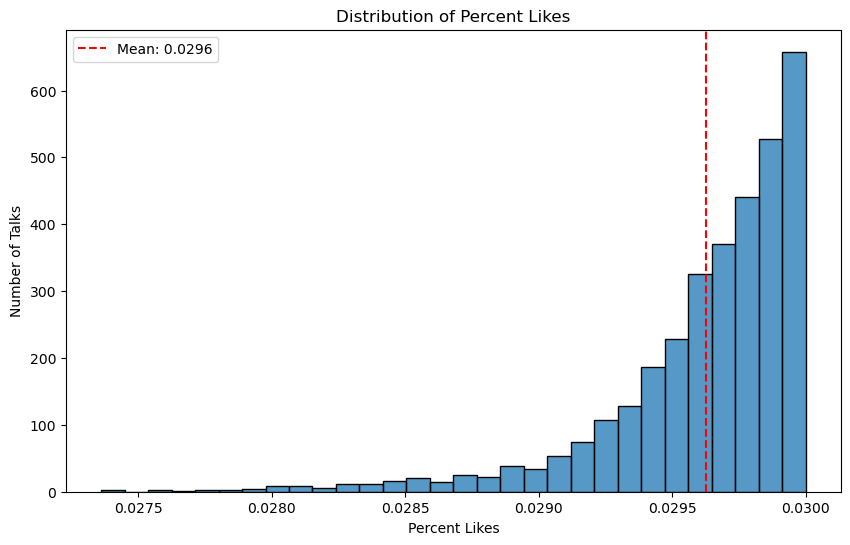

In [59]:
# Plotting the distribution
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
sns.histplot(dummy_merged_df['percent_likes'], kde=False, palette='coolwarm', bins=30)
# 'kde=False' turns off the Kernel Density Estimate plot overlay
# 'bins=30' specifies how many bins you want to divide your data into
# 'color' specifies the color of the histogram

# Calculating and plotting the mean
mean_value = dummy_merged_df['percent_likes'].mean()
plt.axvline(mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.4f}')
# This draws a vertical line at the mean value, '--' makes the line dashed, and ':.2f' formats the mean to 2 decimal places

plt.xlabel('Percent Likes')  # Label for the x-axis
plt.ylabel('Number of Talks')  # Label for the y-axis
plt.title('Distribution of Percent Likes')  # Title of the plot
plt.legend()  # Show the legend
plt.show()


I'm going to create a binary "good_speech" column.  We are indicating that speeches that received an above the mean "percent_likes" are counted as "good_speech", and those that were below the "percent_likes" mean are not.

In [60]:
# creating a new column called 'good_speech' that is 1 if the speech is in the top 50% of percent_likes, and 0 if it is in the bottom 50% of percent_likes

# Calculate the 50th percentile (median) of the 'percent_likes' column
median_percent_likes = dummy_merged_df['percent_likes'].mean()

# Create the 'good_speech' column based on the condition
dummy_merged_df['good_speech'] = (dummy_merged_df['percent_likes'] >= median_percent_likes).astype(int)

# Now, merged_cleaved_df has a new column 'good_speech' with 1s and 0s based on the condition
# Dropping the 'percent_likes' column, as it is redundant for our analysis
dummy_merged_df.drop(["percent_likes"], axis=1, inplace=True)

In [61]:
# Scaling the data

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# List of columns to scale
columns_to_scale = ['comments', 'duration', 'word_count', 'words_per_minute', 'num_question_marks', 
                    'questions_per_minute', 'num_laughs', 'laughs_per_minute']

# Scale the selected columns and replace in the dataframe
dummy_merged_df[columns_to_scale] = scaler.fit_transform(dummy_merged_df[columns_to_scale])

# 4. Basic EDA

In [62]:
merged_cleaved_df.shape

(3330, 87)

The dataframe we are now working with has 3330 rows and 87 columns.

In [63]:
# Basic Descriptive Statistics
merged_cleaved_df.describe()

,talk_id,recorded_date,published_date,comments,duration,view,likes,multiple_speakers,percent_likes,ted_mainstage,word_count,words_per_minute,num_question_marks,questions_per_minute,num_laughs,laughs_per_minute
count,3330.000000,3330,3330,3330.000000,3330.000000,3.330000e+03,3.330000e+03,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000
mean,8863.959459,2013-08-31 02:04:32.432432640,2014-03-31 12:51:53.513513472,162.333934,796.664565,2.524085e+06,7.505447e+04,0.030931,0.029624,0.353153,1982.900901,2.464159,10.203904,0.012533,3.996096,0.004983
min,1.000000,1984-02-02 00:00:00,2006-06-27 00:00:00,0.000000,135.000000,1.165840e+05,3.400000e+03,0.000000,0.027360,0.000000,2.000000,0.003390,0.000000,0.000000,0.000000,0.000000
25%,1077.250000,2010-11-18 00:00:00,2011-02-22 06:00:00,38.000000,576.250000,1.034724e+06,3.100000e+04,0.000000,0.029495,0.000000,1318.000000,2.225490,4.000000,0.005464,0.000000,0.000000
50%,1972.500000,2013-12-05 00:00:00,2014-04-17 12:00:00,89.000000,801.000000,1.571290e+06,4.700000e+04,0.000000,0.029726,0.000000,1919.000000,2.489082,8.000000,0.010475,2.000000,0.002767
75%,2984.250000,2017-04-24 00:00:00,2017-10-17 00:00:00,188.750000,1008.000000,2.437600e+06,7.300000e+04,0.000000,0.029887,1.000000,2559.750000,2.768285,14.000000,0.016920,5.000000,0.006799
max,62748.000000,2020-04-22 00:00:00,2020-04-28 00:00:00,6449.000000,3922.000000,7.393596e+07,2.200000e+06,1.000000,0.030000,1.000000,11121.000000,4.081081,102.000000,0.123016,74.000000,0.074246
std,15714.474108,NaN,NaN,269.537521,339.260795,4.222324e+06,1.247707e+05,0.173157,0.000372,0.478022,970.899998,0.477720,9.637661,0.010365,5.832110,0.006824


In [64]:
# Basic Descriptive Statistics for non-numerical columns
merged_cleaved_df.describe(include='object')

,title,occupations,event,topics,transcript,transformed_occupations,topics_list,transformed_occupations_list
count,3330,3330,3330,3330,3330,3330,3330,3330
unique,3330,1982,428,3321,3330,1924,3321,1924
top,Averting the climate crisis,{0: ['writer']},TED2017,"['art', 'creativity']","Thank you so much, Chris. And it's truly a gre...",writer,"[art, creativity]",[writer]
freq,1,52,96,2,1,54,2,54


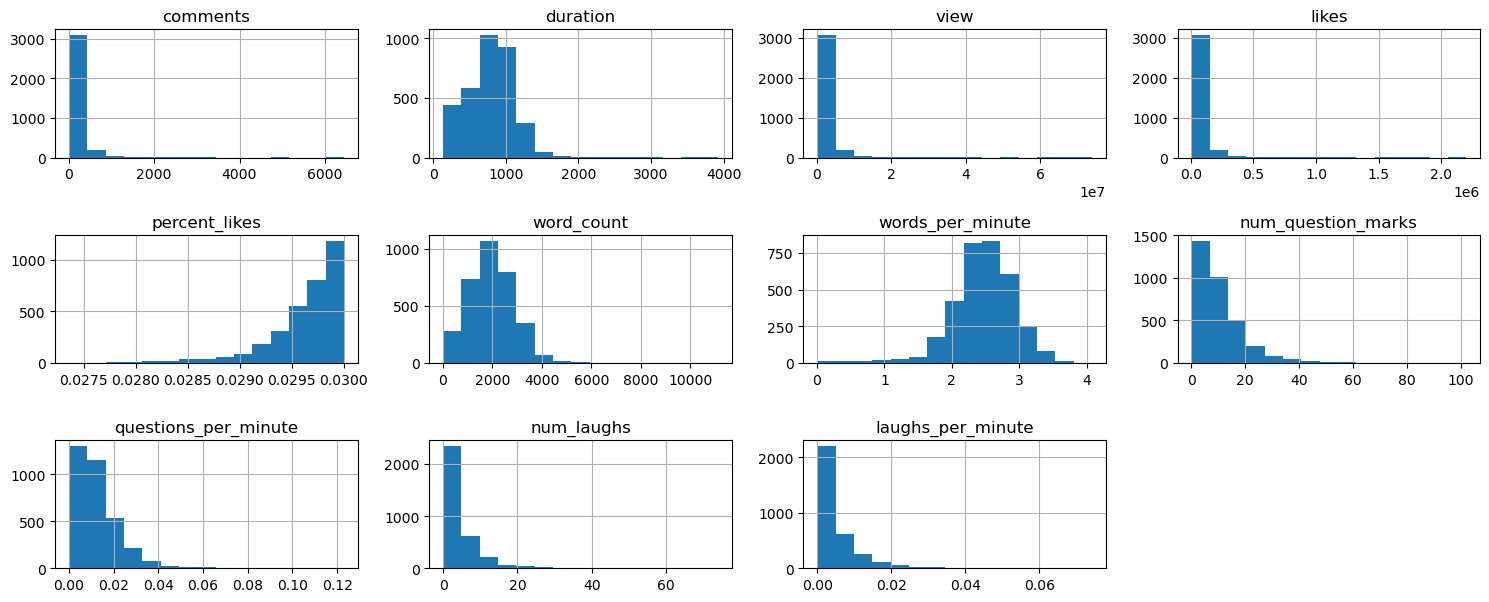

In [65]:
# Histograms for numerical features
numerical_df = merged_cleaved_df[['comments', 'duration', 'view', 'likes',
       'percent_likes', 'word_count', 'words_per_minute',
       'num_question_marks', 'questions_per_minute', 'num_laughs',
       'laughs_per_minute']]

numerical_df.hist(bins=15, figsize=(15, 10), layout=(5, 4))
plt.tight_layout()
plt.show()

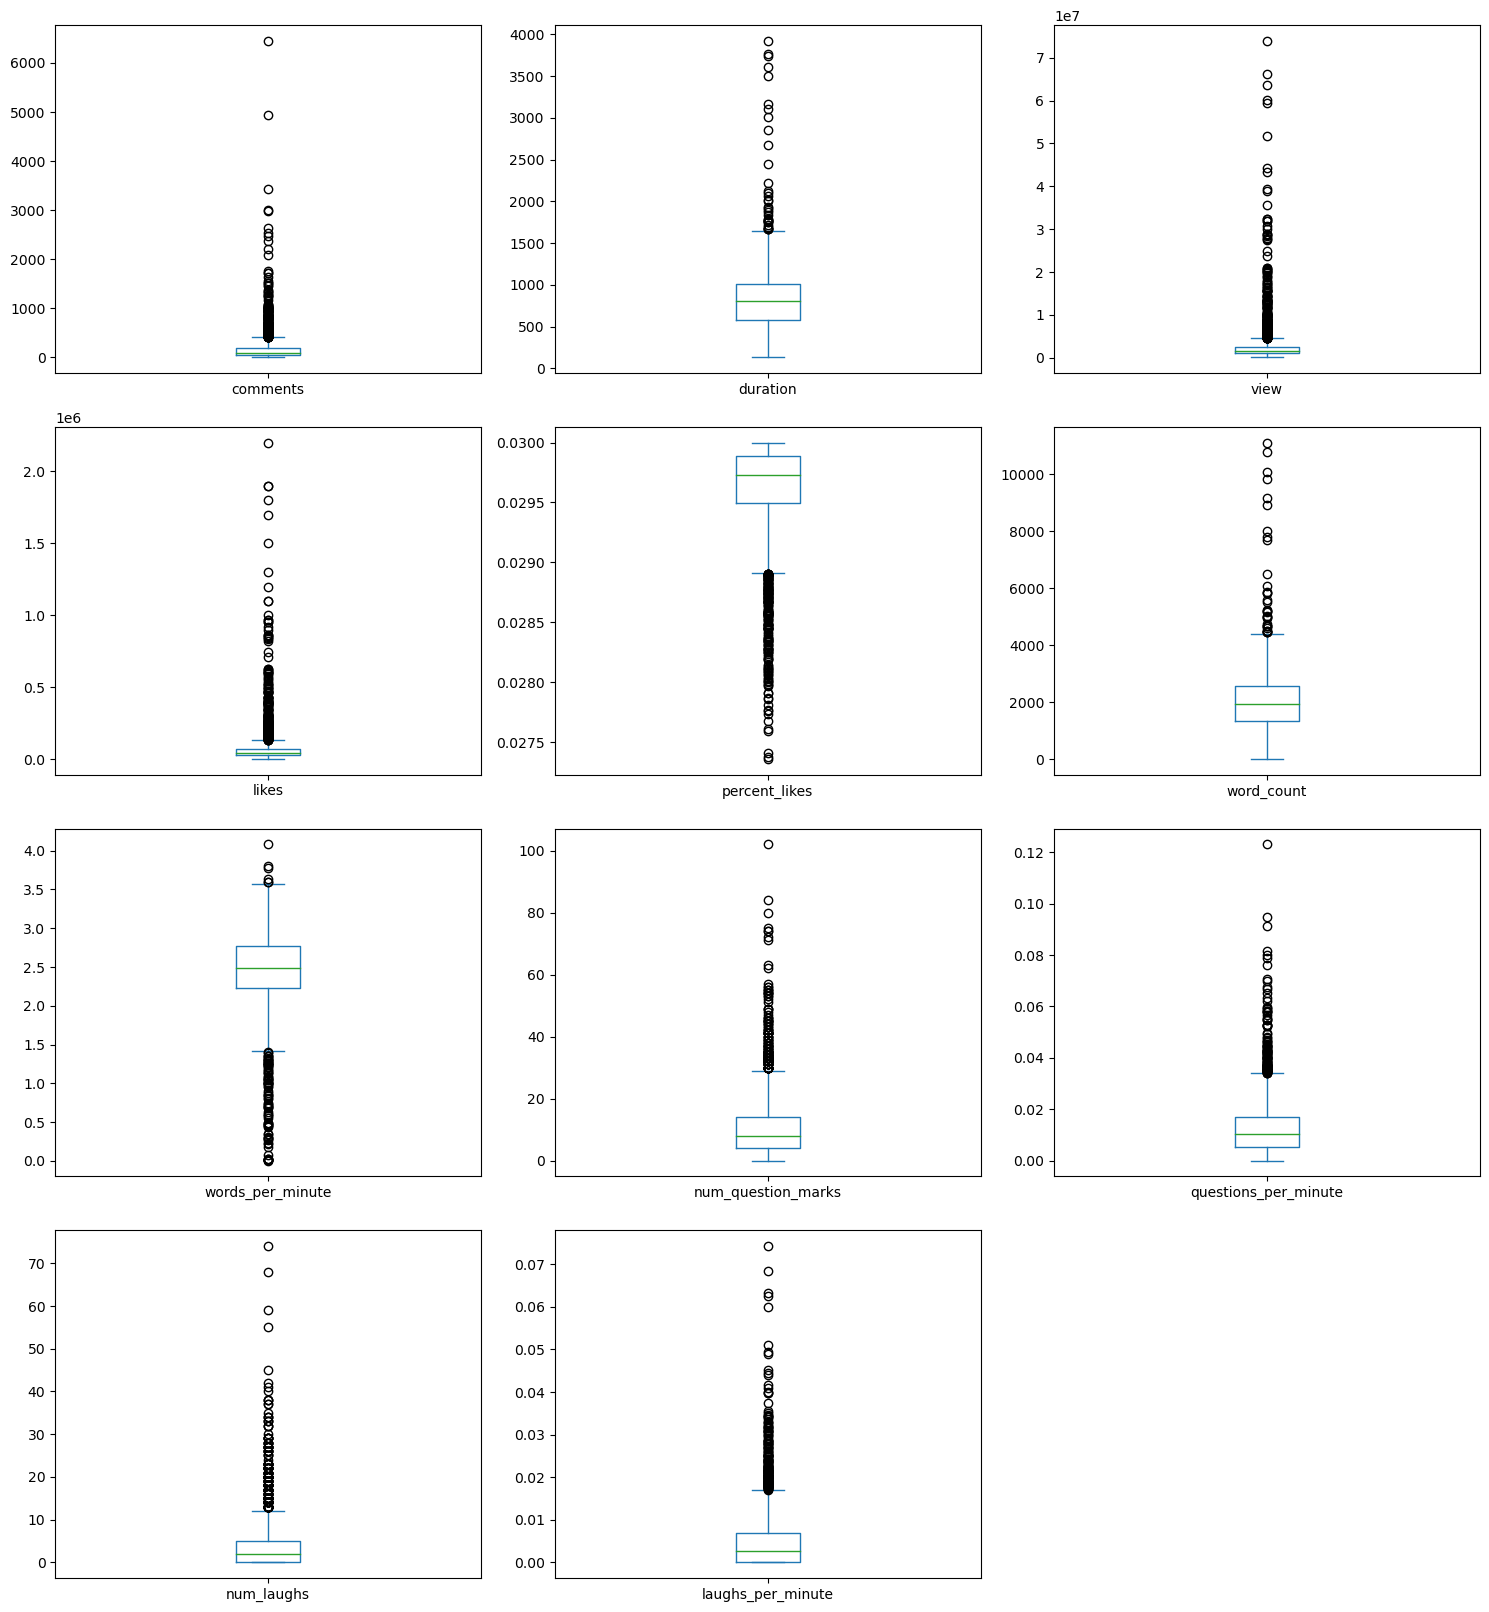

In [66]:
# Boxplots for numerical features to identify outliers

numerical_df = merged_cleaved_df[['comments', 'duration', 'view', 'likes',
       'percent_likes', 'word_count', 'words_per_minute',
       'num_question_marks', 'questions_per_minute', 'num_laughs',
       'laughs_per_minute']]

numerical_df.plot(kind='box', subplots=True, layout=(5,3), figsize=(15, 20))
plt.tight_layout()
plt.show()

### Interesting findings:

- The mean number of laughs per TED talk is roughly 4.
- All percent_likes are between 2.7% and 3%.  TED talks are all similarly 'liked'.
- The mean duration is roughly 800 seconds (13.3 minutes).
- The mean number of words in a TED talk is roughly 2000.

/Users/drewe/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


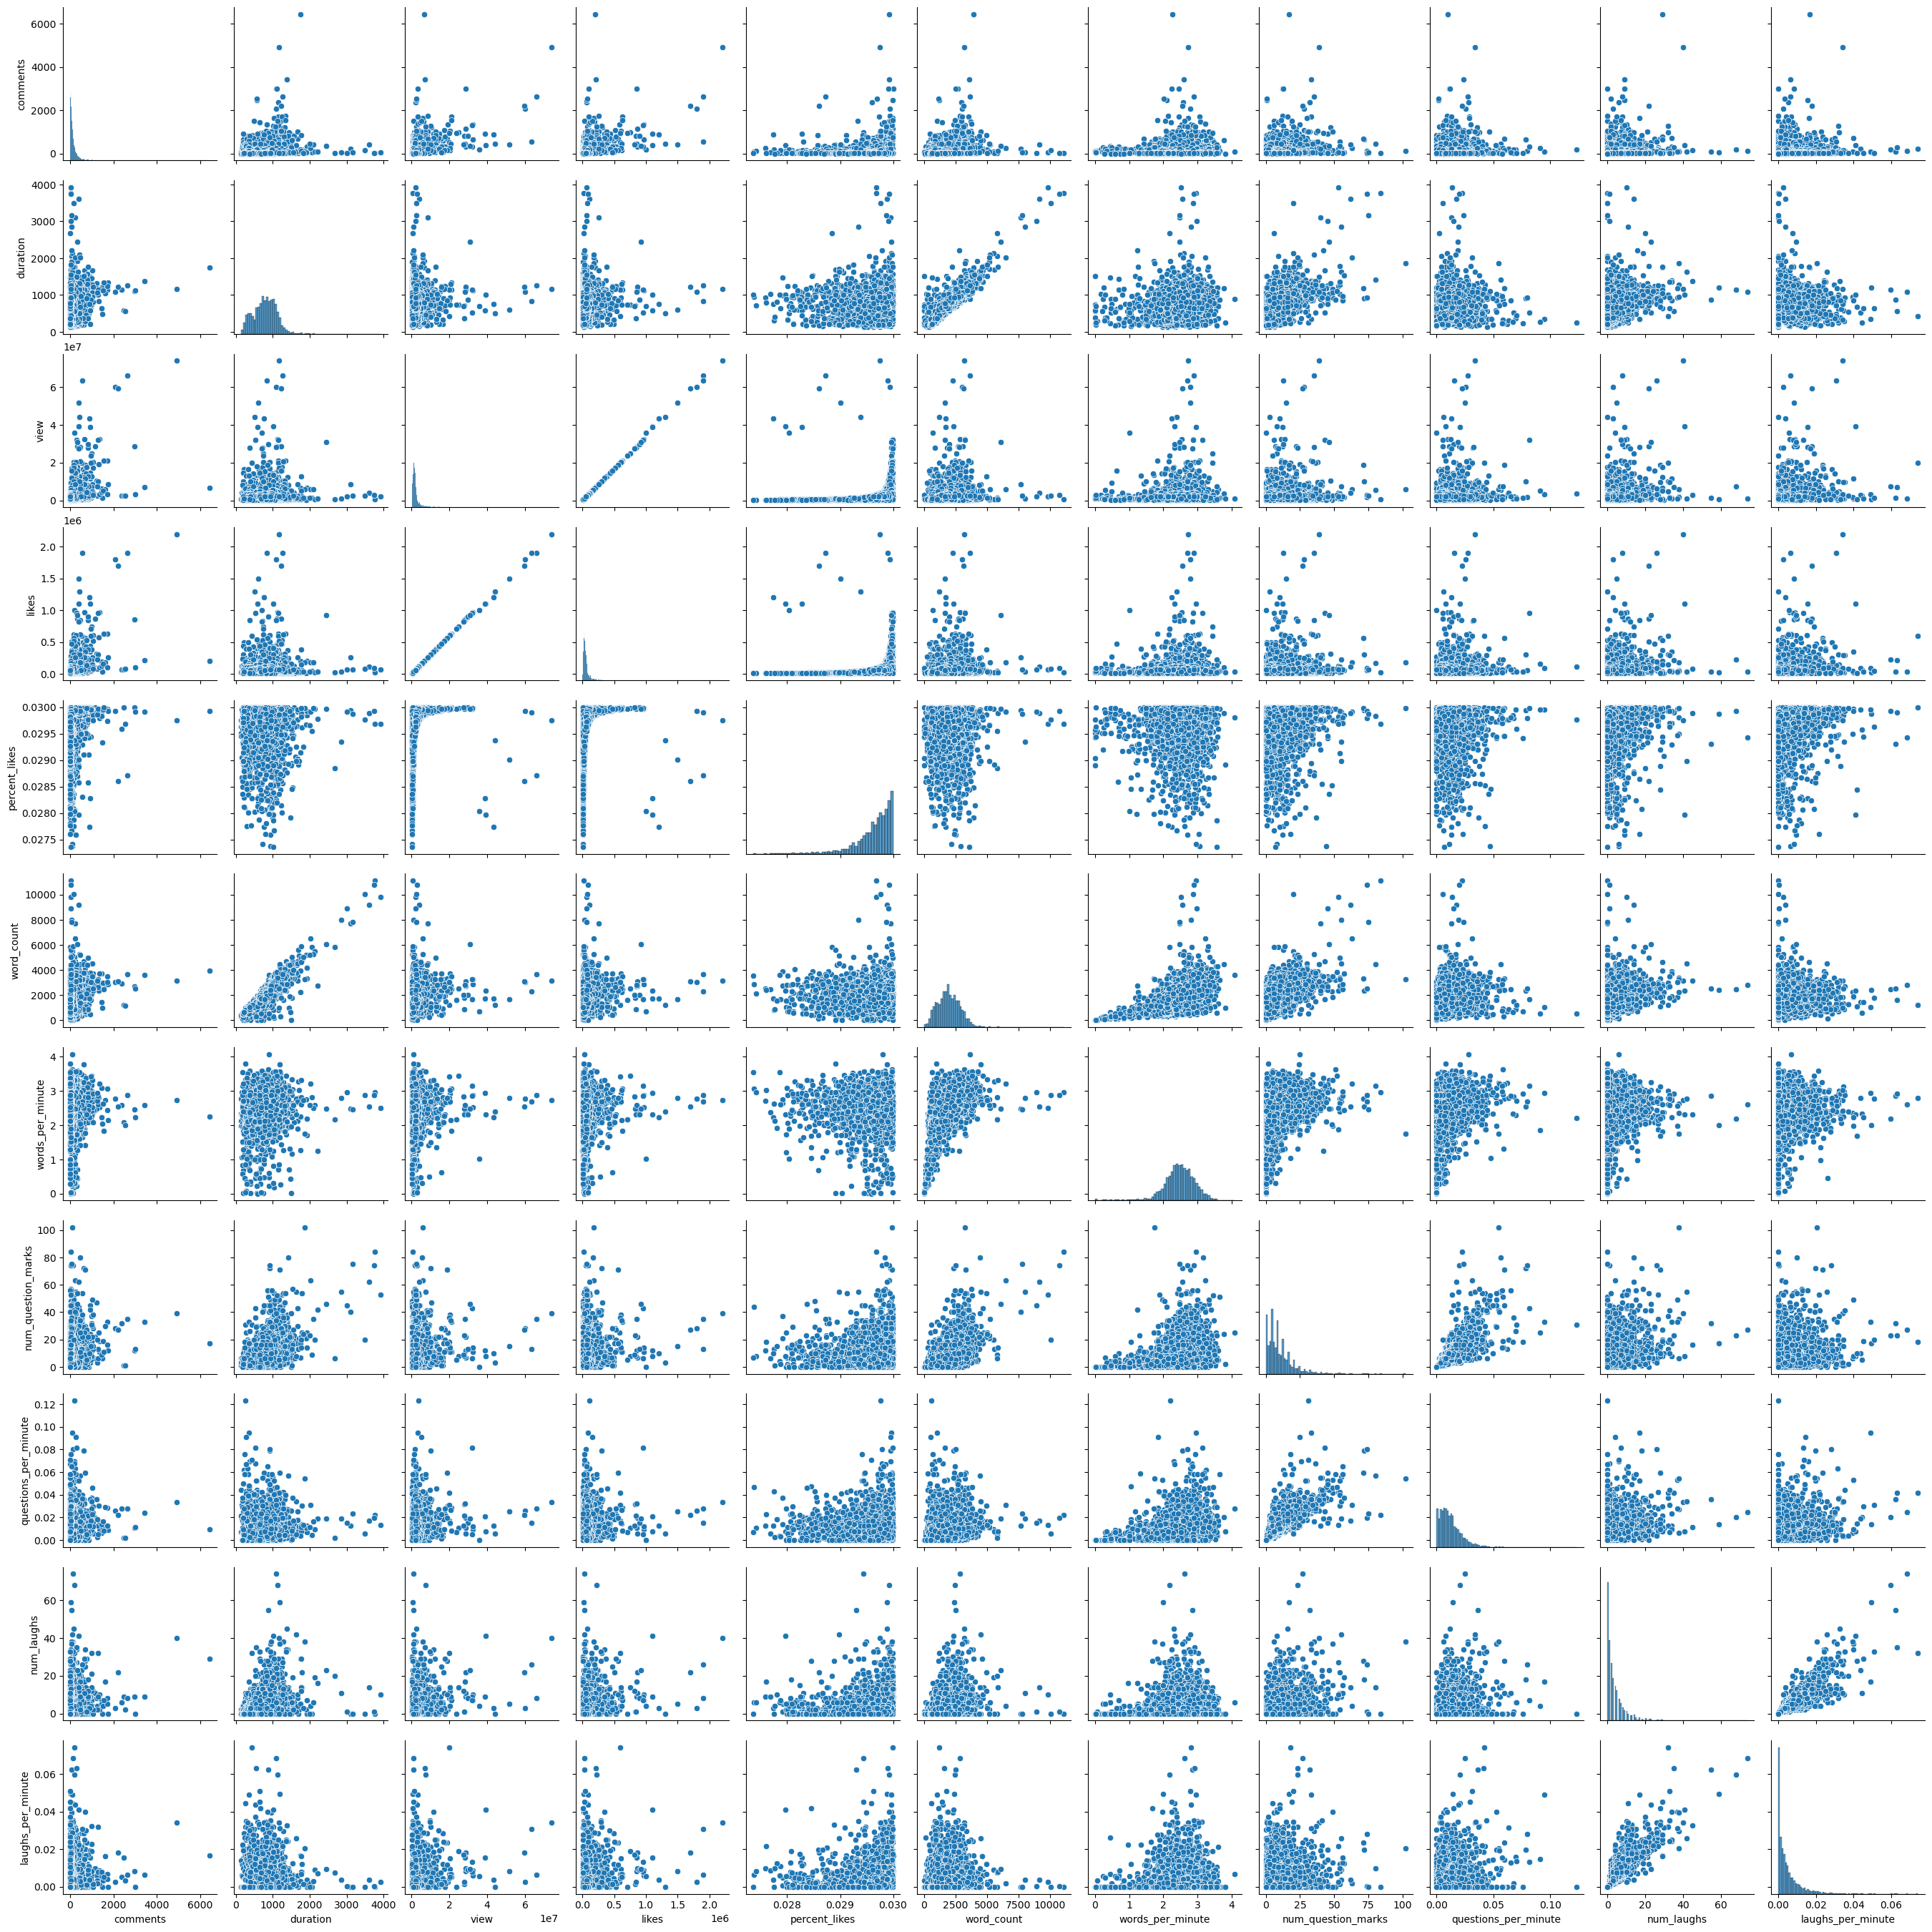

In [67]:
# Ensuring that only numerical columns are included for the pairplot
numerical_df = merged_cleaved_df[['comments', 'duration', 'view', 'likes',
       'percent_likes', 'word_count', 'words_per_minute',
       'num_question_marks', 'questions_per_minute', 'num_laughs',
       'laughs_per_minute']]

# Pairplot for all numerical features
sns.pairplot(numerical_df)
plt.show()

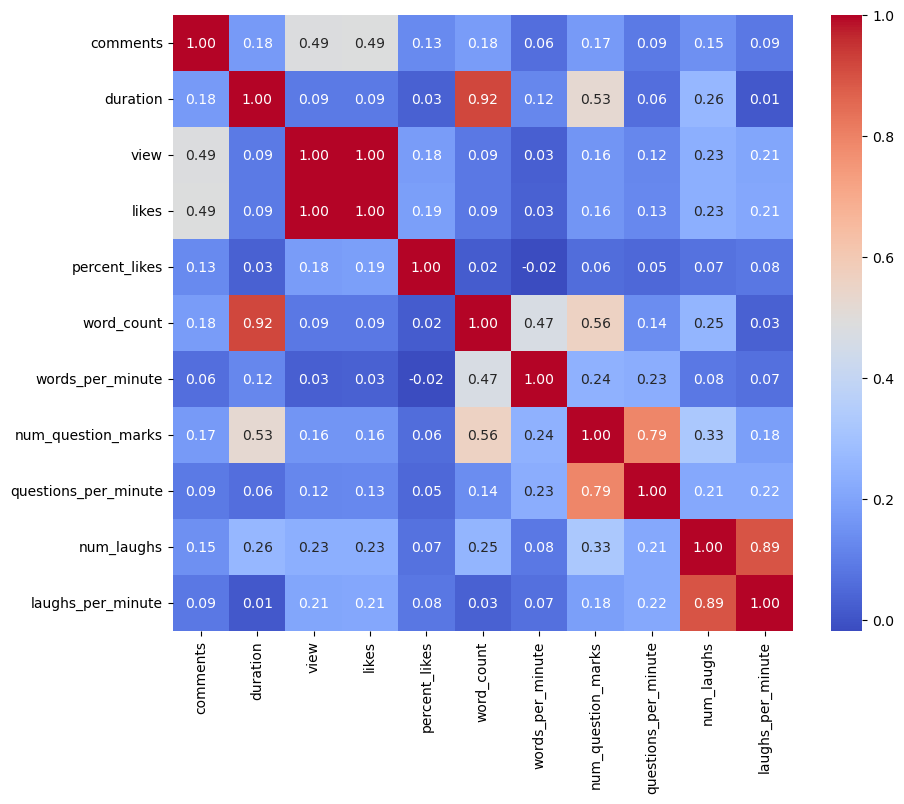

In [68]:
# Correlation heatmap for all numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

### Interesting findings:

- The number of question marks is 0.53 correlated with the talks duration.  It seems like the more a talk contains questions, the longer it is.
- Likes and Views are 0.49 correlated with comments.  This makes sense, as the more attention a talk gets, the more it is commentd on.
- The number of laughs is 0.33 corrlated with the number of questions asked (num question marks).  
- The number of laughs is 0.25 correlated with word count, and 0.26 correlated with the length of the talk (duration).

# 5. Baseline Model:

Result:

Logistic Regression:
| Metric      | Score           |
|-------------|-----------------|
| Train score | 0.6674174174174174 |
| Test score  | 0.6111111111111112 |
| C-Value     | 0.01               |

Random Forest:
| Metric      | Score           |
|--------------|-----------------|
| Train score  | 0.6415165165165165 |
| Test score   | 0.6036036036036037 |
| n_estimator  | 50                 |
| max_depth    | 1                  |


Logistic Regression (top 10 positive coefficients):
| Feature         | Coefficient |
|-----------------|-------------|
| want know       | 0.199189    |
| answer question | 0.143010    |
| feels like      | 0.140254    |
| people say      | 0.138928    |
| 30 percent      | 0.130456    |
| know people     | 0.118156    |
| years later     | 0.117891    |
| people think    | 0.115096    |
| ill just        | 0.112731    |
| 20 percent      | 0.106108    |


Logistic Regression (bottom 10 positive coefficients):
| Feature          | Coefficient |
|------------------|-------------|
| 30 years         | -0.088847   |
| tell stories     | -0.089245   |
| 20 years         | -0.091348   |
| going make       | -0.093560   |
| weve got         | -0.093574   |
| thats going      | -0.094823   |
| 90 percent       | -0.115024   |
| ladies gentlemen | -0.145435   |
| just want        | -0.169773   |
| people living    | -0.182530   |


Random Forest:
| Feature          | Importance |
|------------------|------------|
| people living    | 0.014109   |
| years ago        | 0.011912   |
| looks like       | 0.011641   |
| im going         | 0.009189   |
| little bit       | 0.009115   |
| dont know        | 0.009049   |
| want know        | 0.008681   |
| ladies gentlemen | 0.008574   |
| united states    | 0.008531   |
| people think     | 0.007573   |

In [69]:
X=dummy_merged_df.drop("good_speech", axis=1)
y=dummy_merged_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


In [70]:
# CountVectorizing the 'transcript' column
# Custom stop words
custom_stop_words = ["laughter", "applause", "laughter applause", "--", "-", "♫ ♫", "♫"]

# Combine custom stop words with default English stop words
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_words))

# As tokenizers must be functions, we will define a function for the tokenizer we will use
def nltk_tokenizer(text):
    # Remove punctuation using a list comprehension
    text_no_punctuation = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenize the text without punctuation
    return word_tokenize(text_no_punctuation)

# instantiate CountVectorizer
bagofwords_transcript = CountVectorizer(stop_words=stop_words, # remove stop words
                                        tokenizer=nltk_tokenizer, # use the NLTK tokenizer
                                        min_df=10, # minimum document frequency of 10
                                        max_df=0.8, # maximum document frequency of 75% (i.e., ignore words that appear in more than 75% of the documents)
                                        ngram_range=(2, 6), # allowing for bigrams, and trigrams
                                        max_features=300) # maximum number of features to keep

# Fit the CountVectorizer object on the positive (and, separately, negative) reviews
bagofwords_transcript.fit(X_train["transcript"])
print(bagofwords_transcript.fit(X_train["transcript"]))

/Users/drewe/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(max_df=0.8, max_features=300, min_df=10, ngram_range=(2, 6),
                stop_words=['anyway', 'back', 'except', 'mill', 'under', 'had',
                            'wherever', 'either', 'what', 'of', 'well', 'than',
                            'towards', 'not', 'throughout', 'was', 'but',
                            'done', 'there', 'everything', 'describe',
                            'therefore', 'nothing', 'already', 'thereafter',
                            'is', 'no', 'latter', 'beforehand', 'around', ...],
                tokenizer=<function nltk_tokenizer at 0x2c683c430>)


In [71]:
sparse_matrix_train = bagofwords_transcript.transform(X_train["transcript"])
sparse_matrix_test = bagofwords_transcript.transform(X_test["transcript"])

## Logistic Regression on CountVectorized Transcripts (Baseline Model)

We will use this as our baseline model.

We will at the same time find which C-value (feature penalties) is optimal. 

In [72]:
# List of C values to iterate over
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Loop through the list of C values
for C_val in C_values:
    # Instantiate the Logistic Regression model with the current C value
    logreg = LogisticRegression(C=C_val, max_iter=1000, n_jobs=-1)
    
    # Fit the model to the training data
    logreg.fit(sparse_matrix_train, y_train)
    
    # Calculate and print the training and test scores
    train_score = logreg.score(sparse_matrix_train, y_train)
    test_score = logreg.score(sparse_matrix_test, y_test)
    print(f"C={C_val}: Train score: {train_score}, Test score: {test_score}")


C=0.001: Train score: 0.6415165165165165, Test score: 0.6036036036036037
C=0.01: Train score: 0.6674174174174174, Test score: 0.6111111111111112
C=0.1: Train score: 0.6959459459459459, Test score: 0.5720720720720721
C=1: Train score: 0.7023273273273273, Test score: 0.5645645645645646
C=10: Train score: 0.6985735735735735, Test score: 0.566066066066066
C=100: Train score: 0.698948948948949, Test score: 0.566066066066066


In [73]:
# Instantiate the Logistic Regression model with the current C value
logreg = LogisticRegression(C=0.01, max_iter=1000, n_jobs=-1)

# Fit the model to the training data
logreg.fit(sparse_matrix_train, y_train)

# Calculate and print the training and test scores
train_score = logreg.score(sparse_matrix_train, y_train)
test_score = logreg.score(sparse_matrix_test, y_test)
print(f"Train score: {train_score}, Test score: {test_score}")


Train score: 0.6674174174174174, Test score: 0.6111111111111112


The optimal C-value is 0.01.  We will use this value in our tests going forward.

What are the features with the highest coefficients (which features were most impactful in the model?)

In [74]:
# Extracting coefficients
coefficients = logreg.coef_[0]  # For logistic regression, `coef_` returns an array in shape (n_classes, n_features)

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame to show features with the highest absolute coefficient values at the top
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Display the top N most impactful features
print(coefficients_df.head(10))
print(coefficients_df.tail(10))


             Feature  Coefficient
251        want know     0.199189
20   answer question     0.143010
67        feels like     0.140254
177       people say     0.138928
11        30 percent     0.130456
117      know people     0.118156
268      years later     0.117891
178     people think     0.115096
87          ill just     0.112731
5         20 percent     0.106108
              Feature  Coefficient
12           30 years    -0.088847
215      tell stories    -0.089245
6            20 years    -0.091348
71         going make    -0.093560
259          weve got    -0.093574
221       thats going    -0.094823
19         90 percent    -0.115024
122  ladies gentlemen    -0.145435
109         just want    -0.169773
172     people living    -0.182530


## Random Forest Classifier Model (Baseline Model)

In [75]:
# Define ranges for n_estimators and max_depth
n_estimators_values = [10, 50, 100, 200]
max_depth_values = [None, 1, 3, 5, 10, 20]

# Loop through the list of n_estimators values
for n_estimators in n_estimators_values:
    # Then loop through the list of max_depth values
    for max_depth in max_depth_values:
        # Instantiate the Random Forest model with the current values of n_estimators and max_depth
        random_forest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42)
        
        # Fit the model to the training data
        random_forest.fit(sparse_matrix_train, y_train)
        
        # Calculate and print the training and test scores
        train_score_rf = random_forest.score(sparse_matrix_train, y_train)
        test_score_rf = random_forest.score(sparse_matrix_test, y_test)
        print(f"n_estimators={n_estimators}, max_depth={max_depth}: Train score: {train_score_rf}, Test score: {test_score_rf}")


n_estimators=10, max_depth=None: Train score: 0.984984984984985, Test score: 0.5465465465465466
n_estimators=10, max_depth=1: Train score: 0.6418918918918919, Test score: 0.6036036036036037
n_estimators=10, max_depth=3: Train score: 0.6448948948948949, Test score: 0.6036036036036037
n_estimators=10, max_depth=5: Train score: 0.6471471471471472, Test score: 0.6021021021021021
n_estimators=10, max_depth=10: Train score: 0.6933183183183184, Test score: 0.5945945945945946
n_estimators=10, max_depth=20: Train score: 0.7905405405405406, Test score: 0.5975975975975976
n_estimators=50, max_depth=None: Train score: 0.9966216216216216, Test score: 0.581081081081081
n_estimators=50, max_depth=1: Train score: 0.6415165165165165, Test score: 0.6036036036036037
n_estimators=50, max_depth=3: Train score: 0.6418918918918919, Test score: 0.6036036036036037
n_estimators=50, max_depth=5: Train score: 0.6437687687687688, Test score: 0.6036036036036037
n_estimators=50, max_depth=10: Train score: 0.68506006

n_estimators=100, max_depth=10: Train score: 0.6843093093093093, Test score: 0.5990990990990991
n_estimators=100, max_depth=20: Train score: 0.8044294294294294, Test score: 0.6006006006006006
n_estimators=200, max_depth=None: Train score: 0.9966216216216216, Test score: 0.5990990990990991
n_estimators=200, max_depth=1: Train score: 0.6415165165165165, Test score: 0.6036036036036037
n_estimators=200, max_depth=3: Train score: 0.6415165165165165, Test score: 0.6036036036036037
n_estimators=200, max_depth=5: Train score: 0.6426426426426426, Test score: 0.6036036036036037
n_estimators=200, max_depth=10: Train score: 0.6843093093093093, Test score: 0.6021021021021021
n_estimators=200, max_depth=20: Train score: 0.8048048048048048, Test score: 0.5975975975975976


We will use n_estimators = 50 and max_depth = 1 going forward. 

In [76]:
# Extracting feature importance
feature_importances = random_forest.feature_importances_

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation and visualization
import pandas as pd

features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
print(features_df.head(10))


              Feature  Importance
172     people living    0.014109
266         years ago    0.011912
140        looks like    0.011641
89           im going    0.009189
136        little bit    0.009115
57          dont know    0.009049
251         want know    0.008681
122  ladies gentlemen    0.008574
250     united states    0.008531
178      people think    0.007573


# 6. Model Iteration

We now have solid baseline models in both a Logistic Regression and a Random Forest Decision Tree Model.

We will iterate over our selected features to see:
1. which coefficients/feature_importances we can see as having the most influence, and
2. if we can produce a better performing model

## Model Iterations:

| Model Iteration # | Description                                                                                      |
|-------------------|--------------------------------------------------------------------------------------------------|
| 1                 | Baseline Model with n_grams (1, 6)                                                               |
| 2                 | Limit our features to only the numeric columns of the original dataset (no countvectorizing and no dummying) |
| 3 (a, b, c, d)    | Transcript Only: Countvectorization of the "transcript" column, running various max_features and n_grams.        |
| 3a.                | Max Features 500, n_gram 2,6:                                                                |
| 3b.                | Max Features 200, n_gram 2,6:                                                                |
| 3c.                | Max Features 200, n_gram 3,6:                                                                |
| 3d.                | Max Features 200, n_gram 4,6:                                                                |
| 4                 | Include countvectorization and topics dummies (do not include occupation dummies)                |
| 5                 | Only analyzing original numerical features and topics dummies (do not include occupation dummies, and do not countvectorize) |
| 6                 | Running our models on only the (MultiLabelBinarized / dummied) speech topics                                                                                   |
| 7                 | Using a TF-IDF vectorizer, and then running the Baseline Model with n_grams (2, 6)                   |
| 8                 | Changing our threshold of "Great Speech" to include the top 80% of speeches, upsampling the minority class, then running the Baseline Model with n_grams (2, 6) |
| 9                 | Using BERT on the Speech Transcripts                                                                 |
| 10                | Linear Regression on Various Numerical Features                                                  |


## Model 1: Baseline Model with n_grams (1, 6)

### Result:

Logistic Regression:
| Metric      | Score           |
|-------------|-----------------|
| Train score | 0.6674174174174174 |
| Test score  | 0.6111111111111112 |


Random Forest:
| Metric      | Score           |
|--------------|-----------------|
| Train score  | 0.6415165165165165 |
| Test score   | 0.6036036036036037 |


Logistic Regression (top 10 positive coefficients):
| Feature  | Coefficient |
|----------|-------------|
| mind     | 0.090314    |
| students | 0.081181    |
| thinking | 0.081134    |
| exactly  | 0.078422    |
| doesnt   | 0.077536    |
| instead  | 0.070875    |
| hand     | 0.067619    |
| happen   | 0.067269    |
| computer | 0.066404    |
| number   | 0.064237    |



Logistic Regression (bottom 10 positive coefficients):
| Feature  | Coefficient |
|----------|-------------|
| left     | -0.057576   |
| simple   | -0.058305   |
| book     | -0.059713   |
| working  | -0.061128   |
| months   | -0.061594   |
| took     | -0.063037   |
| bring    | -0.071974   |
| decided  | -0.072279   |
| build    | -0.080311   |
| im going | -0.085750   |



Random Forest:
| Feature    | Importance |
|------------|------------|
| good       | 0.10       |
| mind       | 0.08       |
| youre      | 0.06       |
| experience | 0.04       |
| water      | 0.04       |
| life       | 0.04       |
| person     | 0.04       |
| doesnt     | 0.02       |
| job        | 0.02       |
| does       | 0.02       |

In [77]:
X=dummy_merged_df.drop("good_speech", axis=1)
y=dummy_merged_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


In [78]:
# CountVectorizing the 'transcript' column
# Custom stop words
custom_stop_words = ["laughter", "applause", "laughter applause", "--", "-", "♫ ♫", "♫"]

# Combine custom stop words with default English stop words
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_words))

# As tokenizers must be functions, we will define a function for the tokenizer we will use
def nltk_tokenizer(text):
    # Remove punctuation using a list comprehension
    text_no_punctuation = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenize the text without punctuation
    return word_tokenize(text_no_punctuation)

# instantiate CountVectorizer
bagofwords_transcript = CountVectorizer(stop_words=stop_words, # remove stop words
                                        tokenizer=nltk_tokenizer, # use the NLTK tokenizer
                                        min_df=10, # minimum document frequency of 10
                                        max_df=0.8, # maximum document frequency of 75% (i.e., ignore words that appear in more than 75% of the documents)
                                        ngram_range=(1, 6), # allowing for bigrams, and trigrams
                                        max_features=300) # maximum number of features to keep

# Fit the CountVectorizer object on the positive (and, separately, negative) reviews
bagofwords_transcript.fit(X_train["transcript"])
print(bagofwords_transcript.fit(X_train["transcript"]))

/Users/drewe/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(max_df=0.8, max_features=300, min_df=10, ngram_range=(1, 6),
                stop_words=['anyway', 'back', 'except', 'mill', 'under', 'had',
                            'wherever', 'either', 'what', 'of', 'well', 'than',
                            'towards', 'not', 'throughout', 'was', 'but',
                            'done', 'there', 'everything', 'describe',
                            'therefore', 'nothing', 'already', 'thereafter',
                            'is', 'no', 'latter', 'beforehand', 'around', ...],
                tokenizer=<function nltk_tokenizer at 0x356ee5ca0>)


In [79]:
sparse_matrix_train = bagofwords_transcript.transform(X_train["transcript"])
sparse_matrix_test = bagofwords_transcript.transform(X_test["transcript"])

### Logistic Regression on n_grams (1, 6)

In [80]:
# Instantiate the Logistic Regression model with the current C value
logreg = LogisticRegression(C=0.01, max_iter=1000, n_jobs=-1)

# Fit the model to the training data
logreg.fit(sparse_matrix_train, y_train)

# Calculate and print the training and test scores
train_score = logreg.score(sparse_matrix_train, y_train)
test_score = logreg.score(sparse_matrix_test, y_test)
print(f"Train score: {train_score}, Test score: {test_score}")


Train score: 0.6873123123123123, Test score: 0.6081081081081081


What are the features with the highest coefficients (which features were most impactful in the model?)

In [81]:
# Extracting coefficients
coefficients = logreg.coef_[0]  # For logistic regression, `coef_` returns an array in shape (n_classes, n_features)

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame to show features with the highest absolute coefficient values at the top
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Display the top N most impactful features
print(coefficients_df.head(10))
print(coefficients_df.tail(10))


      Feature  Coefficient
169      mind     0.090314
243  students     0.081181
256  thinking     0.081134
75    exactly     0.078422
66     doesnt     0.077536
129   instead     0.070875
98       hand     0.067619
99     happen     0.067269
49   computer     0.066404
178    number     0.064237
      Feature  Coefficient
143      left    -0.057576
228    simple    -0.058305
24       book    -0.059713
289   working    -0.061128
172    months    -0.061594
262      took    -0.063037
26      bring    -0.071974
59    decided    -0.072279
27      build    -0.080311
124  im going    -0.085750


### Random Forest Classifier Model on n_grams (1, 6)

In [82]:
# Instantiate the Random Forest model with the current values of n_estimators and max_depth
random_forest = RandomForestClassifier(n_estimators=50, max_depth=1, n_jobs=-1, random_state=42)

# Fit the model to the training data
random_forest.fit(sparse_matrix_train, y_train)

# Calculate and print the training and test scores
train_score_rf = random_forest.score(sparse_matrix_train, y_train)
test_score_rf = random_forest.score(sparse_matrix_test, y_test)
print(f"Train score: {train_score_rf}, Test score: {test_score_rf}")


Train score: 0.6415165165165165, Test score: 0.6036036036036037


In [83]:
# Extracting feature importance
feature_importances = random_forest.feature_importances_

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation and visualization
import pandas as pd

features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
print(features_df.head(10))


        Feature  Importance
91         good        0.10
169        mind        0.08
298       youre        0.06
77   experience        0.04
278       water        0.04
146        life        0.04
187      person        0.04
66       doesnt        0.02
134         job        0.02
65         does        0.02


## Model Iteration: 2. limit our features to only the numeric columns of the original dataset (no countvectorizing and no dummying)

### Result:

Logistic Regression:
| Metric      | Score        |
|-------------|--------------|
| Train score | 0.641517     |
| Test score  | 0.603604     |


Random Forest:
| Metric      | Score     |
|-------------|-----------|
| Train Score | 0.641517  |
| Test Score  | 0.603604  |


Logistic Regression:
| Feature               | Coefficient |
|---------------------|------------|
| ted_mainstage       | 0.169018   |
| num_question_marks  | 0.088434   |
| comments            | 0.074825   |
| laughs_per_minute   | 0.074142   |
| questions_per_minute| 0.070605   |
| num_laughs          | 0.061112   |
| word_count          | 0.036111   |
| duration            | 0.032129   |
| words_per_minute    | 0.028710   |
| multiple_speakers   | -0.049351  |



Random Forest:
| Feature             | Importance |
|---------------------|------------|
| comments            | 0.28       |
| laughs_per_minute   | 0.16       |
| questions_per_minute| 0.12       |
| num_laughs          | 0.10       |
| words_per_minute    | 0.08       |
| num_question_marks  | 0.08       |
| duration            | 0.06       |
| ted_mainstage       | 0.06       |
| word_count          | 0.06       |
| multiple_speakers   | 0.00       |


In [84]:
# Dropping the non numerical columns
ready_to_merge_numerical_df = merged_cleaved_df.select_dtypes(include=['int64', 'float64'])
ready_to_merge_numerical_df.drop(["talk_id"], axis=1, inplace=True) # Dropping the talk_id column
ready_to_merge_numerical_df.drop(["likes"], axis=1, inplace=True) # Dropping the likes column
ready_to_merge_numerical_df.drop(["view"], axis=1, inplace=True) # Dropping the view column
ready_to_merge_numerical_df['percent_likes'] = merged_cleaved_df['percent_likes'] # Adding the percent_likes column back in
ready_to_merge_numerical_df.info()
print(ready_to_merge_numerical_df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 3330 entries, 0 to 3993
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   comments              3330 non-null   float64
 1   duration              3330 non-null   int64  
 2   multiple_speakers     3330 non-null   int64  
 3   percent_likes         3330 non-null   float64
 4   ted_mainstage         3330 non-null   int64  
 5   word_count            3330 non-null   int64  
 6   words_per_minute      3330 non-null   float64
 7   num_question_marks    3330 non-null   int64  
 8   questions_per_minute  3330 non-null   float64
 9   num_laughs            3330 non-null   int64  
 10  laughs_per_minute     3330 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 312.2 KB
(3330, 11)


In [85]:
# creating a new column called 'good_speech' that is 1 if the speech is in the top 50% of percent_likes, and 0 if it is in the bottom 50% of percent_likes

# Calculate the 50th percentile (median) of the 'percent_likes' column
median_percent_likes = ready_to_merge_numerical_df['percent_likes'].mean()

# Create the 'good_speech' column based on the condition
ready_to_merge_numerical_df['good_speech'] = (ready_to_merge_numerical_df['percent_likes'] >= median_percent_likes).astype(int)

# Now, merged_cleaved_df has a new column 'good_speech' with 1s and 0s based on the condition

# since this data is already represented in the "good_speech" column, we'll drop the "percent_likes" column
ready_to_merge_numerical_df.drop(["percent_likes"], axis=1, inplace=True) # Dropping the percent_likes column

In [86]:
# Scaling the data

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# List of columns to scale
columns_to_scale = ['comments', 'duration', 'word_count', 'words_per_minute', 'num_question_marks', 
                    'questions_per_minute', 'num_laughs', 'laughs_per_minute']

# Scale the selected columns and replace in the dataframe
ready_to_merge_numerical_df[columns_to_scale] = scaler.fit_transform(ready_to_merge_numerical_df[columns_to_scale])

In [87]:
X=ready_to_merge_numerical_df.drop("good_speech", axis=1)
y=ready_to_merge_numerical_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


### Logistic Regression on Original Numerical Columns

In [88]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(C = 0.01, max_iter=1000, n_jobs=-1) 

#Fit the model
logreg.fit(X_train, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train, y_train)}")
print(f"Test score: {logreg.score(X_test, y_test)}")

Train score: 0.6415165165165165
Test score: 0.6036036036036037


What are the features with the highest coefficients (which features were most impactful in the model?)

In [89]:
# Assuming X_train is a pandas DataFrame
feature_names = X_train.columns

# Extracting the coefficients
coefficients = logreg.coef_[0]

# Creating a DataFrame for better readability
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sorting the DataFrame by the absolute values of the coefficients in descending order
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Printing the DataFrame
print(coefficients_df)


                Feature  Coefficient
3         ted_mainstage     0.169018
6    num_question_marks     0.088434
0              comments     0.074825
9     laughs_per_minute     0.074142
7  questions_per_minute     0.070605
8            num_laughs     0.061112
4            word_count     0.036111
1              duration     0.032129
5      words_per_minute     0.028710
2     multiple_speakers    -0.049351


### Random Forest Classifier on Original Numerical Columns

In [90]:
# Instantiate the Random Forest model
# n_estimators is the number of trees in the forest, max_depth is the maximum depth of the trees
random_forest = RandomForestClassifier(n_estimators=50, max_depth=1, n_jobs=-1, random_state=42)

# Fit the model on the training data
# Note: Random Forest handles the feature importance internally, so scaling is not as critical as in logistic regression
random_forest.fit(X_train, y_train)

# Training and test score
train_score_rf = random_forest.score(X_train, y_train)
test_score_rf = random_forest.score(X_test, y_test)

print(f"Train score: {train_score_rf}")
print(f"Test score: {test_score_rf}")

Train score: 0.6415165165165165
Test score: 0.6036036036036037


In [91]:
# Extracting feature importance
feature_importances = random_forest.feature_importances_

features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
print(features_df.head(10))


                Feature  Importance
0              comments        0.28
9     laughs_per_minute        0.16
7  questions_per_minute        0.12
8            num_laughs        0.10
5      words_per_minute        0.08
6    num_question_marks        0.08
1              duration        0.06
3         ted_mainstage        0.06
4            word_count        0.06
2     multiple_speakers        0.00


## Model Iteration: 3. Transcript Only: Countvectorization of the "transcript" column, running various max_features and n_grams.

We counvectorized using the following combinations of max_features and n_grams:

- Max Features 500, n_gram 2,6
- Max Features 200, n_gram 2,6
- Max Features 200, n_gram 3,6
- Max Features 200, n_gram 4,6


### Result:

#### Max Features 500, n_gram 2,6:

    Logistic Regression:
| Metric       | Score        |
|--------------|--------------|
| Train score  | 0.6437687688 |
| Test score   | 0.6096096096 |

    Random Forest:
| Metric       | Score        |
|--------------|--------------|
| Train score  | 0.6512762763 |
| Test score   | 0.5990990991 |

        

#### Max Features 200, n_gram 2,6:

    Logistic Regression:
| Metric       | Score        |
|--------------|--------------|
| Train score  | 0.6441441441 |
| Test score   | 0.6096096096 |
    
    Random Forest:
| Metric       | Score        |
|--------------|--------------|
| Train score  | 0.9962462462 |
| Test score   | 0.5855855856 |
        

#### Max Features 200, n_gram 3,6:

    Logistic Regression:
| Metric       | Score        |
|--------------|--------------|
| Train score  | 0.6415165165 |
| Test score   | 0.6036036036 |

    Random Forest:
| Metric       | Score        |
|--------------|--------------|
| Train score  | 0.8599849850 |
| Test score   | 0.5690690691 |


#### Max Features 200, n_gram 4,6:

    Logistic Regression:
| Metric       | Score        |
|--------------|--------------|
| Train score  | 0.6415165165 |
| Test score   | 0.6036036036 |

    Random Forest:
| Metric       | Score        |
|--------------|--------------|
| Train score  | 0.6512762763 |
| Test score   | 0.5990990991 |




### Coefficients and Important_Features:

**Max Features 500, n_gram 2,6**:

Logistic Regression (top 10 positive coefficients):
| Feature          | Coefficient |
|------------------|-------------|
| want know        | 0.038674    |
| people say       | 0.028643    |
| people think     | 0.026238    |
| feels like       | 0.025608    |
| dont think       | 0.024323    |
| black hole       | 0.022536    |
| know people      | 0.022126    |
| years later      | 0.020346    |
| answer question  | 0.019935    |
| high school      | 0.019769    |

Logistic Regression (top 10 negative coefficients):
| Feature        | Coefficient |
|----------------|-------------|
| — theyre       | -0.013201   |
| looked like    | -0.013604   |
| going make     | -0.014004   |
| dont want      | -0.014266   |
| years ago      | -0.014587   |
| youre seeing   | -0.014933   |
| thats going    | -0.015702   |
| stem cells     | -0.016102   |
| 20 years       | -0.016648   |
| 90 percent     | -0.017463   |


Random Forest (top 10 feature importance):
| Feature       | Importance |
|---------------|------------|
| years ago     | 0.008267   |
| little bit    | 0.007942   |
| im going      | 0.007934   |
| united states | 0.007818   |
| looks like    | 0.007428   |
| dont know     | 0.007099   |
| new york      | 0.006233   |
| people living | 0.005921   |
| dont want     | 0.005228   |
| id like       | 0.00519    |




**Max Features 200, n_gram 2,6**:

Logistic Regression (top 10 positive coefficients):

| Feature          | Coefficient |
|------------------|-------------|
| want know        | 0.039334    |
| people say       | 0.029366    |
| people think     | 0.026868    |
| feels like       | 0.026130    |
| dont think       | 0.025444    |
| black hole       | 0.023943    |
| know people      | 0.022474    |
| years later      | 0.020595    |
| high school      | 0.020350    |
| answer question  | 0.020276    |

Logistic Regression (top 10 negative coefficients):
| Feature         | Coefficient |
|-----------------|-------------|
| want talk       | -0.012010   |
| public health   | -0.012439   |
| billion people  | -0.012615   |
| whats going     | -0.012632   |
| million people  | -0.013118   |
| — theyre        | -0.013279   |
| looked like     | -0.013664   |
| dont want       | -0.013932   |
| going make      | -0.013938   |
| years ago       | -0.014915   |


Random Forest (top 10 feature importance):
| Feature        | Importance |
|----------------|------------|
| years ago      | 0.017003   |
| im going       | 0.015808   |
| united states  | 0.013924   |
| dont know      | 0.012760   |
| looks like     | 0.012600   |
| little bit     | 0.012325   |
| id like        | 0.010884   |
| new york       | 0.010279   |
| 10 years       | 0.009843   |
| just like      | 0.009789   |




**Max Features 200, n_gram 3,6**:

Logistic Regression (top 10 positive coefficients):
| Feature               | Coefficient |
|-----------------------|-------------|
| just little bit       | 0.012587    |
| say things like       | 0.009311    |
| martin luther king    | 0.008210    |
| blah blah blah        | 0.008072    |
| don ’ t               | 0.005960    |
| thats good thing      | 0.005930    |
| hubble space telescope| 0.005765    |
| dont know people      | 0.005476    |
| know dont know        | 0.005271    |
| music music ends      | 0.005257    |

Logistic Regression (top 10 negative coefficients):
| Feature                     | Coefficient |
|-----------------------------|-------------|
| 40 years ago                | -0.003641   |
| international space station | -0.003710   |
| doesnt look like            | -0.003868   |
| little bit different        | -0.004017   |
| 20 years ago                | -0.004078   |
| know im going               | -0.004224   |
| world trade center          | -0.004249   |
| today im going              | -0.004470   |
| world wide web              | -0.004638   |
| im going make               | -0.004904   |


Random Forest (top 10 feature importance):
| Feature             | Importance |
|---------------------|------------|
| new york city       | 0.020171   |
| new york times      | 0.014279   |
| im going tell       | 0.013936   |
| im going talk       | 0.013907   |
| 10 years ago        | 0.011581   |
| 20 years ago        | 0.010626   |
| little bit like     | 0.010120   |
| 15 years ago        | 0.009633   |
| world war ii        | 0.009455   |
| million years ago   | 0.008828   |


**Max Features 200, n_gram 4,6**:

Logistic Regression (top 10 positive coefficients):
| Feature                    | Coefficient |
|----------------------------|-------------|
| let tell little bit        | 0.003087    |
| martin luther king jr      | 0.002650    |
| im going im going          | 0.001601    |
| make world better place    | 0.001591    |
| — dont know —              | 0.001372    |
| im going tell story        | 0.001089    |
| cut long story short       | 0.000941    |
| going talk little bit      | 0.000657    |
| im going talk little       | 0.000299    |
| dont know dont know        | 0.000094    |

Logistic Regression (top 10 negative coefficients) :
| Feature                      | Coefficient |
|------------------------------|-------------|
| dont know dont know          | 0.000094    |
| know whats going happen      | -0.000414   |
| want talk little bit         | -0.001542   |
| today im going talk          | -0.002334   |
| id like talk today           | -0.003330   |
| thank chris anderson thank   | -0.003408   |
| im going talk today          | -0.003448   |
| weve come long way           | -0.004327   |
| small thing big idea         | -0.004327   |
| thank thank thank thank      | -0.006758   |


Random Forest (top 10 feature importance):
| Feature                    | Importance |
|----------------------------|------------|
| weve come long way         | 0.108924   |
| thank thank thank thank    | 0.105864   |
| small thing big idea       | 0.092390   |
| thank chris anderson thank | 0.084021   |
| im going talk today        | 0.076134   |
| id like talk today         | 0.063073   |
| let tell little bit        | 0.056309   |
| make world better place    | 0.049534   |
| dont know dont know        | 0.047605   |
| today im going talk        | 0.046653   |

In [92]:
# Creating a Transcript Only Dataframe
only_transcript_df = merged_cleaved_df[['percent_likes', 'transcript']]
only_transcript_df

,percent_likes,transcript
0,0.029879,"Thank you so much, Chris. And it's truly a gre..."
1,0.029936,"About 10 years ago, I took on the task to teac..."
2,0.029809,"(Music: ""The Sound of Silence,"" Simon & Garfun..."
3,0.029937,If you're here today — and I'm very happy that...
4,0.029755,Good morning. How are you? (Audience) Good. It...
...,...,...
3985,0.029753,I never thought that I would be giving my TED ...
3986,0.029726,[Oliver Jeffers] [An ode to living on Earth] H...
3990,0.029619,"Helen Walters: So, Chris, who's up first? Chri..."
3991,0.029580,"""I'm 14, and I want to go home."" ""My name is B..."


In [93]:
# creating a new column called 'good_speech' that is 1 if the speech is in the top 50% of percent_likes, and 0 if it is in the bottom 50% of percent_likes

# Calculate the 50th percentile (median) of the 'percent_likes' column
median_percent_likes = only_transcript_df['percent_likes'].mean()

# Create the 'good_speech' column based on the condition
only_transcript_df['good_speech'] = (only_transcript_df['percent_likes'] >= median_percent_likes).astype(int)

# Now, merged_cleaved_df has a new column 'good_speech' with 1s and 0s based on the condition

only_transcript_df.drop(["percent_likes"], axis=1, inplace=True) # Dropping the percent_likes column

/var/folders/l2/d5ln4l29453322fq40g1dz2h0000gn/T/ipykernel_1369/375638890.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_transcript_df['good_speech'] = (only_transcript_df['percent_likes'] >= median_percent_likes).astype(int)
/var/folders/l2/d5ln4l29453322fq40g1dz2h0000gn/T/ipykernel_1369/375638890.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_transcript_df.drop(["percent_likes"], axis=1, inplace=True) # Dropping the percent_likes column


### Max Features 500, n_gram 2,6:

In [94]:
X=only_transcript_df.drop("good_speech", axis=1)
y=only_transcript_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


In [95]:
## CountVectorizing the 'transcript' column
# Custom stop words
custom_stop_words = ["laughter", "applause", "laughter applause", "--", "-", "♫ ♫"]

# Combine custom stop words with default English stop words
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_words))

# As tokenizers must be functions, we will define a function for the tokenizer we will use
def nltk_tokenizer(text):
    # Remove punctuation using a list comprehension
    text_no_punctuation = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenize the text without punctuation
    return word_tokenize(text_no_punctuation)

# instantiate CountVectorizer
bagofwords_transcript = CountVectorizer(stop_words=stop_words, # remove stop words
                                        tokenizer=nltk_tokenizer, # use the NLTK tokenizer
                                        min_df=10, # minimum document frequency of 10
                                        max_df=0.8, # maximum document frequency of 75% (i.e., ignore words that appear in more than 75% of the documents)
                                        ngram_range=(2, 6), # allowing for bigrams, and trigrams
                                        max_features=500) # maximum number of features to keep

# Fit the CountVectorizer object on the positive (and, separately, negative) reviews
bagofwords_transcript.fit(X_train["transcript"])
print(bagofwords_transcript.fit(X_train["transcript"]))

/Users/drewe/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/drewe/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['♫'] not in stop_words.
  warnings.warn(


CountVectorizer(max_df=0.8, max_features=500, min_df=10, ngram_range=(2, 6),
                stop_words=['anyway', 'back', 'except', 'mill', 'under', 'had',
                            'wherever', 'either', 'what', 'of', 'well', 'than',
                            'towards', 'not', 'throughout', 'was', 'but',
                            'done', 'there', 'everything', 'describe',
                            'therefore', 'nothing', 'already', 'thereafter',
                            'is', 'no', 'latter', 'beforehand', 'around', ...],
                tokenizer=<function nltk_tokenizer at 0x3669931f0>)


In [96]:
sparse_matrix_train = bagofwords_transcript.transform(X_train["transcript"])
sparse_matrix_test = bagofwords_transcript.transform(X_test["transcript"])

### Logistic Regression Max Features 500, n_gram 2,6:

In [97]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(C = 0.01, max_iter=1000, n_jobs=-1) 

#Fit the model
logreg.fit(sparse_matrix_train, y_train)

# Training and test score
print(f"Train score: {logreg.score(sparse_matrix_train, y_train)}")
print(f"Test score: {logreg.score(sparse_matrix_test, y_test)}")

Train score: 0.6756756756756757
Test score: 0.6171171171171171


What are the features with the highest coefficients (which features were most impactful in the model?)

In [98]:
# Extracting coefficients
coefficients = logreg.coef_[0]  # For logistic regression, `coef_` returns an array in shape (n_classes, n_features)

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame to show features with the highest absolute coefficient values at the top
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Display the top N most impactful features
print(coefficients_df.head(20))
print(coefficients_df.tail(20))


             Feature  Coefficient
422        want know     0.189437
29   answer question     0.136131
288       people say     0.134234
98        feels like     0.131484
17        30 percent     0.127425
183      know people     0.119374
289     people think     0.113663
455      years later     0.109343
137         ill just     0.106431
10        20 percent     0.106112
34          bad news     0.104103
461      youre doing     0.097041
165      just little     0.095186
73    different ways     0.093722
99         felt like     0.093709
90        dont think     0.093633
308      really good     0.087021
243    mental health     0.085259
215       like think     0.084595
384    things happen     0.084417
              Feature  Coefficient
226        looks like    -0.077958
317      really think    -0.080995
465      youre seeing    -0.081446
472             — did    -0.082189
490          — theyre    -0.083319
352      tell stories    -0.084251
437         weeks ago    -0.084783
441   

### Random Forest Classifier Model on Max Features 500, n_gram 2,6:

In [99]:
# Instantiate the Random Forest model
# n_estimators is the number of trees in the forest, max_depth is the maximum depth of the trees
random_forest = RandomForestClassifier(n_estimators=50, max_depth=1, random_state=42)

# Fit the model on the training data
# Note: Random Forest handles the feature importance internally, so scaling is not as critical as in logistic regression
random_forest.fit(sparse_matrix_train, y_train)

# Training and test score
train_score_rf = random_forest.score(sparse_matrix_train, y_train)
test_score_rf = random_forest.score(sparse_matrix_test, y_test)

print(f"Train score: {train_score_rf}")
print(f"Test score: {test_score_rf}")

Train score: 0.6415165165165165
Test score: 0.6036036036036037


What are the features with the highest feature importances (which features were most impactful in the model?)

In [100]:
# Extracting feature importance
feature_importances = random_forest.feature_importances_

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation and visualization
import pandas as pd

features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
print(features_df.head(10))


           Feature  Importance
282  people living        0.06
498            ♫ ♫        0.04
422      want know        0.04
362    thats great        0.04
119     good thing        0.02
463     youre just        0.02
32   ask questions        0.02
183    know people        0.02
287    people said        0.02
288     people say        0.02


### Max Features = 200, n_gram = 2,6

In [101]:
X=only_transcript_df.drop("good_speech", axis=1)
y=only_transcript_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


In [102]:
## CountVectorizing the 'transcript' column
# Custom stop words
custom_stop_words = ["laughter", "applause", "laughter applause", "--", "-", "♫ ♫"]

# Combine custom stop words with default English stop words
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_words))

# As tokenizers must be functions, we will define a function for the tokenizer we will use
def nltk_tokenizer(text):
    # Remove punctuation using a list comprehension
    text_no_punctuation = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenize the text without punctuation
    return word_tokenize(text_no_punctuation)

# instantiate CountVectorizer
bagofwords_transcript = CountVectorizer(stop_words=stop_words, # remove stop words
                                        tokenizer=nltk_tokenizer, # use the NLTK tokenizer
                                        min_df=10, # minimum document frequency of 10
                                        max_df=0.8, # maximum document frequency of 75% (i.e., ignore words that appear in more than 75% of the documents)
                                        ngram_range=(2, 6), # allowing for bigrams, and trigrams
                                        max_features=200) # maximum number of features to keep

# Fit the CountVectorizer object on the positive (and, separately, negative) reviews
bagofwords_transcript.fit(X_train["transcript"])
print(bagofwords_transcript.fit(X_train["transcript"]))

/Users/drewe/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/drewe/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['♫'] not in stop_words.
  warnings.warn(


CountVectorizer(max_df=0.8, max_features=200, min_df=10, ngram_range=(2, 6),
                stop_words=['anyway', 'back', 'except', 'mill', 'under', 'had',
                            'wherever', 'either', 'what', 'of', 'well', 'than',
                            'towards', 'not', 'throughout', 'was', 'but',
                            'done', 'there', 'everything', 'describe',
                            'therefore', 'nothing', 'already', 'thereafter',
                            'is', 'no', 'latter', 'beforehand', 'around', ...],
                tokenizer=<function nltk_tokenizer at 0x2c683c430>)


In [103]:
sparse_matrix_train = bagofwords_transcript.transform(X_train["transcript"])
sparse_matrix_test = bagofwords_transcript.transform(X_test["transcript"])

### Logistic Regression on Max Features 200, n_gram 2,6:

In [104]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(C = 0.01, max_iter=1000, n_jobs=-1) 

#Fit the model
logreg.fit(sparse_matrix_train, y_train)

# Training and test score
print(f"Train score: {logreg.score(sparse_matrix_train, y_train)}")
print(f"Test score: {logreg.score(sparse_matrix_test, y_test)}")

Train score: 0.661036036036036
Test score: 0.6186186186186187


What are the features with the highest coefficients (which features were most impactful in the model?)

In [105]:
# Extracting coefficients
coefficients = logreg.coef_[0]  # For logistic regression, `coef_` returns an array in shape (n_classes, n_features)

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame to show features with the highest absolute coefficient values at the top
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Display the top N most impactful features
print(coefficients_df.head(20))
print(coefficients_df.tail(20))


             Feature  Coefficient
164        want know     0.200878
17   answer question     0.145872
43        feels like     0.141422
119       people say     0.138896
8         30 percent     0.136543
120     people think     0.121019
78       know people     0.120998
176      years later     0.119036
5         20 percent     0.105320
44         felt like     0.102824
39        dont think     0.098754
87        like think     0.097478
31    different ways     0.093867
72       just little     0.093390
180      youre doing     0.093095
77         know know     0.086588
129      really good     0.086414
130      really hard     0.079739
36         dont like     0.079695
62         im saying     0.079050
           Feature  Coefficient
11        40 years    -0.057552
15      80 percent    -0.058204
182  youre looking    -0.058617
41       dont want    -0.065470
194       — theres    -0.066553
166      want talk    -0.075064
100    middle east    -0.078034
192       — really    -0.07894

### Random Forest Classifier Model on Max Features 200, n_gram 2,6:

In [106]:
# Instantiate the Random Forest model
# n_estimators is the number of trees in the forest, max_depth is the maximum depth of the trees
random_forest = RandomForestClassifier(n_estimators=50, max_depth=1, n_jobs=-1, random_state=42)

# Fit the model on the training data
# Note: Random Forest handles the feature importance internally, so scaling is not as critical as in logistic regression
random_forest.fit(sparse_matrix_train, y_train)

# Training and test score
train_score_rf = random_forest.score(sparse_matrix_train, y_train)
test_score_rf = random_forest.score(sparse_matrix_test, y_test)

print(f"Train score: {train_score_rf}")
print(f"Test score: {test_score_rf}")

Train score: 0.6415165165165165
Test score: 0.6036036036036037


What are the features with the highest feature importances (which features were most impactful in the model?)

In [107]:
# Extracting feature importance
feature_importances = random_forest.feature_importances_

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation and visualization
import pandas as pd

features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
print(features_df.head(10))


             Feature  Importance
120     people think        0.10
100      middle east        0.06
119       people say        0.06
78       know people        0.06
73         just want        0.06
17   answer question        0.04
175        years ago        0.04
164        want know        0.04
113      people just        0.04
53       high school        0.04


### Max Features = 200, n_gram = 3,6

In [108]:
X=only_transcript_df.drop("good_speech", axis=1)
y=only_transcript_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


In [109]:
## CountVectorizing the 'transcript' column
# Custom stop words
custom_stop_words = ["laughter", "applause", "laughter applause", "--", "-", "♫ ♫", "♫"]

# Combine custom stop words with default English stop words
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_words))

# As tokenizers must be functions, we will define a function for the tokenizer we will use
def nltk_tokenizer(text):
    # Remove punctuation using a list comprehension
    text_no_punctuation = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenize the text without punctuation
    return word_tokenize(text_no_punctuation)

# instantiate CountVectorizer
bagofwords_transcript = CountVectorizer(stop_words=stop_words, # remove stop words
                                        tokenizer=nltk_tokenizer, # use the NLTK tokenizer
                                        min_df=10, # minimum document frequency of 10
                                        max_df=0.8, # maximum document frequency of 75% (i.e., ignore words that appear in more than 75% of the documents)
                                        ngram_range=(3, 6), # allowing for bigrams, and trigrams
                                        max_features=200) # maximum number of features to keep

# Fit the CountVectorizer object on the positive (and, separately, negative) reviews
bagofwords_transcript.fit(X_train["transcript"])
print(bagofwords_transcript.fit(X_train["transcript"]))

/Users/drewe/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(max_df=0.8, max_features=200, min_df=10, ngram_range=(3, 6),
                stop_words=['anyway', 'back', 'except', 'mill', 'under', 'had',
                            'wherever', 'either', 'what', 'of', 'well', 'than',
                            'towards', 'not', 'throughout', 'was', 'but',
                            'done', 'there', 'everything', 'describe',
                            'therefore', 'nothing', 'already', 'thereafter',
                            'is', 'no', 'latter', 'beforehand', 'around', ...],
                tokenizer=<function nltk_tokenizer at 0x366993430>)


In [110]:
sparse_matrix_train = bagofwords_transcript.transform(X_train["transcript"])
sparse_matrix_test = bagofwords_transcript.transform(X_test["transcript"])

### Logistic Regression on Max Features 200, n_gram 3,6:

In [111]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(C = 0.01, max_iter=1000, n_jobs=-1) 

#Fit the model
logreg.fit(sparse_matrix_train, y_train)

# Training and test score
print(f"Train score: {logreg.score(sparse_matrix_train, y_train)}")
print(f"Test score: {logreg.score(sparse_matrix_test, y_test)}")

Train score: 0.6426426426426426
Test score: 0.6036036036036037


What are the features with the highest coefficients (which features were most impactful in the model?)

In [112]:
# Extracting coefficients
coefficients = logreg.coef_[0]  # For logistic regression, `coef_` returns an array in shape (n_classes, n_features)

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame to show features with the highest absolute coefficient values at the top
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Display the top N most impactful features
print(coefficients_df.head(20))
print(coefficients_df.tail(20))


                    Feature  Coefficient
93          just little bit     0.103662
142         say things like     0.086414
120      martin luther king     0.069048
160        thats good thing     0.056581
63   hubble space telescope     0.053671
42         dont know people     0.050790
124        music music ends     0.047586
96           know dont know     0.047518
140           say dont know     0.044639
137      really really hard     0.043986
49         dont really know     0.042310
98          know im talking     0.041943
104         let tell little     0.038946
35        doesnt make sense     0.038243
24           blah blah blah     0.037387
37                  don ’ t     0.037301
32           does look like     0.036928
132    people united states     0.035931
110       little bit better     0.035871
169   united states america     0.034711
                         Feature  Coefficient
5                   11 years old    -0.033536
91   international space station    -0.033552
1

### Random Forest Classifier Model on Max Features 200, n_gram 3,6:

In [113]:
# Instantiate the Random Forest model
# n_estimators is the number of trees in the forest, max_depth is the maximum depth of the trees
random_forest = RandomForestClassifier(n_estimators=50, max_depth=1, n_jobs=-1, random_state=42)

# Fit the model on the training data
# Note: Random Forest handles the feature importance internally, so scaling is not as critical as in logistic regression
random_forest.fit(sparse_matrix_train, y_train)

# Training and test score
train_score_rf = random_forest.score(sparse_matrix_train, y_train)
test_score_rf = random_forest.score(sparse_matrix_test, y_test)

print(f"Train score: {train_score_rf}")
print(f"Test score: {test_score_rf}")

Train score: 0.6415165165165165
Test score: 0.6036036036036037


What are the features with the highest feature importances (which features were most impactful in the model?)

In [114]:
# Extracting feature importance
feature_importances = random_forest.feature_importances_

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation and visualization
import pandas as pd

features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
print(features_df.head(10))


                         Feature  Importance
142              say things like        0.08
91   international space station        0.04
182           world trade center        0.04
5                   11 years old        0.04
77                  im going say        0.04
27                 come long way        0.04
81           im going talk today        0.04
42              dont know people        0.02
129             people dont like        0.02
89             im really excited        0.02


### Max Features = 200, n_gram = 4,6

In [115]:
X=only_transcript_df.drop("good_speech", axis=1)
y=only_transcript_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


In [116]:
## CountVectorizing the 'transcript' column
# Custom stop words
custom_stop_words = ["laughter", "applause", "laughter applause", "--", "-", "♫ ♫", "♫"]

# Combine custom stop words with default English stop words
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_words))

# As tokenizers must be functions, we will define a function for the tokenizer we will use
def nltk_tokenizer(text):
    # Remove punctuation using a list comprehension
    text_no_punctuation = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenize the text without punctuation
    return word_tokenize(text_no_punctuation)

# instantiate CountVectorizer
bagofwords_transcript = CountVectorizer(stop_words=stop_words, # remove stop words
                                        tokenizer=nltk_tokenizer, # use the NLTK tokenizer
                                        min_df=10, # minimum document frequency of 10
                                        max_df=0.8, # maximum document frequency of 75% (i.e., ignore words that appear in more than 75% of the documents)
                                        ngram_range=(4, 6), # allowing for bigrams, and trigrams
                                        max_features=200) # maximum number of features to keep

# Fit the CountVectorizer object on the positive (and, separately, negative) reviews
bagofwords_transcript.fit(X_train["transcript"])
print(bagofwords_transcript.fit(X_train["transcript"]))

/Users/drewe/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(max_df=0.8, max_features=200, min_df=10, ngram_range=(4, 6),
                stop_words=['anyway', 'back', 'except', 'mill', 'under', 'had',
                            'wherever', 'either', 'what', 'of', 'well', 'than',
                            'towards', 'not', 'throughout', 'was', 'but',
                            'done', 'there', 'everything', 'describe',
                            'therefore', 'nothing', 'already', 'thereafter',
                            'is', 'no', 'latter', 'beforehand', 'around', ...],
                tokenizer=<function nltk_tokenizer at 0x303c5fa60>)


In [117]:
sparse_matrix_train = bagofwords_transcript.transform(X_train["transcript"])
sparse_matrix_test = bagofwords_transcript.transform(X_test["transcript"])

### Logistic Regression on Max Features = 200, n_gram = 4,6

In [118]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(C = 0.01, max_iter=1000, n_jobs=-1) 

#Fit the model
logreg.fit(sparse_matrix_train, y_train)

# Training and test score
print(f"Train score: {logreg.score(sparse_matrix_train, y_train)}")
print(f"Test score: {logreg.score(sparse_matrix_test, y_test)}")

Train score: 0.6415165165165165
Test score: 0.6036036036036037


What are the features with the highest coefficients (which features were most impactful in the model?)

In [119]:
# Extracting coefficients
coefficients = logreg.coef_[0]  # For logistic regression, `coef_` returns an array in shape (n_classes, n_features)

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame to show features with the highest absolute coefficient values at the top
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Display the top N most impactful features
print(coefficients_df.head(20))
print(coefficients_df.tail(20))


                       Feature  Coefficient
9          let tell little bit     0.029937
11       martin luther king jr     0.025571
4            im going im going     0.015433
10     make world better place     0.014754
18               — dont know —     0.013181
7          im going tell story     0.010348
0         cut long story short     0.009199
2        going talk little bit     0.006281
5         im going talk little     0.002725
1          dont know dont know     0.000907
8      know whats going happen    -0.004085
16        want talk little bit    -0.014979
15         today im going talk    -0.022825
3           id like talk today    -0.032399
6          im going talk today    -0.032462
13  thank chris anderson thank    -0.033395
17          weve come long way    -0.042090
12        small thing big idea    -0.042159
14     thank thank thank thank    -0.042772
                       Feature  Coefficient
9          let tell little bit     0.029937
11       martin luther king jr  

### Random Forest Classifier Model on Max Features = 200, n_gram = 4,6

In [120]:
# Instantiate the Random Forest model
# n_estimators is the number of trees in the forest, max_depth is the maximum depth of the trees
random_forest = RandomForestClassifier(n_estimators=50, max_depth=1, n_jobs=-1, random_state=42)

# Fit the model on the training data
# Note: Random Forest handles the feature importance internally, so scaling is not as critical as in logistic regression
random_forest.fit(sparse_matrix_train, y_train)

# Training and test score
train_score_rf = random_forest.score(sparse_matrix_train, y_train)
test_score_rf = random_forest.score(sparse_matrix_test, y_test)

print(f"Train score: {train_score_rf}")
print(f"Test score: {test_score_rf}")

Train score: 0.6415165165165165
Test score: 0.6036036036036037


What are the features with the highest feature importances (which features were most impactful in the model?)

In [121]:
# Extracting feature importance
feature_importances = random_forest.feature_importances_

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation and visualization
import pandas as pd

features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
print(features_df.head(10))


                       Feature  Importance
12        small thing big idea        0.16
13  thank chris anderson thank        0.14
17          weve come long way        0.12
6          im going talk today        0.10
14     thank thank thank thank        0.08
9          let tell little bit        0.06
11       martin luther king jr        0.06
15         today im going talk        0.06
5         im going talk little        0.06
3           id like talk today        0.04


## Model Iteration: 4. include countvectorization and topics dummies (do not include occupation dummies)

Result:
Logistic Regression:
| Metric      | Score                  |
|-------------|------------------------|
| Train score | 0.6437687687687688     |
| Test score  | 0.6096096096096096     |


Random Forest:
| Metric      | Score                  |
|-------------|------------------------|
| Train score | 0.996996996996997      |
| Test score  | 0.5900900900900901     |
    

Logistic Regression (top 10 positive coefficients):
| Feature       | Coefficient |
|---------------|-------------|
| want know     | 0.039126    |
| people say    | 0.029091    |
| people think  | 0.026444    |
| feels like    | 0.026033    |
| dont think    | 0.025069    |
| black hole    | 0.024175    |
| know people   | 0.022336    |
| years later   | 0.020470    |
| high school   | 0.020177    |
| answer question| 0.020100    |

Logistic Regression (top 10 negative coefficients):

| Feature          | Coefficient |
|------------------|-------------|
| 90 percent       | -0.017563   |
| 30 years         | -0.018234   |
| middle east      | -0.018441   |
| ♫ ♫              | -0.019905   |
| im going         | -0.023090   |
| just want        | -0.023170   |
| ladies gentlemen | -0.025534   |
| looks like       | -0.025968   |
| people living    | -0.029898   |
| weve got         | -0.031898   |


Random Forest:
| Feature       | Importance |
|---------------|------------|
| years ago     | 0.012858   |
| united states | 0.010669   |
| im going      | 0.010316   |
| little bit    | 0.010272   |
| dont know     | 0.010134   |
| looks like    | 0.009707   |
| id like       | 0.008441   |
| years old     | 0.007860   |
| things like   | 0.007416   |
| new york      | 0.007234   |

### Merging into a single dataframe

We will merge the dataframes before our countvectorization process.

Let's first drop all non-numerical columns (other than the columns we will be doing our CountVectorizing on).

In [122]:
pd.options.display.max_rows = 40

In [123]:
# Dropping the non numerical columns
ready_to_merge_numerical_df = merged_cleaved_df.select_dtypes(include=['int64', 'float64'])
ready_to_merge_numerical_df.drop(["talk_id"], axis=1, inplace=True) # Dropping the talk_id column
ready_to_merge_numerical_df.drop(["likes"], axis=1, inplace=True) # Dropping the likes column
ready_to_merge_numerical_df.drop(["view"], axis=1, inplace=True) # Dropping the view column
ready_to_merge_numerical_df["transcript"] = merged_cleaved_df["transcript"] # Adding the transcript column back in
ready_to_merge_numerical_df.info()
print(ready_to_merge_numerical_df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 3330 entries, 0 to 3993
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   comments              3330 non-null   float64
 1   duration              3330 non-null   int64  
 2   multiple_speakers     3330 non-null   int64  
 3   percent_likes         3330 non-null   float64
 4   ted_mainstage         3330 non-null   int64  
 5   word_count            3330 non-null   int64  
 6   words_per_minute      3330 non-null   float64
 7   num_question_marks    3330 non-null   int64  
 8   questions_per_minute  3330 non-null   float64
 9   num_laughs            3330 non-null   int64  
 10  laughs_per_minute     3330 non-null   float64
 11  transcript            3330 non-null   object 
dtypes: float64(5), int64(6), object(1)
memory usage: 338.2+ KB
(3330, 12)


We now have a dataframe to which we can merge the topics and occupations dummy variables.

In [124]:
# Lets check the shape of the topics_df and ready_to_merge_numerical_df
print(topics_df.shape)
print(ready_to_merge_numerical_df.shape)

(3330, 449)
(3330, 12)


In [125]:
# As all three dataframes have the same shape, we'll reset their indexes and merge them together
# Reset the index of each DataFrame to ensure alignment
topics_df_reset = topics_df.reset_index(drop=True)
ready_to_merge_numerical_df_reset = ready_to_merge_numerical_df.reset_index(drop=True)

In [126]:
dummy_merged_df = pd.concat([topics_df_reset, ready_to_merge_numerical_df_reset], axis=1)
dummy_merged_df.shape

(3330, 461)

In [127]:
# creating a new column called 'good_speech' that is 1 if the speech is in the top 50% of percent_likes, and 0 if it is in the bottom 50% of percent_likes

# Calculate the 50th percentile (median) of the 'percent_likes' column
median_percent_likes = dummy_merged_df['percent_likes'].mean()

# Create the 'good_speech' column based on the condition
dummy_merged_df['good_speech'] = (dummy_merged_df['percent_likes'] >= median_percent_likes).astype(int)

# Now, merged_cleaved_df has a new column 'good_speech' with 1s and 0s based on the condition

dummy_merged_df.drop(["percent_likes"], axis=1, inplace=True) # Dropping the percent_likes column

In [128]:
# Scaling the data

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# List of columns to scale
columns_to_scale = ['comments', 'duration', 'word_count', 'words_per_minute', 'num_question_marks', 
                    'questions_per_minute', 'num_laughs', 'laughs_per_minute']

# Scale the selected columns and replace in the dataframe
dummy_merged_df[columns_to_scale] = scaler.fit_transform(dummy_merged_df[columns_to_scale])

In [129]:
X=dummy_merged_df.drop("good_speech", axis=1)
y=dummy_merged_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


In [130]:
## CountVectorizing the 'transcript' column
# Custom stop words
custom_stop_words = ["laughter", "applause", "laughter applause", "--", "-", "♫ ♫"]

# Combine custom stop words with default English stop words
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_words))

# As tokenizers must be functions, we will define a function for the tokenizer we will use
def nltk_tokenizer(text):
    # Remove punctuation using a list comprehension
    text_no_punctuation = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenize the text without punctuation
    return word_tokenize(text_no_punctuation)

# instantiate CountVectorizer
bagofwords_transcript = CountVectorizer(stop_words=stop_words, # remove stop words
                                        tokenizer=nltk_tokenizer, # use the NLTK tokenizer
                                        min_df=10, # minimum document frequency of 10
                                        max_df=0.8, # maximum document frequency of 75% (i.e., ignore words that appear in more than 75% of the documents)
                                        ngram_range=(2, 6), # allowing for bigrams, and trigrams
                                        max_features=300) # maximum number of features to keep

# Fit the CountVectorizer object on the positive (and, separately, negative) reviews
bagofwords_transcript.fit(X_train["transcript"])
print(bagofwords_transcript.fit(X_train["transcript"]))

/Users/drewe/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/drewe/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['♫'] not in stop_words.
  warnings.warn(


CountVectorizer(max_df=0.8, max_features=300, min_df=10, ngram_range=(2, 6),
                stop_words=['anyway', 'back', 'except', 'mill', 'under', 'had',
                            'wherever', 'either', 'what', 'of', 'well', 'than',
                            'towards', 'not', 'throughout', 'was', 'but',
                            'done', 'there', 'everything', 'describe',
                            'therefore', 'nothing', 'already', 'thereafter',
                            'is', 'no', 'latter', 'beforehand', 'around', ...],
                tokenizer=<function nltk_tokenizer at 0x303c5f4c0>)


In [131]:
sparse_matrix_train = bagofwords_transcript.transform(X_train["transcript"])
sparse_matrix_test = bagofwords_transcript.transform(X_test["transcript"])

### Logistic Regression on Transcripts, Numerical Columns, and Topics

In [132]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(C = 0.01, max_iter=1000, n_jobs=-1) 

#Fit the model
logreg.fit(sparse_matrix_train, y_train)

# Training and test score
print(f"Train score: {logreg.score(sparse_matrix_train, y_train)}")
print(f"Test score: {logreg.score(sparse_matrix_test, y_test)}")

Train score: 0.6696696696696697
Test score: 0.6156156156156156


What are the features with the highest coefficients (which features were most impactful in the model?)

In [133]:
# Extracting coefficients
coefficients = logreg.coef_[0]  # For logistic regression, `coef_` returns an array in shape (n_classes, n_features)

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame to show features with the highest absolute coefficient values at the top
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Display the top N most impactful features
print(coefficients_df.head(10))
print(coefficients_df.tail(10))


             Feature  Coefficient
250        want know     0.197000
67        feels like     0.141228
20   answer question     0.140939
177       people say     0.136489
11        30 percent     0.129455
117      know people     0.121159
267      years later     0.114412
178     people think     0.113077
87          ill just     0.110983
24          bad news     0.105173
              Feature  Coefficient
215      tell stories    -0.088744
12           30 years    -0.091174
6            20 years    -0.091849
258          weve got    -0.092806
71         going make    -0.092991
220       thats going    -0.093408
19         90 percent    -0.115886
122  ladies gentlemen    -0.142668
109         just want    -0.167252
172     people living    -0.183660


### Random Forest Classifier Model

In [134]:
# Instantiate the Random Forest model
# n_estimators is the number of trees in the forest, max_depth is the maximum depth of the trees
random_forest = RandomForestClassifier(n_estimators=50, max_depth=1, n_jobs=-1, random_state=42)

# Fit the model on the training data
# Note: Random Forest handles the feature importance internally, so scaling is not as critical as in logistic regression
random_forest.fit(sparse_matrix_train, y_train)

# Training and test score
train_score_rf = random_forest.score(sparse_matrix_train, y_train)
test_score_rf = random_forest.score(sparse_matrix_test, y_test)

print(f"Train score: {train_score_rf}")
print(f"Test score: {test_score_rf}")

Train score: 0.6415165165165165
Test score: 0.6036036036036037


What are the features with the highest feature importances (which features were most impactful in the model?)

In [135]:
# Extracting feature importance
feature_importances = random_forest.feature_importances_

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation and visualization
import pandas as pd

features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
print(features_df.head(10))


              Feature  Importance
250         want know        0.08
122  ladies gentlemen        0.08
71         going make        0.06
299               ♫ ♫        0.04
172     people living        0.04
177        people say        0.04
178      people think        0.04
76         good thing        0.04
272       youre doing        0.04
133          like say        0.04


## Model Iteration: 5. only analyzing original numerical features and topics dummies (do not include occupation dummies, and do not countvectorize)

Result:
Logistic Regression:
- Train score: 0.6415165165165165
- Test score: 0.6036036036036037

Random Forest:
- Train score: 0.996996996996997
- Test score: 0.5900900900900901


Logistic Regression (top 10 positive coefficients):
| Feature          | Coefficient |
|------------------|-------------|
| society          | 0.036462    |
| ted_mainstage    | 0.036185    |
| personal growth  | 0.024413    |
| social change    | 0.021618    |
| work             | 0.021587    |
| business         | 0.018524    |
| leadership       | 0.017687    |
| psychology       | 0.017051    |
| humanity         | 0.016938    |
| education        | 0.016009    |

Logistic Regression (top 10 negative coefficients):
| Feature        | Coefficient |
|----------------|-------------|
| india          | -0.011716   |
| entertainment  | -0.011894   |
| live music     | -0.012179   |
| war            | -0.014048   |
| TEDx           | -0.015971   |
| technology     | -0.016110   |
| art            | -0.018632   |
| science        | -0.019537   |
| design         | -0.027669   |
| global issues  | -0.045344   |



Random Forest (top 10 feature importance):
| Feature       | Importance |
|---------------|------------|
| years ago     | 0.012858   |
| united states | 0.010669   |
| im going      | 0.010316   |
| little bit    | 0.010272   |
| dont know     | 0.010134   |
| looks like    | 0.009707   |
| id like       | 0.008441   |
| years old     | 0.007860   |
| things like   | 0.007416   |
| new york      | 0.007234   |

Random Forest (bottom 10 feature importance):
| Feature      | Importance |
|--------------|------------|
| ill just     | 0.001656   |
| didnt really | 0.001655   |
| going work   | 0.001508   |
| ’ t          | 0.001504   |
| lot things   | 0.001476   |
| think youre  | 0.001470   |
| know theyre  | 0.001445   |
| think going  | 0.001405   |
| people make  | 0.001290   |
| black hole   | 0.000873   |

### Merging into a single dataframe

We will merge the dataframes before our countvectorization process.

Let's first drop all non-numerical columns (other than the columns we will be doing our CountVectorizing on).

In [136]:
pd.options.display.max_rows = 40

In [137]:
# Dropping the non numerical columns
ready_to_merge_numerical_df = merged_cleaved_df.select_dtypes(include=['int64', 'float64'])
ready_to_merge_numerical_df.drop(["talk_id"], axis=1, inplace=True) # Dropping the talk_id column
ready_to_merge_numerical_df.drop(["likes"], axis=1, inplace=True) # Dropping the likes column
ready_to_merge_numerical_df.drop(["view"], axis=1, inplace=True) # Dropping the view column
ready_to_merge_numerical_df.info()
print(ready_to_merge_numerical_df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 3330 entries, 0 to 3993
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   comments              3330 non-null   float64
 1   duration              3330 non-null   int64  
 2   multiple_speakers     3330 non-null   int64  
 3   percent_likes         3330 non-null   float64
 4   ted_mainstage         3330 non-null   int64  
 5   word_count            3330 non-null   int64  
 6   words_per_minute      3330 non-null   float64
 7   num_question_marks    3330 non-null   int64  
 8   questions_per_minute  3330 non-null   float64
 9   num_laughs            3330 non-null   int64  
 10  laughs_per_minute     3330 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 312.2 KB
(3330, 11)


We now have a dataframe to which we can merge the topics and occupations dummy variables.

In [138]:
# Lets check the shape of the topics_df and ready_to_merge_numerical_df
print(topics_df.shape)
print(ready_to_merge_numerical_df.shape)

(3330, 449)
(3330, 11)


In [139]:
# As all three dataframes have the same shape, we'll reset their indexes and merge them together
# Reset the index of each DataFrame to ensure alignment
topics_df_reset = topics_df.reset_index(drop=True)
ready_to_merge_numerical_df_reset = ready_to_merge_numerical_df.reset_index(drop=True)

In [140]:
dummy_merged_df = pd.concat([topics_df_reset, ready_to_merge_numerical_df_reset], axis=1)
dummy_merged_df.shape

(3330, 460)

In [141]:
# creating a new column called 'good_speech' that is 1 if the speech is in the top 50% of percent_likes, and 0 if it is in the bottom 50% of percent_likes

# Calculate the 50th percentile (median) of the 'percent_likes' column
median_percent_likes = dummy_merged_df['percent_likes'].mean()

# Create the 'good_speech' column based on the condition
dummy_merged_df['good_speech'] = (dummy_merged_df['percent_likes'] >= median_percent_likes).astype(int)

# Now, merged_cleaved_df has a new column 'good_speech' with 1s and 0s based on the condition

dummy_merged_df.drop(["percent_likes"], axis=1, inplace=True) # Dropping the percent_likes column

In [142]:
# Scaling the data

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# List of columns to scale
columns_to_scale = ['comments', 'duration', 'word_count', 'words_per_minute', 'num_question_marks', 
                    'questions_per_minute', 'num_laughs', 'laughs_per_minute']

# Scale the selected columns and replace in the dataframe
dummy_merged_df[columns_to_scale] = scaler.fit_transform(dummy_merged_df[columns_to_scale])

In [143]:
X=dummy_merged_df.drop("good_speech", axis=1)
y=dummy_merged_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


### Logistic Regression on Numerical Columns, and Topics

In [144]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(C = 0.01, max_iter=1000, n_jobs=-1) 

#Fit the model
logreg.fit(X_train, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train, y_train)}")
print(f"Test score: {logreg.score(X_test, y_test)}")

Train score: 0.6445195195195195
Test score: 0.6036036036036037


What are the features with the highest coefficients (which features were most impactful in the model?)

In [145]:
feature_names = X_train.columns

# Extracting coefficients
coefficients = logreg.coef_[0]

# Check if the length of feature names matches the length of coefficients
if len(feature_names) == len(coefficients):
    # Create a pandas DataFrame for easier manipulation
    coefficients_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    # Sort the DataFrame to show features with the highest coefficient values at the top
    coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

    # Display the top N most impactful features
    print(coefficients_df.head(10))  # Adjust the number of features you want to display
    print(coefficients_df.tail(10))
else:
    print("Mismatch in the length of feature names and coefficients")

             Feature  Coefficient
452    ted_mainstage     0.183525
388          society     0.175299
443             work     0.134991
328  personal growth     0.131556
259       leadership     0.121827
169        education     0.113453
358       psychology     0.110402
108         business     0.098592
204           future     0.097229
149             data     0.094088
           Feature  Coefficient
57            TEDx    -0.078819
3           Africa    -0.080871
263     live music    -0.086087
126      community    -0.090605
435            war    -0.093995
240          india    -0.104616
372        science    -0.119087
78             art    -0.119919
156         design    -0.153106
214  global issues    -0.263917


### Random Forest Classifier on Numerical Columns, and Topics

In [146]:
# Instantiate the Random Forest model
# n_estimators is the number of trees in the forest, max_depth is the maximum depth of the trees
random_forest = RandomForestClassifier(n_estimators=50, max_depth=1, n_jobs=-1, random_state=42)

# Fit the model on the training data
# Note: Random Forest handles the feature importance internally, so scaling is not as critical as in logistic regression
random_forest.fit(X_train, y_train)

# Training and test score
train_score_rf = random_forest.score(X_train, y_train)
test_score_rf = random_forest.score(X_test, y_test)

print(f"Train score: {train_score_rf}")
print(f"Test score: {test_score_rf}")

Train score: 0.6415165165165165
Test score: 0.6036036036036037


What are the features with the highest feature importances (which features were most impactful in the model?)

In [147]:
# Extracting feature importance
feature_importances = random_forest.feature_importances_

# Getting feature names from the CountVectorizer
# This assumes that 'bagofwords_transcript' was used to transform the data fed into the Random Forest
feature_names = bagofwords_transcript.get_feature_names_out()

# Check if the length of feature names matches the length of feature importances
if len(feature_names) == len(feature_importances):
    # Create a pandas DataFrame for easier manipulation and visualization
    features_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Sort the DataFrame to show the most important features at the top
    features_df = features_df.sort_values(by='Importance', ascending=False)

    # Display the top N most important features
    print(features_df.head(10))
    print(features_df.tail(10))  
else:
    print("Mismatch in the length of feature names and importances")

Mismatch in the length of feature names and importances


## Model iteration 6: Only Topics

Results:

Logistic Regression:
| Metric      | Score           |
|-------------|-----------------|
| Train score | 0.6415165165165165 |
| Test score  | 0.6036036036036037 |


Random Forest:
| Metric      | Score           |
|-------------|-----------------|
| Train score | 0.9973723723723724 |
| Test score  | 0.6171171171171171 |



Logistic Regression (Top 10 Coefficients)
| Feature          | Coefficient |
|------------------|-------------|
| society          | 0.036170    |
| personal growth  | 0.024280    |
| work             | 0.021501    |
| social change    | 0.021344    |
| business         | 0.018442    |
| leadership       | 0.017648    |
| psychology       | 0.017092    |
| humanity         | 0.016840    |
| education        | 0.015957    |
| communication    | 0.015277    |

Logistic Regression (Bottom 10 Coefficients)
| Feature       | Coefficient |
|---------------|-------------|
| Africa        | -0.011622   |
| india         | -0.011786   |
| live music    | -0.012104   |
| war           | -0.014104   |
| technology    | -0.015705   |
| TEDx          | -0.017136   |
| art           | -0.018498   |
| science       | -0.019425   |
| design        | -0.027372   |
| global issues | -0.045442   |


Random Forest (Top 10 Features):
| Feature       | Importance |
|---------------|------------|
| technology    | 0.015786   |
| TEDx          | 0.015405   |
| culture       | 0.015356   |
| global issues | 0.012585   |
| science       | 0.011720   |
| design        | 0.011125   |
| business      | 0.010850   |
| entertainment | 0.009887   |
| society       | 0.009571   |
| art           | 0.009509   |



Random Forest (Bottom 10 Features):
| Feature         | Importance |
|-----------------|------------|
| skateboarding   | 0.000060   |
| cooperation     | 0.000047   |
| autism          | 0.000026   |
| cloud           | 0.000018   |
| start-up        | 0.000016   |
| evil            | 0.000006   |
| Social Science  | 0.000005   |
| rap             | 0.000002   |
| exoskeleton     | 0.000000   |
| neurology       | 0.000000   |



In [148]:
pd.options.display.max_rows = 40

In [149]:
# Dropping the non numerical columns
only_topics_df = ready_to_merge_numerical_df[["percent_likes"]]
print(only_topics_df.shape)

(3330, 1)


We now have a dataframe to which we can merge the topics and occupations dummy variables.

In [150]:
# Lets check the shape of the topics_df and ready_to_merge_numerical_df
print(topics_df.shape)
print(only_topics_df.shape)

(3330, 449)
(3330, 1)


In [151]:
# As all three dataframes have the same shape, we'll reset their indexes and merge them together
# Reset the index of each DataFrame to ensure alignment
topics_df_reset = topics_df.reset_index(drop=True)
only_topics_df_reset = only_topics_df.reset_index(drop=True)

In [152]:
dummy_merged_df = pd.concat([topics_df_reset, only_topics_df_reset], axis=1)
dummy_merged_df.shape

(3330, 450)

In [153]:
# creating a new column called 'good_speech' that is 1 if the speech is in the top 50% of percent_likes, and 0 if it is in the bottom 50% of percent_likes

# Calculate the 50th percentile (median) of the 'percent_likes' column
median_percent_likes = dummy_merged_df['percent_likes'].mean()

# Create the 'good_speech' column based on the condition
dummy_merged_df['good_speech'] = (dummy_merged_df['percent_likes'] >= median_percent_likes).astype(int)

# Now, merged_cleaved_df has a new column 'good_speech' with 1s and 0s based on the condition

dummy_merged_df.drop(["percent_likes"], axis=1, inplace=True) # Dropping the percent_likes column

In [154]:
X=dummy_merged_df.drop("good_speech", axis=1)
y=dummy_merged_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


### Logistic Regression on Topics

In [155]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(C = 0.01, max_iter=1000, n_jobs=-1) 

#Fit the model
logreg.fit(X_train, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train, y_train)}")
print(f"Test score: {logreg.score(X_test, y_test)}")

Train score: 0.6430180180180181
Test score: 0.6036036036036037


What are the features with the highest coefficients (which features were most impactful in the model?)

In [156]:
feature_names = X_train.columns

# Extracting coefficients
coefficients = logreg.coef_[0]

# Check if the length of feature names matches the length of coefficients
if len(feature_names) == len(coefficients):
    # Create a pandas DataFrame for easier manipulation
    coefficients_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    # Sort the DataFrame to show features with the highest coefficient values at the top
    coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

    # Display the top N most impactful features
    print(coefficients_df.head(10))  # Adjust the number of features you want to display
    print(coefficients_df.tail(10))
else:
    print("Mismatch in the length of feature names and coefficients")

             Feature  Coefficient
388          society     0.169534
443             work     0.132696
328  personal growth     0.128367
259       leadership     0.121674
358       psychology     0.113106
169        education     0.112674
204           future     0.103699
108         business     0.097628
106            brain     0.093276
149             data     0.091702
           Feature  Coefficient
3           Africa    -0.086360
263     live music    -0.087613
126      community    -0.092066
435            war    -0.096059
240          india    -0.107893
57            TEDx    -0.110665
372        science    -0.114908
78             art    -0.118349
156         design    -0.146262
214  global issues    -0.264707


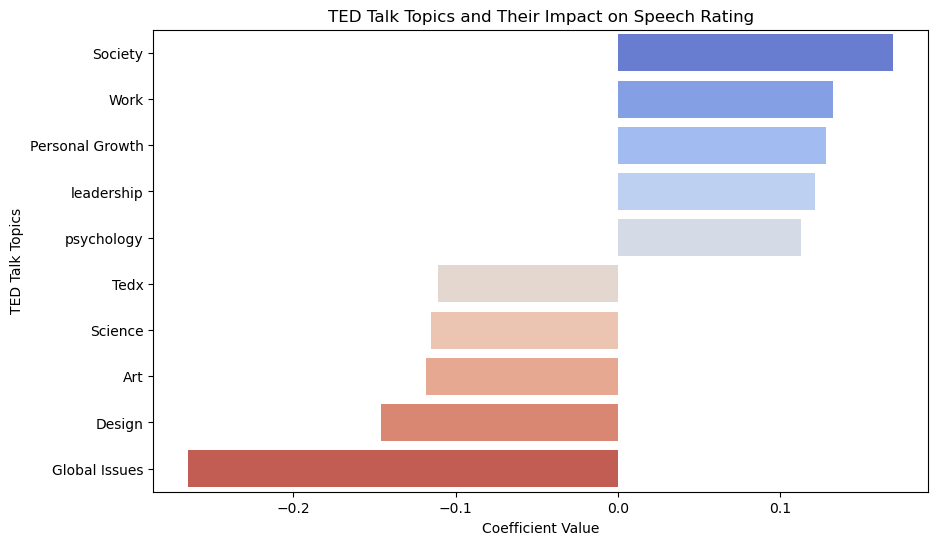

In [157]:
name_mapping = {
    'society': 'Society',
    'personal growth': 'Personal Growth',
    'work': 'Work',
    'social change': 'Social Change',
    'business': 'Business',
    'TEDx': 'Tedx',
    'art': 'Art',
    'science': 'Science',
    'design': 'Design',
    'global issues': 'Global Issues'
}

# Apply the name mapping to the 'Feature' column
coefficients_df['Feature'] = coefficients_df['Feature'].map(name_mapping).fillna(coefficients_df['Feature'])

# Extracting top 5 and bottom 5 coefficients
top_5 = coefficients_df.head(5)
bottom_5 = coefficients_df.tail(5)

# Combining top 5 and bottom 5 for plotting
combined_df = pd.concat([top_5, bottom_5])

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=combined_df, palette="coolwarm")
plt.title('TED Talk Topics and Their Impact on Speech Rating')
plt.xlabel('Coefficient Value')
plt.ylabel('TED Talk Topics')

# Show plot
plt.show()

### Random Forest Classifier on Topics

In [158]:
# Instantiate the Random Forest model
# n_estimators is the number of trees in the forest, max_depth is the maximum depth of the trees
random_forest = RandomForestClassifier(n_estimators=50, max_depth=1, n_jobs=-1, random_state=42)

# Fit the model on the training data
# Note: Random Forest handles the feature importance internally, so scaling is not as critical as in logistic regression
random_forest.fit(X_train, y_train)

# Training and test score
train_score_rf = random_forest.score(X_train, y_train)
test_score_rf = random_forest.score(X_test, y_test)

print(f"Train score: {train_score_rf}")
print(f"Test score: {test_score_rf}")

Train score: 0.6415165165165165
Test score: 0.6036036036036037


What are the features with the highest feature importances (which features were most impactful in the model?)

In [159]:
# Extracting feature importance
feature_importances = random_forest.feature_importances_

# Getting feature names from the CountVectorizer
# This assumes that 'bagofwords_transcript' was used to transform the data fed into the Random Forest
feature_names = X_train.columns

# Check if the length of feature names matches the length of feature importances
if len(feature_names) == len(feature_importances):
    # Create a pandas DataFrame for easier manipulation and visualization
    features_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Sort the DataFrame to show the most important features at the top
    features_df = features_df.sort_values(by='Importance', ascending=False)

    # Display the top N most important features
    print(features_df.head(10))
    print(features_df.tail(10))  
else:
    print("Mismatch in the length of feature names and importances")

             Feature  Importance
59     United States        0.08
223        happiness        0.06
42     South America        0.06
214    global issues        0.06
388          society        0.06
233         humanity        0.04
435              war        0.04
259       leadership        0.04
330  pharmaceuticals        0.04
328  personal growth        0.04
             Feature  Importance
155       depression         0.0
154        democracy         0.0
153             demo         0.0
152     deextinction         0.0
151  decision-making         0.0
150            death         0.0
149             data         0.0
148      dark matter         0.0
147            dance         0.0
448            youth         0.0


## Model 7: using a TF-IDF vectorizer, and then running the Baseline Model with n_grams (2, 6)

Result:


Logistic Regression:
| Metric     | Score       |
|------------|-------------|
| Train      | 0.641517    |
| Test       | 0.603604    |



Random Forest:
| Metric     | Score     |
|------------|-----------|
| Train      | 0.641517  |
| Test       | 0.603604  |



Logistic Regression (top 10 positive coefficients):
| Feature         | Coefficient |
|-----------------|-------------|
| want know       | 0.059278    |
| people say      | 0.047159    |
| know people     | 0.041729    |
| high school     | 0.041639    |
| 30 percent      | 0.040889    |
| dont think      | 0.040353    |
| answer question | 0.039936    |
| felt like       | 0.039829    |
| feels like      | 0.036922    |
| feel like       | 0.036513    |



Logistic Regression (bottom 10 positive coefficients):
| Feature          | Coefficient |
|------------------|-------------|
| middle east      | -0.030106   |
| million people   | -0.030453   |
| billion people   | -0.030873   |
| youre seeing     | -0.035494   |
| 90 percent       | -0.036266   |
| looks like       | -0.036910   |
| ladies gentlemen | -0.043418   |
| weve got         | -0.046576   |
| im going         | -0.047101   |
| people living    | -0.055252   |


Random Forest:
| Feature          | Importance |
|------------------|------------|
| want know        | 0.08       |
| ladies gentlemen | 0.08       |
| im going         | 0.06       |
| thats going      | 0.04       |
| people say       | 0.04       |
| looked like      | 0.04       |
| middle east      | 0.02       |
| going make       | 0.02       |
| youre seeing     | 0.02       |
| just little      | 0.02       |

### Merging into a single dataframe

We will merge the dataframes before our countvectorization process.

Let's first drop all non-numerical columns (other than the columns we will be doing our CountVectorizing on).

In [160]:
# Dropping the non numerical columns
ready_to_merge_numerical_df = merged_cleaved_df.select_dtypes(include=['bool', 'int64', 'float64'])
ready_to_merge_numerical_df.drop(["talk_id"], axis=1, inplace=True) # Dropping the talk_id column
ready_to_merge_numerical_df.drop(["likes"], axis=1, inplace=True) # Dropping the likes column, as it is correlated to our target variable
ready_to_merge_numerical_df['transcript'] = merged_cleaved_df['transcript'] # Adding the transcript column back in

We now have a dataframe to which we can merge the topics and occupations dummy variables.

In [161]:
# Lets check the shape of the topics_df and occupations_df and ready_to_merge_numerical_df
print(topics_df.shape)
print(occupations_df.shape)
print(ready_to_merge_numerical_df.shape)

(3330, 449)
(3330, 1701)
(3330, 76)


In [162]:
# As all three dataframes have the same shape, we'll reset their indexes and merge them together
# Reset the index of each DataFrame to ensure alignment
occupations_df_reset = occupations_df.reset_index(drop=True)
topics_df_reset = topics_df.reset_index(drop=True)
ready_to_merge_numerical_df_reset = ready_to_merge_numerical_df.reset_index(drop=True)

In [163]:
dummy_merged_df = pd.concat([occupations_df_reset, topics_df_reset, ready_to_merge_numerical_df_reset], axis=1)
dummy_merged_df.shape

(3330, 2226)

In [164]:
# creating a new column called 'good_speech' that is 1 if the speech is in the top 50% of percent_likes, and 0 if it is in the bottom 50% of percent_likes

# Calculate the 50th percentile (median) of the 'percent_likes' column
median_percent_likes = dummy_merged_df['percent_likes'].mean()

# Create the 'good_speech' column based on the condition
dummy_merged_df['good_speech'] = (dummy_merged_df['percent_likes'] >= median_percent_likes).astype(int)

# Now, merged_cleaved_df has a new column 'good_speech' with 1s and 0s based on the condition

dummy_merged_df.drop(["percent_likes"], axis=1, inplace=True) # Dropping the percent_likes column

In [165]:
# Scaling the data

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# List of columns to scale
columns_to_scale = ['comments', 'duration', 'word_count', 'words_per_minute', 'num_question_marks', 
                    'questions_per_minute', 'num_laughs', 'laughs_per_minute']

# Scale the selected columns and replace in the dataframe
dummy_merged_df[columns_to_scale] = scaler.fit_transform(dummy_merged_df[columns_to_scale])

In [166]:
X=dummy_merged_df.drop("good_speech", axis=1)
y=dummy_merged_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


In [167]:
# Custom stop words
custom_stop_words = ["laughter", "applause", "laughter applause", "--", "-", "♫ ♫", "♫"]

# Combine custom stop words with default English stop words
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_words))

# Function for the tokenizer
def nltk_tokenizer(text):
    # Remove punctuation
    text_no_punctuation = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenize the text without punctuation
    return word_tokenize(text_no_punctuation)

# Instantiate TfidfVectorizer
tfidf_transcript = TfidfVectorizer(stop_words=stop_words,  # remove stop words
                                   tokenizer=nltk_tokenizer,  # use the NLTK tokenizer
                                   min_df=10,  # minimum document frequency of 10
                                   max_df=0.8,  # maximum document frequency of 80%
                                   ngram_range=(2, 6),  # allowing for bigrams, and trigrams
                                   max_features=300)  # maximum number of features to keep

# Fit the TfidfVectorizer object on the training data
tfidf_transcript.fit(X_train["transcript"])


/Users/drewe/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(max_df=0.8, max_features=300, min_df=10, ngram_range=(2, 6),
                stop_words=['anyway', 'back', 'except', 'mill', 'under', 'had',
                            'wherever', 'either', 'what', 'of', 'well', 'than',
                            'towards', 'not', 'throughout', 'was', 'but',
                            'done', 'there', 'everything', 'describe',
                            'therefore', 'nothing', 'already', 'thereafter',
                            'is', 'no', 'latter', 'beforehand', 'around', ...],
                tokenizer=<function nltk_tokenizer at 0x31944f310>)

In [168]:
# Transform the 'transcript' column of X_train and X_test into TF-IDF vectors
X_train_tfidf = tfidf_transcript.transform(X_train["transcript"])
X_test_tfidf = tfidf_transcript.transform(X_test["transcript"])

### Logistic Regression on  on the TF-IDF Vectorized Transcripts and other dummied and numerical features

In [169]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(C = 0.01, max_iter=1000, n_jobs=-1) 

#Fit the model
logreg.fit(X_train_tfidf, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train_tfidf, y_train)}")
print(f"Test score: {logreg.score(X_test_tfidf, y_test)}")

Train score: 0.6415165165165165
Test score: 0.6036036036036037


What are the features with the highest coefficients (which features were most impactful in the model?)

In [170]:
# Extracting coefficients
coefficients = logreg.coef_[0]

# Getting feature names from the TfidfVectorizer
feature_names = tfidf_transcript.get_feature_names_out()

# Check if the length of feature names matches the length of coefficients
if len(feature_names) == len(coefficients):
    # Create a pandas DataFrame for easier manipulation
    coefficients_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    # Sort the DataFrame to show features with the highest coefficient values at the top
    coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

    # Display the top N most impactful features
    print(coefficients_df.head(10)) 
    print(coefficients_df.tail(10))
else:
    print("Mismatch in the length of feature names and coefficients")

             Feature  Coefficient
251        want know     0.059278
177       people say     0.047159
117      know people     0.041729
82       high school     0.041639
11        30 percent     0.040889
61        dont think     0.040353
20   answer question     0.039936
68         felt like     0.039829
67        feels like     0.036922
66         feel like     0.036513
              Feature  Coefficient
150       middle east    -0.030106
152    million people    -0.030453
27     billion people    -0.030873
276      youre seeing    -0.035494
19         90 percent    -0.036266
140        looks like    -0.036910
122  ladies gentlemen    -0.043418
259          weve got    -0.046576
89           im going    -0.047101
172     people living    -0.055252


### Random Forest Classifier on the TF-IDF Vectorized Transcripts and other dummied and numerical features

In [171]:
# Instantiate the Random Forest model
# n_estimators is the number of trees in the forest, max_depth is the maximum depth of the trees
random_forest = RandomForestClassifier(n_estimators=50, max_depth=1, n_jobs=-1, random_state=42)

# Fit the model on the training data
# Note: Random Forest handles the feature importance internally, so scaling is not as critical as in logistic regression
random_forest.fit(X_train_tfidf, y_train)

# Training and test score
train_score_rf = random_forest.score(X_train_tfidf, y_train)
test_score_rf = random_forest.score(X_test_tfidf, y_test)

print(f"Train score: {train_score_rf}")
print(f"Test score: {test_score_rf}")

Train score: 0.6415165165165165
Test score: 0.6036036036036037


What are the features with the highest feature importances (which features were most impactful in the model?)

In [172]:
# Extracting feature importance
feature_importances = random_forest.feature_importances_

# Getting feature names from the CountVectorizer
# This assumes that 'bagofwords_transcript' was used to transform the data fed into the Random Forest
feature_names = bagofwords_transcript.get_feature_names_out()

# Check if the length of feature names matches the length of feature importances
if len(feature_names) == len(feature_importances):
    # Create a pandas DataFrame for easier manipulation and visualization
    features_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Sort the DataFrame to show the most important features at the top
    features_df = features_df.sort_values(by='Importance', ascending=False)

    # Display the top N most important features
    print(features_df.head(10))
else:
    print("Mismatch in the length of feature names and importances")

              Feature  Importance
251         want make        0.08
122  ladies gentlemen        0.08
89           im going        0.06
221        thats good        0.04
177        people say        0.04
139       looked like        0.04
150       middle east        0.02
71         going make        0.02
276    youre thinking        0.02
106       just little        0.02


## Model 8: Changing our threshold of "Great Speech" to include the top 75% of Speeches, Then running the Baseline Model with n_grams (2, 6)

Result:

Note that while these train and test scores appear higher, we had made our top 80% of speeches our target variable, and then upsampled our 'poor' speeches.  So this result is still not better than guessing.

Logistic Regression:
| Metric     | Score       |
|------------|-------------|
| Train      | 0.802553    |
| Test       | 0.798799    |




Random Forest:
| Metric      | Score           |
|-------------|-----------------|
| Train Score | 0.800676        |
| Test Score  | 0.797297        |


Logistic Regression (top 10 positive coefficients):
| Feature          | Coefficient |
|------------------|-------------|
| dont think       | 0.187375    |
| want know        | 0.170122    |
| group people     | 0.138306    |
| feels like       | 0.131706    |
| social media     | 0.119828    |
| thats good       | 0.116094    |
| answer question  | 0.111771    |
| years later      | 0.108333    |
| things like      | 0.106024    |
| high school      | 0.093968    |



Logistic Regression (bottom 10 positive coefficients):
| Feature              | Coefficient |
|----------------------|-------------|
| — way                | -0.087560   |
| developing countries | -0.090437   |
| thats going          | -0.094316   |
| ladies gentlemen     | -0.094823   |
| tell stories         | -0.096821   |
| best way             | -0.101720   |
| 30 years             | -0.107771   |
| want talk            | -0.111734   |
| just want            | -0.124688   |
| create new           | -0.139443   |


Random Forest:
| Feature           | Importance |
|-------------------|------------|
| want know         | 0.08       |
| create new        | 0.06       |
| billion dollars   | 0.06       |
| going make        | 0.06       |
| looked like       | 0.04       |
| 30 years          | 0.04       |
| middle east       | 0.04       |
| ladies gentlemen  | 0.04       |
| just want         | 0.02       |
| im going          | 0.02       |


I will take the following steps:

- add back in the column of "Percent likes", 
- change what a "Good_Speech" is to include the top 75% of speeches.  
- upscale the "good_speech" = 0 rows so that there is a 50% distribution between the two.
- run the baseline model again.

In [173]:
# Adding back in the "Percent Likes" column
# Dropping the non numerical columns
ready_to_merge_numerical_df = merged_cleaved_df.select_dtypes(include=['bool', 'int64', 'float64'])
ready_to_merge_numerical_df.drop(["talk_id"], axis=1, inplace=True) # Dropping the talk_id column
ready_to_merge_numerical_df.drop(["likes"], axis=1, inplace=True) # Dropping the likes column, as it is correlated to our target variable
ready_to_merge_numerical_df['transcript'] = merged_cleaved_df['transcript'] # Adding the transcript column back in
ready_to_merge_numerical_df.info()
print(ready_to_merge_numerical_df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 3330 entries, 0 to 3993
Data columns (total 76 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   comments              3330 non-null   float64
 1   duration              3330 non-null   int64  
 2   view                  3330 non-null   int64  
 3   multiple_speakers     3330 non-null   int64  
 4   percent_likes         3330 non-null   float64
 5   ted_mainstage         3330 non-null   int64  
 6   word_count            3330 non-null   int64  
 7   words_per_minute      3330 non-null   float64
 8   num_question_marks    3330 non-null   int64  
 9   questions_per_minute  3330 non-null   float64
 10  num_laughs            3330 non-null   int64  
 11  laughs_per_minute     3330 non-null   float64
 12  published_year_2006   3330 non-null   bool   
 13  published_year_2007   3330 non-null   bool   
 14  published_year_2008   3330 non-null   bool   
 15  published_year_2009   3330

We now have a dataframe to which we can merge the topics and occupations dummy variables.

In [174]:
# Lets check the shape of the topics_df and occupations_df and ready_to_merge_numerical_df
print(topics_df.shape)
print(occupations_df.shape)
print(ready_to_merge_numerical_df.shape)

(3330, 449)
(3330, 1701)
(3330, 76)


In [175]:
# As all three dataframes have the same shape, we'll reset their indexes and merge them together
# Reset the index of each DataFrame to ensure alignment
occupations_df_reset = occupations_df.reset_index(drop=True)
topics_df_reset = topics_df.reset_index(drop=True)
ready_to_merge_numerical_df_reset = ready_to_merge_numerical_df.reset_index(drop=True)

In [176]:
dummy_merged_df = pd.concat([occupations_df_reset, topics_df_reset, ready_to_merge_numerical_df_reset], axis=1)
dummy_merged_df.shape

(3330, 2226)

### Setting what a "good_speech" is to be the top 80% of speeches.

Let's first look at the "percent_likes" column to show where we're drawing the line.

/var/folders/l2/d5ln4l29453322fq40g1dz2h0000gn/T/ipykernel_1369/1928000241.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(dummy_merged_df['percent_likes'], kde=False, palette='coolwarm', bins=30)


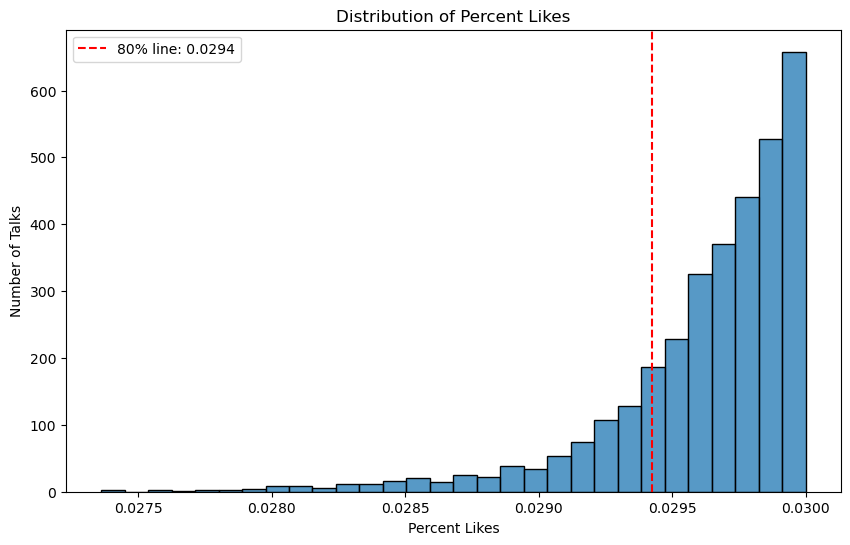

In [177]:
# Plotting the distribution
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
sns.histplot(dummy_merged_df['percent_likes'], kde=False, palette='coolwarm', bins=30)
# 'kde=False' turns off the Kernel Density Estimate plot overlay
# 'bins=30' specifies how many bins you want to divide your data into
# 'color' specifies the color of the histogram

# Calculating and plotting the mean
new_value = dummy_merged_df['percent_likes'].quantile(0.20)
plt.axvline(new_value, color='red', linestyle='--', label=f'80% line: {new_value:.4f}')
# This draws a vertical line at the mean value, '--' makes the line dashed, and ':.2f' formats the mean to 2 decimal places

plt.xlabel('Percent Likes')  # Label for the x-axis
plt.ylabel('Number of Talks')  # Label for the y-axis
plt.title('Distribution of Percent Likes')  # Title of the plot
plt.legend()  # Show the legend
plt.show()


We're first going to create a binary "good_speech" column that represents of the 80% of speeches that have the highest ratings.  We are indicating that speeches that recieved an above the 0.20 quantile "percent_likes" are counted as "good_speech", and those that were below the "percent_likes" 0.20 quantile are not.

In [178]:
# change what a "Good_Speech" is to include the top 80% of speeches

# Calculate the 80th percentile of the 'percent_likes' column
percentile_80 = dummy_merged_df['percent_likes'].quantile(0.20)

# Create the 'good_speech' column based on the condition
dummy_merged_df['good_speech'] = (dummy_merged_df['percent_likes'] >= percentile_80).astype(int)

# Now, dummy_merged_df has a new column 'good_speech' with 1s for the top 80% of speeches based on percent_likes and 0s otherwise

In [179]:
print(dummy_merged_df['good_speech'].value_counts(normalize=True))  # Display the normalized value counts
print(dummy_merged_df['good_speech'].value_counts())

good_speech
1    0.8
0    0.2
Name: proportion, dtype: float64
good_speech
1    2664
0     666
Name: count, dtype: int64


In [180]:
 # verrifying that the 'good_speech' column has been created correctly
# Group the dataframe by the 'good_speech' column and calculate the mean of 'percent_likes' for each group
average_percent_likes = dummy_merged_df.groupby('good_speech')['percent_likes'].mean()

# Print the average 'percent_likes' for each group
print(average_percent_likes)


good_speech
0    0.029035
1    0.029772
Name: percent_likes, dtype: float64


In [181]:
# dropping the 'percent_likes' column

dummy_merged_df.drop(["percent_likes"], axis=1, inplace=True) # Dropping the percent_likes column

In [182]:
# upsampling the "good_speech" = 0 rows so that there is a 50% distribution between the two

# First, determine the number of instances where good_speech = 0
n_good_speech = dummy_merged_df[dummy_merged_df['good_speech'] == 1].shape[0]

# Separate the dataframe into two based on 'good_speech' value
df_majority = dummy_merged_df[dummy_merged_df['good_speech'] == 1]
df_minority = dummy_merged_df[dummy_merged_df['good_speech'] == 0]

# Upsample the minority class (now good_speech = 1)
df_minority_upsampled = resample(df_minority, 
                                 replace=True,      # sample with replacement
                                 n_samples=n_good_speech,    # to match majority class size
                                 random_state=123)  # reproducible results

# Combine the upsampled minority class with the original majority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Check the new counts for each value of 'good_speech'
print(df_upsampled['good_speech'].value_counts())



good_speech
1    2664
0    2664
Name: count, dtype: int64


In [183]:
df_upsampled.shape

(5328, 2226)

We have upsampled the minority class significantly.  This will result in an OVER-representation of those rows that were below the 0.20 quantile.

In [184]:
# Scaling the data

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# List of columns to scale
columns_to_scale = ['comments', 'duration', 'word_count', 'words_per_minute', 'num_question_marks', 
                    'questions_per_minute', 'num_laughs', 'laughs_per_minute']

# Scale the selected columns and replace in the dataframe
dummy_merged_df[columns_to_scale] = scaler.fit_transform(dummy_merged_df[columns_to_scale])

In [185]:
# Re-running the baseline model

# run the baseline model again
X=dummy_merged_df.drop("good_speech", axis=1)
y=dummy_merged_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


In [186]:
# CountVectorizing the 'transcript' column
# Custom stop words
custom_stop_words = ["laughter", "applause", "laughter applause", "--", "-", "♫ ♫", "♫"]

# Combine custom stop words with default English stop words
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_words))

# As tokenizers must be functions, we will define a function for the tokenizer we will use
def nltk_tokenizer(text):
    # Remove punctuation using a list comprehension
    text_no_punctuation = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenize the text without punctuation
    return word_tokenize(text_no_punctuation)

# instantiate CountVectorizer
bagofwords_transcript = CountVectorizer(stop_words=stop_words, # remove stop words
                                        tokenizer=nltk_tokenizer, # use the NLTK tokenizer
                                        min_df=10, # minimum document frequency of 10
                                        max_df=0.8, # maximum document frequency of 75% (i.e., ignore words that appear in more than 75% of the documents)
                                        ngram_range=(2, 6), # allowing for bigrams, and trigrams
                                        max_features=300) # maximum number of features to keep

# Fit the CountVectorizer object on the positive (and, separately, negative) reviews
bagofwords_transcript.fit(X_train["transcript"])
print(bagofwords_transcript.fit(X_train["transcript"]))

/Users/drewe/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(max_df=0.8, max_features=300, min_df=10, ngram_range=(2, 6),
                stop_words=['anyway', 'back', 'except', 'mill', 'under', 'had',
                            'wherever', 'either', 'what', 'of', 'well', 'than',
                            'towards', 'not', 'throughout', 'was', 'but',
                            'done', 'there', 'everything', 'describe',
                            'therefore', 'nothing', 'already', 'thereafter',
                            'is', 'no', 'latter', 'beforehand', 'around', ...],
                tokenizer=<function nltk_tokenizer at 0x2c683cc10>)


In [187]:
sparse_matrix_train = bagofwords_transcript.transform(X_train["transcript"])
sparse_matrix_test = bagofwords_transcript.transform(X_test["transcript"])

### Logistic Regression on n_grams (2, 6)

I am re-running our Baseline model to see what the effect of increasing our threshold for "good_speech" to the top 80% of the rated speeches is (and then upsampling the minority class).

In [188]:
# Instantiate the Logistic Regression model with the current C value
logreg = LogisticRegression(C=0.01, max_iter=1000, n_jobs=-1)

# Fit the model to the training data
logreg.fit(sparse_matrix_train, y_train)

# Calculate and print the training and test scores
train_score = logreg.score(sparse_matrix_train, y_train)
test_score = logreg.score(sparse_matrix_test, y_test)
print(f"Train score: {train_score}, Test score: {test_score}")


Train score: 0.8025525525525525, Test score: 0.7987987987987988


What are the features with the highest coefficients (which features were most impactful in the model?)

In [189]:
# Extracting coefficients
coefficients = logreg.coef_[0]  # For logistic regression, `coef_` returns an array in shape (n_classes, n_features)

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame to show features with the highest absolute coefficient values at the top
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Display the top N most impactful features
print(coefficients_df.head(10))
print(coefficients_df.tail(10))


             Feature  Coefficient
61        dont think     0.187375
251        want know     0.170122
77      group people     0.138306
67        feels like     0.131706
208     social media     0.119828
222       thats good     0.116094
20   answer question     0.111771
268      years later     0.108333
235      things like     0.106024
82       high school     0.093968
                  Feature  Coefficient
296                 — way    -0.087560
41   developing countries    -0.090437
221           thats going    -0.094316
122      ladies gentlemen    -0.094823
215          tell stories    -0.096821
25               best way    -0.101720
12               30 years    -0.107771
255             want talk    -0.111734
109             just want    -0.124688
40             create new    -0.139443


### Random Forest Classifier Model on n_grams (2, 6)

In [190]:
# Instantiate the Random Forest model with the current values of n_estimators and max_depth
random_forest = RandomForestClassifier(n_estimators=50, max_depth=1, n_jobs=-1, random_state=42)

# Fit the model to the training data
random_forest.fit(sparse_matrix_train, y_train)

# Calculate and print the training and test scores
train_score_rf = random_forest.score(sparse_matrix_train, y_train)
test_score_rf = random_forest.score(sparse_matrix_test, y_test)
print(f"Train score: {train_score_rf}, Test score: {test_score_rf}")


Train score: 0.8006756756756757, Test score: 0.7972972972972973


What are the features with the highest feature importances (which features were most impactful in the model?)

In [191]:
# Extracting feature importance
feature_importances = random_forest.feature_importances_

# Getting feature names from the CountVectorizer
feature_names = bagofwords_transcript.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation and visualization
import pandas as pd

features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
print(features_df.head(10))


              Feature  Importance
251         want know        0.08
40         create new        0.06
26    billion dollars        0.06
71         going make        0.06
139       looked like        0.04
12           30 years        0.04
150       middle east        0.04
122  ladies gentlemen        0.04
109         just want        0.02
89           im going        0.02


## Model 9. Using BERT on the Speech Transcripts

Result:
Logistic Regression:
| Metric      | Score               |
|-------------|---------------------|
| Train Score | 0.641517            |
| Test Score  | 0.603604            |


Random Forest:
| Metric      | Score               |
|-------------|---------------------|
| Train Score | 0.642643            |
| Test Score  | 0.603604            |


In [192]:
# creating a new column called 'good_speech' that is 1 if the speech is in the top 50% of percent_likes, and 0 if it is in the bottom 50% of percent_likes

# Calculate the 50th percentile (median) of the 'percent_likes' column
median_percent_likes = ready_to_merge_numerical_df['percent_likes'].mean()

# Create the 'good_speech' column based on the condition
ready_to_merge_numerical_df['good_speech'] = (ready_to_merge_numerical_df['percent_likes'] >= median_percent_likes).astype(int)

# Now, merged_cleaved_df has a new column 'good_speech' with 1s and 0s based on the condition

ready_to_merge_numerical_df.drop(["percent_likes"], axis=1, inplace=True) # Dropping the percent_likes column

In [193]:
# Scaling the data

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# List of columns to scale
columns_to_scale = ['comments', 'duration', 'word_count', 'words_per_minute', 'num_question_marks', 
                    'questions_per_minute', 'num_laughs', 'laughs_per_minute']

# Scale the selected columns and replace in the dataframe
ready_to_merge_numerical_df[columns_to_scale] = scaler.fit_transform(ready_to_merge_numerical_df[columns_to_scale])

In [194]:
ready_to_merge_numerical_df.columns

Index(['comments', 'duration', 'view', 'multiple_speakers', 'ted_mainstage',
       'word_count', 'words_per_minute', 'num_question_marks',
       'questions_per_minute', 'num_laughs', 'laughs_per_minute',
       'published_year_2006', 'published_year_2007', 'published_year_2008',
       'published_year_2009', 'published_year_2010', 'published_year_2011',
       'published_year_2012', 'published_year_2013', 'published_year_2014',
       'published_year_2015', 'published_year_2016', 'published_year_2017',
       'published_year_2018', 'published_year_2019', 'published_year_2020',
       'published_month_1', 'published_month_2', 'published_month_3',
       'published_month_4', 'published_month_5', 'published_month_6',
       'published_month_7', 'published_month_8', 'published_month_9',
       'published_month_10', 'published_month_11', 'published_month_12',
       'recorded_year_1984', 'recorded_year_1990', 'recorded_year_1994',
       'recorded_year_1998', 'recorded_year_2001', 'record

#### I will hash-out this code for the time being as it is too taxing to run in my local environment.

In [195]:
# X=ready_to_merge_numerical_df.drop("good_speech", axis=1)
# y=ready_to_merge_numerical_df["good_speech"]

# # train/test split should be conducted before Vectorization
# X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


In [196]:
# # Initialize the tokenizer and model from pre-trained BERT model
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')

# # Function to encode the text data to BERT-compatible format
# def encode_texts(texts):
#     return tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors="pt")

# # Encode the training and testing data
# X_train_encoded = encode_texts(X_train["transcript"].tolist())
# X_test_encoded = encode_texts(X_test["transcript"].tolist())

# # Since BERT outputs a lot of features (last hidden state, pooler output, hidden states, attentions),
# # we typically use the pooler output as a representation of the entire input sequence
# # Here's how to get it
# with torch.no_grad():
#     outputs_train = model(**X_train_encoded)
#     outputs_test = model(**X_test_encoded)
#     pooled_output_train = outputs_train.pooler_output
#     pooled_output_test = outputs_test.pooler_output


### Logistic Regression on BERT Transcript Features

In [197]:
# from sklearn.linear_model import LogisticRegression
# import numpy as np

# # Since pooled_output_train/test is a tensor, convert it to a numpy array
# X_train_bert = pooled_output_train.numpy()
# X_test_bert = pooled_output_test.numpy()

# # Instantiate the Logistic Regression model
# # Note: n_jobs=-1 might not be beneficial here due to the overhead of distributing small tasks across multiple cores. Consider removing it or testing to see if it improves performance.
# logreg_bert = LogisticRegression(C=0.001, max_iter=1000)

# # Fit the model on the BERT features
# logreg_bert.fit(X_train_bert, y_train)

# # Training and test score
# train_score_bert = logreg_bert.score(X_train_bert, y_train)
# test_score_bert = logreg_bert.score(X_test_bert, y_test)

# print(f"Train score: {train_score_bert}")
# print(f"Test score: {test_score_bert}")


### Random Forest Classifier Model on BERT Transcript Features

In [198]:
# # Instantiate the Random Forest model
# # n_estimators is the number of trees in the forest, max_depth is the maximum depth of the trees
# random_forest = RandomForestClassifier(n_estimators=50, max_depth=1, n_jobs=-1, random_state=42)

# # Fit the model on the training data
# # Note: Random Forest handles the feature importance internally, so scaling is not as critical as in logistic regression
# random_forest.fit(X_train_bert, y_train)

# # Training and test score
# train_score_rf = random_forest.score(X_train_bert, y_train)
# test_score_rf = random_forest.score(X_test_bert, y_test)

# print(f"Train score: {train_score_rf}")
# print(f"Test score: {test_score_rf}")

## Model 10. Linear Regression on Various Numerical Features

Result (non-upsampled data):
| Metric   | Score                |
|----------|----------------------|
| R^2 Score| 0.014771095979134174 |
 
| Feature               | Coefficient |
|-----------------------|-------------|
| laughs_per_minute     | 0.171444    |
| num_question_marks    | 0.134655    |
| word_count            | 0.053391    |
| ted_mainstage         | 0.009538    |
| duration              | -0.029602   |
| words_per_minute      | -0.035292   |
| questions_per_minute  | -0.044329   |
| multiple_speakers     | -0.047649   |
| num_laughs            | -0.100675   |


Result (upsampled data):
| Metric   | Score                |
|----------|----------------------|
| R^2 Score| 0.014771095979134397 |

| Feature               | Coefficient |
|-----------------------|-------------|
| laughs_per_minute     | 0.171444    |
| num_question_marks    | 0.134655    |
| word_count            | 0.053391    |
| ted_mainstage         | 0.009538    |
| duration              | -0.029602   |
| words_per_minute      | -0.035292   |
| questions_per_minute  | -0.044329   |
| multiple_speakers     | -0.047649   |
| num_laughs            | -0.100675   |

In [199]:
# Dropping the non numerical columns
ready_to_merge_numerical_df = merged_cleaved_df.select_dtypes(include=['int64', 'float64'])
ready_to_merge_numerical_df.drop(["talk_id"], axis=1, inplace=True) # Dropping the talk_id column
ready_to_merge_numerical_df.drop(["likes"], axis=1, inplace=True) # Dropping the likes column
ready_to_merge_numerical_df['percent_likes'] = merged_cleaved_df['percent_likes'] # Adding the percent_likes column back in
ready_to_merge_numerical_df.drop(["view"], axis=1, inplace=True) # Dropping the view column
ready_to_merge_numerical_df.drop(["comments"], axis=1, inplace=True) # Dropping the comments column
ready_to_merge_numerical_df.info()
print(ready_to_merge_numerical_df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 3330 entries, 0 to 3993
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   duration              3330 non-null   int64  
 1   multiple_speakers     3330 non-null   int64  
 2   percent_likes         3330 non-null   float64
 3   ted_mainstage         3330 non-null   int64  
 4   word_count            3330 non-null   int64  
 5   words_per_minute      3330 non-null   float64
 6   num_question_marks    3330 non-null   int64  
 7   questions_per_minute  3330 non-null   float64
 8   num_laughs            3330 non-null   int64  
 9   laughs_per_minute     3330 non-null   float64
dtypes: float64(4), int64(6)
memory usage: 286.2 KB
(3330, 10)


In [200]:
ready_to_merge_numerical_df.columns

Index(['duration', 'multiple_speakers', 'percent_likes', 'ted_mainstage',
       'word_count', 'words_per_minute', 'num_question_marks',
       'questions_per_minute', 'num_laughs', 'laughs_per_minute'],
      dtype='object')

In [201]:
# Scaling the data

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# List of columns to scale
columns_to_scale = ['duration', 'word_count', 'words_per_minute', 'num_question_marks', 
                    'questions_per_minute', 'num_laughs', 'laughs_per_minute', 'percent_likes'] # 'comments', 

# Scale the selected columns and replace in the dataframe
ready_to_merge_numerical_df[columns_to_scale] = scaler.fit_transform(ready_to_merge_numerical_df[columns_to_scale])

In [202]:
# Dropping the 'transcript' column

# Selecting the independent and dependent variables
X = ready_to_merge_numerical_df.drop('percent_likes', axis=1)
y = ready_to_merge_numerical_df['percent_likes']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating the regression model
model = LinearRegression()

# Fitting the model
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
print("R^2 Score:", r2_score(y_test, y_pred))

# Displaying the coefficients
coefficients = pd.DataFrame(model.coef_, X_train.columns, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)
print(coefficients)


R^2 Score: 0.014771095979134174
                      Coefficient
laughs_per_minute        0.171444
num_question_marks       0.134655
word_count               0.053391
ted_mainstage            0.009538
duration                -0.029602
words_per_minute        -0.035292
questions_per_minute    -0.044329
multiple_speakers       -0.047649
num_laughs              -0.100675


## Attempting another linear regression with upsampled data:

I'm trying this to see if upsampling the speeches that are below the 0.20 quantile has any effect on the coefficients.

In [203]:
# change what a "Good_Speech" is to include the top 80% of speeches

# Calculate the 80th percentile of the 'percent_likes' column
percentile_80 = ready_to_merge_numerical_df['percent_likes'].quantile(0.20)

# Create the 'good_speech' column based on the condition
ready_to_merge_numerical_df['good_speech'] = (ready_to_merge_numerical_df['percent_likes'] >= percentile_80).astype(int)

# Now, dummy_merged_df has a new column 'good_speech' with 1s for the top 80% of speeches based on percent_likes and 0s otherwise

In [204]:
print(ready_to_merge_numerical_df['good_speech'].value_counts(normalize=True))  # Display the normalized value counts
print(ready_to_merge_numerical_df['good_speech'].value_counts())

good_speech
1    0.8
0    0.2
Name: proportion, dtype: float64
good_speech
1    2664
0     666
Name: count, dtype: int64


In [205]:
 # verrifying that the 'good_speech' column has been created correctly
# Group the dataframe by the 'good_speech' column and calculate the mean of 'percent_likes' for each group
average_percent_likes = ready_to_merge_numerical_df.groupby('good_speech')['percent_likes'].mean()

# Print the average 'percent_likes' for each group
print(average_percent_likes)


good_speech
0    0.634378
1    0.913701
Name: percent_likes, dtype: float64


In [206]:
# upsampling the "good_speech" = 0 rows so that there is a 50% distribution between the two

# First, determine the number of instances where good_speech = 0
n_good_speech = ready_to_merge_numerical_df[ready_to_merge_numerical_df['good_speech'] == 1].shape[0]

# Separate the dataframe into two based on 'good_speech' value
df_majority = ready_to_merge_numerical_df[ready_to_merge_numerical_df['good_speech'] == 1]
df_minority = ready_to_merge_numerical_df[ready_to_merge_numerical_df['good_speech'] == 0]

# Upsample the minority class (now good_speech = 1)
df_minority_upsampled = resample(df_minority, 
                                 replace=True,      # sample with replacement
                                 n_samples=n_good_speech,    # to match majority class size
                                 random_state=123)  # reproducible results

# Combine the upsampled minority class with the original majority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Check the new counts for each value of 'good_speech'
print(df_upsampled['good_speech'].value_counts())



good_speech
1    2664
0    2664
Name: count, dtype: int64


In [207]:
# dropping the 'good_speech' column

ready_to_merge_numerical_df.drop(["good_speech"], axis=1, inplace=True) # Dropping the percent_likes column

In [208]:
ready_to_merge_numerical_df.columns

Index(['duration', 'multiple_speakers', 'percent_likes', 'ted_mainstage',
       'word_count', 'words_per_minute', 'num_question_marks',
       'questions_per_minute', 'num_laughs', 'laughs_per_minute'],
      dtype='object')

In [209]:
# Scaling the data

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# List of columns to scale
columns_to_scale = ['duration', 'word_count', 'words_per_minute', 'num_question_marks', 
                    'questions_per_minute', 'num_laughs', 'laughs_per_minute', 'percent_likes'] # 'comments', 

# Scale the selected columns and replace in the dataframe
ready_to_merge_numerical_df[columns_to_scale] = scaler.fit_transform(ready_to_merge_numerical_df[columns_to_scale])

In [210]:
# Dropping the 'transcript' column

# Selecting the independent and dependent variables
X = ready_to_merge_numerical_df.drop('percent_likes', axis=1)
y = ready_to_merge_numerical_df['percent_likes']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating the regression model
model = LinearRegression()

# Fitting the model
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
print("R^2 Score:", r2_score(y_test, y_pred))

# Displaying the coefficients
coefficients = pd.DataFrame(model.coef_, X_train.columns, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)
print(coefficients)


R^2 Score: 0.014771095979134397
                      Coefficient
laughs_per_minute        0.171444
num_question_marks       0.134655
word_count               0.053391
ted_mainstage            0.009538
duration                -0.029602
words_per_minute        -0.035292
questions_per_minute    -0.044329
multiple_speakers       -0.047649
num_laughs              -0.100675


# 7. Various Investigative Tests:

1. Speech Title: Word Count: Is there any relationship between percent likes and the word count of a speech's title?
2. Speech Title: Title Content (n_gram=1,4): Is there any relationship between the contents of a speech's title, and it being in the top 50% of ratings for all speeches?
3. Speech Title: Title Content (n_gram=2,4): Is there any relationship between the contents of a speech's title, and it being in the top 50% of ratings for all speeches?
4. Ted MainStage Impact
5. Various Visualizations & Correlations 

##  1. Speech Title: The length (word count) of a speech title and it's rating?

### Result:
| Metric           | Value                  |
|------------------|------------------------|
| R^2 Score        | 0.016216526461689917   |

Coefficient Score:
| Feature          | Coefficient            |
|------------------|------------------------|
| title_word_count | 0.087785               |


The length of a speech's title does not appear to have much effect on how well that speech is "liked".

In [211]:
# Get the word count of a speeches title
merged_cleaved_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3330 entries, 0 to 3993
Data columns (total 87 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   talk_id                       3330 non-null   int64         
 1   title                         3330 non-null   object        
 2   occupations                   3330 non-null   object        
 3   recorded_date                 3330 non-null   datetime64[ns]
 4   published_date                3330 non-null   datetime64[ns]
 5   event                         3330 non-null   object        
 6   comments                      3330 non-null   float64       
 7   duration                      3330 non-null   int64         
 8   topics                        3330 non-null   object        
 9   transcript                    3330 non-null   object        
 10  view                          3330 non-null   int64         
 11  likes                         3330 

In [212]:
# Lets create another column that counts the number of words in the transcript.
# A function that counts words in a string
def count_words(text):
    # Splitting the text into words and count them
    return len(text.split())

# Apply this function to each row in the 'transcript' column and create a new column
merged_cleaved_df['title_word_count'] = merged_cleaved_df['title'].apply(count_words)


In [213]:
# here we'll create a "percent_likes" column, which is the percentage of likes out of the total views
merged_cleaved_df['percent_likes'] = merged_cleaved_df['likes'] / merged_cleaved_df['view']

#### Sidebar: Optimal Number of Words in the Title:

In [214]:
# Group by 'title_word_count', calculate the mean of 'percent_likes' for each group
average_likes_by_word_count = merged_cleaved_df.groupby('title_word_count')['percent_likes'].mean()

# Find the word count with the highest average percent_likes
optimal_word_count = average_likes_by_word_count.idxmax()
highest_percent_likes = average_likes_by_word_count.max()

# Display the results
print(f"Optimal number of words in title: {optimal_word_count}")
print(f"Highest average percent_likes: {highest_percent_likes}")


Optimal number of words in title: 13
Highest average percent_likes: 0.02974387080319322


#### End of Sidebar: Back to the Linear Regression

In [215]:
# Scaling the data

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# List of columns to scale
columns_to_scale = ['percent_likes', 'title_word_count']

# Scale the selected columns and replace in the dataframe
merged_cleaved_df[columns_to_scale] = scaler.fit_transform(merged_cleaved_df[columns_to_scale])

In [216]:
# Run a linear regression to predict the percent_likes of a speech based on the word count of the title
# Dropping the 'transcript' column

# Selecting the independent and dependent variables
X = merged_cleaved_df['title_word_count'].values.reshape(-1, 1)
y = merged_cleaved_df['percent_likes']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating the regression model
model = LinearRegression()

# Fitting the model
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
print("R^2 Score:", r2_score(y_test, y_pred))

# Displaying the coefficients - fix applied here
coefficients = pd.DataFrame(model.coef_, ['title_word_count'], columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)
print(coefficients)



R^2 Score: 0.016216526461689917
                  Coefficient
title_word_count     0.087785


## 2. Speech Title: Title on Rating (n_grams 1, 4): Is there any relationship between the contents of a speech's title, and it being in the top 50% of ratings for all speeches? 

### Result:

Logistic Regression:
| Metric      | Score     |
|-------------|-----------|
| Train Score | 0.641517  |
| Test Score  | 0.603604  |

Random Forest:
| Metric      | Score     |
|-------------|-----------|
| Train Score | 0.641517  |
| Test Score  | 0.603604  |



Logistic regression (top 10 positive coefficients):
| Feature | Coefficient |
|---------|-------------|
| teach   | 0.059401    |
| build   | 0.053227    |
| future  | 0.051909    |
| learned | 0.049527    |
| love    | 0.048637    |
| better  | 0.047232    |
| 3       | 0.045885    |
| power   | 0.040386    |
| work    | 0.039140    |
| tell    | 0.038766    |

Logistic regression (top 10 negative coefficients):
| Feature | Coefficient |
|---------|-------------|
| making  | -0.035987   |
| lives   | -0.036566   |
| women   | -0.037411   |
| ocean   | -0.038510   |
| science | -0.039195   |
| new     | -0.041241   |
| cancer  | -0.042177   |
| music   | -0.050583   |
| art     | -0.061308   |
| global  | -0.065322   |


Random Forest Feature Importances:
| Feature | Importance |
|---------|------------|
| 3       | 0.06       |
| teach   | 0.06       |
| doctors | 0.04       |
| does    | 0.04       |
| world   | 0.04       |
| ocean   | 0.04       |
| idea    | 0.04       |
| history | 0.02       |
| end     | 0.02       |
| solve   | 0.02       |


In [217]:
# Creating a Transcript Only Dataframe
only_title_df = merged_cleaved_df[['percent_likes', 'title']]

In [218]:
# creating a new column called 'good_speech' that is 1 if the speech is in the top 50% of percent_likes, and 0 if it is in the bottom 50% of percent_likes

# Calculate the 50th percentile (median) of the 'percent_likes' column
median_percent_likes = only_title_df['percent_likes'].mean()

# Create the 'good_speech' column based on the condition
only_title_df['good_speech'] = (only_title_df['percent_likes'] >= median_percent_likes).astype(int)

# Now, merged_cleaved_df has a new column 'good_speech' with 1s and 0s based on the condition

only_title_df.drop(["percent_likes"], axis=1, inplace=True) # Dropping the percent_likes column

/var/folders/l2/d5ln4l29453322fq40g1dz2h0000gn/T/ipykernel_1369/939746040.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_title_df['good_speech'] = (only_title_df['percent_likes'] >= median_percent_likes).astype(int)
/var/folders/l2/d5ln4l29453322fq40g1dz2h0000gn/T/ipykernel_1369/939746040.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_title_df.drop(["percent_likes"], axis=1, inplace=True) # Dropping the percent_likes column


In [219]:
only_title_df.shape

(3330, 2)

### Max Features 500, n_gram 1, 4:

In [220]:
X=only_title_df.drop("good_speech", axis=1)
y=only_title_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


In [221]:
## CountVectorizing the 'trantitlescript' column
# Custom stop words
custom_stop_words = ["laughter", "applause", "laughter applause", "--", "-", "♫ ♫"]

# Combine custom stop words with default English stop words
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_words))

# As tokenizers must be functions, we will define a function for the tokenizer we will use
def nltk_tokenizer(text):
    # Remove punctuation using a list comprehension
    text_no_punctuation = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenize the text without punctuation
    return word_tokenize(text_no_punctuation)

# instantiate CountVectorizer
bagofwords_title = CountVectorizer(stop_words=stop_words, # remove stop words
                                        tokenizer=nltk_tokenizer, # use the NLTK tokenizer
                                        min_df=10, # minimum document frequency of 10
                                        max_df=0.75, # maximum document frequency of 75% (i.e., ignore words that appear in more than 75% of the documents)
                                        ngram_range=(1, 4), # allowing for bigrams, and trigrams
                                        max_features=500) # maximum number of features to keep

# Fit the CountVectorizer object on the positive (and, separately, negative) reviews
bagofwords_title.fit(X_train["title"])
print(bagofwords_title.fit(X_train["title"]))

/Users/drewe/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/drewe/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['♫'] not in stop_words.
  warnings.warn(


CountVectorizer(max_df=0.75, max_features=500, min_df=10, ngram_range=(1, 4),
                stop_words=['anyway', 'back', 'except', 'mill', 'under', 'had',
                            'wherever', 'either', 'what', 'of', 'well', 'than',
                            'towards', 'not', 'throughout', 'was', 'but',
                            'done', 'there', 'everything', 'describe',
                            'therefore', 'nothing', 'already', 'thereafter',
                            'is', 'no', 'latter', 'beforehand', 'around', ...],
                tokenizer=<function nltk_tokenizer at 0x31e4e34c0>)


In [222]:
sparse_matrix_train = bagofwords_title.transform(X_train["title"])
sparse_matrix_test = bagofwords_title.transform(X_test["title"])

### Logistic Regression Max Features 500, n_gram 1,4:

In [223]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(C = 0.01, max_iter=1000, n_jobs=-1) 

#Fit the model
logreg.fit(sparse_matrix_train, y_train)

# Training and test score
print(f"Train score: {logreg.score(sparse_matrix_train, y_train)}")
print(f"Test score: {logreg.score(sparse_matrix_test, y_test)}")

Train score: 0.6415165165165165
Test score: 0.6036036036036037


What are the features with the highest coefficients (which features were most impactful in the model?)

In [224]:
# Extracting coefficients
coefficients = logreg.coef_[0]  # For logistic regression, `coef_` returns an array in shape (n_classes, n_features)

# Getting feature names from the CountVectorizer
feature_names = bagofwords_title.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame to show features with the highest absolute coefficient values at the top
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Display the top N most impactful features
print(coefficients_df.head(10))
print(coefficients_df.tail(10))


     Feature  Coefficient
141    teach     0.059401
16     build     0.053227
53    future     0.051909
82   learned     0.049527
93      love     0.048637
13    better     0.047232
0          3     0.045885
116    power     0.040386
165     work     0.039140
144     tell     0.038766
     Feature  Coefficient
97    making    -0.035987
90     lives    -0.036566
164    women    -0.037411
106    ocean    -0.038510
127  science    -0.039195
105      new    -0.041241
19    cancer    -0.042177
102    music    -0.050583
9        art    -0.061308
55    global    -0.065322


### Random Forest Classifier Model on Max Features 500, n_gram 1,4:

In [225]:
# Instantiate the Random Forest model
# n_estimators is the number of trees in the forest, max_depth is the maximum depth of the trees
random_forest = RandomForestClassifier(n_estimators=50, max_depth=1, random_state=42)

# Fit the model on the training data
# Note: Random Forest handles the feature importance internally, so scaling is not as critical as in logistic regression
random_forest.fit(sparse_matrix_train, y_train)

# Training and test score
train_score_rf = random_forest.score(sparse_matrix_train, y_train)
test_score_rf = random_forest.score(sparse_matrix_test, y_test)

print(f"Train score: {train_score_rf}")
print(f"Test score: {test_score_rf}")

Train score: 0.6415165165165165
Test score: 0.6036036036036037


What are the features with the highest feature importances (which features were most impactful in the model?)

In [226]:
# Extracting feature importance
feature_importances = random_forest.feature_importances_

# Getting feature names from the CountVectorizer
feature_names = bagofwords_title.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation and visualization
import pandas as pd

features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
print(features_df.head(10))


     Feature  Importance
0          3        0.06
141    teach        0.06
41   doctors        0.04
42      does        0.04
166    world        0.04
106    ocean        0.04
71      idea        0.04
66   history        0.02
45       end        0.02
133    solve        0.02


## 3. Speech Title: Title on Rating (n_grams = 2,4): Is there any relationship between the contents of a speech's title, and it being in the top 50% of ratings for all speeches?  

### Result:

Logistic Regression:
| Metric      | Score     |
|-------------|-----------|
| Train Score | 0.641517  |
| Test Score  | 0.603604  |


Random Forest:
| Metric      | Score     |
|-------------|-----------|
| Train Score | 0.641517  |
| Test Score  | 0.603604  |


Logistic regression (top 10 positive coefficients):
| Feature         | Importance |
|-----------------|------------|
| how to          | 0.123902   |
| power of        | 0.045472   |
| and how         | 0.039796   |
| ways to         | 0.039750   |
| the power       | 0.030631   |
| the new         | 0.029730   |
| the surprising  | 0.028364   |
| and the         | 0.028197   |
| of your         | 0.028047   |
| for the         | 0.027551   |


Logistic regression (top 10 negative coefficients):
| Feature    | Coefficient |
|------------|-------------|
| new way    | -0.025742   |
| new way to | -0.025742   |
| do about   | -0.026441   |
| on the     | -0.026735   |
| the web    | -0.026897   |
| way to     | -0.028553   |
| life in    | -0.030716   |
| how the    | -0.032714   |
| and what   | -0.042337   |
| of the     | -0.072924   |



Random Forest Feature Importances:
| Feature           | Importance |
|-------------------|------------|
| health care       | 0.04       |
| the web           | 0.04       |
| in prison         | 0.04       |
| can do about      | 0.04       |
| new way           | 0.04       |
| should be         | 0.02       |
| war on            | 0.02       |
| augmented reality | 0.02       |
| do we             | 0.02       |
| kind of           | 0.02       |


In [227]:
# Creating a Transcript Only Dataframe
only_title_df = merged_cleaved_df[['percent_likes', 'title']]

In [228]:
# creating a new column called 'good_speech' that is 1 if the speech is in the top 50% of percent_likes, and 0 if it is in the bottom 50% of percent_likes

# Calculate the 50th percentile (median) of the 'percent_likes' column
median_percent_likes = only_title_df['percent_likes'].mean()

# Create the 'good_speech' column based on the condition
only_title_df['good_speech'] = (only_title_df['percent_likes'] >= median_percent_likes).astype(int)

# Now, merged_cleaved_df has a new column 'good_speech' with 1s and 0s based on the condition

only_title_df.drop(["percent_likes"], axis=1, inplace=True) # Dropping the percent_likes column

/var/folders/l2/d5ln4l29453322fq40g1dz2h0000gn/T/ipykernel_1369/939746040.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_title_df['good_speech'] = (only_title_df['percent_likes'] >= median_percent_likes).astype(int)
/var/folders/l2/d5ln4l29453322fq40g1dz2h0000gn/T/ipykernel_1369/939746040.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_title_df.drop(["percent_likes"], axis=1, inplace=True) # Dropping the percent_likes column


In [229]:
only_title_df.shape

(3330, 2)

### Max Features 500, n_gram 2, 4:

In [230]:
X=only_title_df.drop("good_speech", axis=1)
y=only_title_df["good_speech"]

# train/test split should be conducted before Vectorization
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


In [231]:
## CountVectorizing the 'trantitlescript' column
# Custom stop words
custom_stop_words = ["laughter", "applause", "laughter applause", "--", "-", "♫ ♫"]

# Combine custom stop words with default English stop words
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_words))

# As tokenizers must be functions, we will define a function for the tokenizer we will use
def nltk_tokenizer(text):
    # Remove punctuation using a list comprehension
    text_no_punctuation = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenize the text without punctuation
    return word_tokenize(text_no_punctuation)

# instantiate CountVectorizer
bagofwords_title = CountVectorizer(#stop_words=stop_words, # remove stop words
                                        #tokenizer=nltk_tokenizer, # use the NLTK tokenizer
                                        #min_df=10, # minimum document frequency of 10
                                        #max_df=0.75, # maximum document frequency of 75% (i.e., ignore words that appear in more than 75% of the documents)
                                        ngram_range=(2, 4), # allowing for bigrams, and trigrams
                                        max_features=500) # maximum number of features to keep

# Fit the CountVectorizer object on the positive (and, separately, negative) reviews
bagofwords_title.fit(X_train["title"])
print(bagofwords_title.fit(X_train["title"]))

CountVectorizer(max_features=500, ngram_range=(2, 4))


In [232]:
sparse_matrix_train = bagofwords_title.transform(X_train["title"])
sparse_matrix_test = bagofwords_title.transform(X_test["title"])

### Logistic Regression Max Features 500, n_gram 2,4:

In [233]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(C = 0.01, max_iter=1000, n_jobs=-1) 

#Fit the model
logreg.fit(sparse_matrix_train, y_train)

# Training and test score
print(f"Train score: {logreg.score(sparse_matrix_train, y_train)}")
print(f"Test score: {logreg.score(sparse_matrix_test, y_test)}")

Train score: 0.6415165165165165
Test score: 0.6036036036036037


What are the features with the highest coefficients (which features were most impactful in the model?)

In [234]:
# Extracting coefficients
coefficients = logreg.coef_[0]  # For logistic regression, `coef_` returns an array in shape (n_classes, n_features)

# Getting feature names from the CountVectorizer
feature_names = bagofwords_title.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame to show features with the highest absolute coefficient values at the top
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Display the top N most impactful features
print(coefficients_df.head(10))
print(coefficients_df.tail(10))


            Feature  Coefficient
133          how to     0.123902
253        power of     0.045472
8           and how     0.039796
419         ways to     0.039750
335       the power     0.030631
327         the new     0.029730
352  the surprising     0.028364
16          and the     0.028197
239         of your     0.028047
105         for the     0.027551
        Feature  Coefficient
215     new way    -0.025742
216  new way to    -0.025742
81     do about    -0.026441
242      on the    -0.026735
359     the web    -0.026897
413      way to    -0.028553
183     life in    -0.030716
132     how the    -0.032714
17     and what    -0.042337
231      of the    -0.072924


### Random Forest Classifier Model on Max Features 500, n_gram 2,4:

In [235]:
# Instantiate the Random Forest model
# n_estimators is the number of trees in the forest, max_depth is the maximum depth of the trees
random_forest = RandomForestClassifier(n_estimators=50, max_depth=1, random_state=42)

# Fit the model on the training data
# Note: Random Forest handles the feature importance internally, so scaling is not as critical as in logistic regression
random_forest.fit(sparse_matrix_train, y_train)

# Training and test score
train_score_rf = random_forest.score(sparse_matrix_train, y_train)
test_score_rf = random_forest.score(sparse_matrix_test, y_test)

print(f"Train score: {train_score_rf}")
print(f"Test score: {test_score_rf}")

Train score: 0.6415165165165165
Test score: 0.6036036036036037


What are the features with the highest feature importances (which features were most impactful in the model?)

In [236]:
# Extracting feature importance
feature_importances = random_forest.feature_importances_

# Getting feature names from the CountVectorizer
feature_names = bagofwords_title.get_feature_names_out()

# Create a pandas DataFrame for easier manipulation and visualization
import pandas as pd

features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
print(features_df.head(10))


               Feature  Importance
116        health care        0.04
359            the web        0.04
152          in prison        0.04
57        can do about        0.04
215            new way        0.04
265          should be        0.02
412             war on        0.02
38   augmented reality        0.02
85               do we        0.02
171            kind of        0.02


## 4. Ted MainStage Impact

### Result:

The TED_Mainstage talks did recieve a significantly higher rating than non-TED_Mainstage speeches.  The effect, while significant, is not major.  

| Statistic   | Value                 |
|-------------|-----------------------|
| T-statistic | -2.4070629911004566   |
| P-value     | 0.01613552346591244   |

| Ted_mainstage | Normalized Mean Percent Likes   |
|---------------|---------|
| 0             | 0.853491|
| 1             | 0.865796|


In [237]:
merged_cleaved_df.columns

Index(['talk_id', 'title', 'occupations', 'recorded_date', 'published_date',
       'event', 'comments', 'duration', 'topics', 'transcript', 'view',
       'likes', 'multiple_speakers', 'transformed_occupations',
       'percent_likes', 'ted_mainstage', 'word_count', 'words_per_minute',
       'num_question_marks', 'questions_per_minute', 'num_laughs',
       'laughs_per_minute', 'topics_list', 'transformed_occupations_list',
       'published_year_2006', 'published_year_2007', 'published_year_2008',
       'published_year_2009', 'published_year_2010', 'published_year_2011',
       'published_year_2012', 'published_year_2013', 'published_year_2014',
       'published_year_2015', 'published_year_2016', 'published_year_2017',
       'published_year_2018', 'published_year_2019', 'published_year_2020',
       'published_month_1', 'published_month_2', 'published_month_3',
       'published_month_4', 'published_month_5', 'published_month_6',
       'published_month_7', 'published_month_8', '

In [238]:
merged_cleaved_df['ted_mainstage'].value_counts()

ted_mainstage
0    2154
1    1176
Name: count, dtype: int64

In [240]:
# Group by 'ted_mainstage' and calculate the mean of 'percent_likes' for each group
average_likes = merged_cleaved_df.groupby('ted_mainstage')['percent_likes'].mean()

# Display the result
print(average_likes)


ted_mainstage
0    0.853491
1    0.865796
Name: percent_likes, dtype: float64


In [241]:
from scipy.stats import ttest_ind

# Filter the DataFrame for each group
not_ted_mainstage = merged_cleaved_df[merged_cleaved_df['ted_mainstage'] == 0]['percent_likes']
yes_ted_mainstage = merged_cleaved_df[merged_cleaved_df['ted_mainstage'] == 1]['percent_likes']

# Perform the t-test
t_stat, p_value = ttest_ind(not_ted_mainstage, yes_ted_mainstage)

# Display the results
print("T-statistic:", t_stat)
print("P-value:", p_value)


T-statistic: -2.4070629911004566
P-value: 0.01613552346591244


## 5. Various Visualizations & Correlations 

#### Questions/Laughs/Words per minute

We will have to scale this data to get a better visualization.

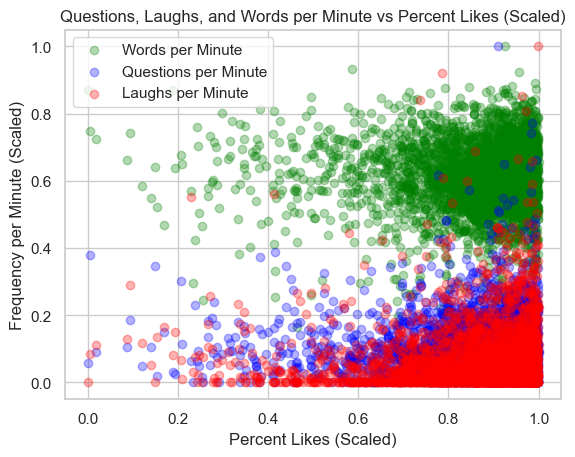

In [242]:
# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# List of columns to scale
columns_to_scale = ['questions_per_minute', 'laughs_per_minute', 'words_per_minute', 'percent_likes']

# Scale the selected columns and replace in the dataframe
merged_cleaved_df[columns_to_scale] = scaler.fit_transform(merged_cleaved_df[columns_to_scale])

# Set the style of seaborn for better visualization
sns.set(style="whitegrid")

# Create scatter plots for the scaled variables
plt.scatter(merged_cleaved_df['percent_likes'], merged_cleaved_df['words_per_minute'], color='green', alpha=0.3, label='Words per Minute')
plt.scatter(merged_cleaved_df['percent_likes'], merged_cleaved_df['questions_per_minute'], color='blue', alpha=0.3, label='Questions per Minute')
plt.scatter(merged_cleaved_df['percent_likes'], merged_cleaved_df['laughs_per_minute'], color='red', alpha=0.3, label='Laughs per Minute')


# Adding title and labels
plt.title('Questions, Laughs, and Words per Minute vs Percent Likes (Scaled)')
plt.xlabel('Percent Likes (Scaled)')
plt.ylabel('Frequency per Minute (Scaled)')

# Adding legend to distinguish the groups
plt.legend()

# Show the plot
plt.show()

### Percent_Likes Correlation: Correlating with Topics

In [243]:
# Adding 'percent_likes' to the topics DataFrame for correlation analysis
topics_with_likes = pd.concat([topics_df, merged_cleaved_df['percent_likes'].reset_index(drop=True)], axis=1)

# Calculating the correlation
correlation = topics_with_likes.corr()['percent_likes']

# Dropping 'percent_likes' correlation with itself
correlation = correlation.drop(labels=['percent_likes'])

# Sorting the correlations to find the top 100 topics
top_20_topics = correlation.sort_values(ascending=False).head(20)
bottom_20_topics = correlation.sort_values(ascending=True).head(20)

# Displaying the top 100 topics
print(top_20_topics)
print(bottom_20_topics)

society            0.095715
personal growth    0.092782
leadership         0.089114
work               0.083466
psychology         0.071385
social change      0.070393
humanity           0.070143
motivation         0.069315
education          0.063420
goal-setting       0.061190
inequality         0.059395
success            0.058662
brain              0.058603
mind               0.058307
relationships      0.057749
communication      0.056575
United States      0.055029
teaching           0.052658
personality        0.052355
decision-making    0.051460
Name: percent_likes, dtype: float64
design             -0.103559
global issues      -0.100257
technology         -0.069804
disaster relief    -0.066298
india              -0.066089
live music         -0.063045
oceans             -0.060115
mission blue       -0.059867
music              -0.054261
natural disaster   -0.053209
marine biology     -0.052692
typography         -0.049929
war                -0.049516
Best of the Web    -0.04899

### Percent_Likes Correlation: Correlating with Occupations

In [244]:
# Adding 'percent_likes' to the occupations DataFrame for correlation analysis
occupations_with_likes = pd.concat([occupations_df, merged_cleaved_df['percent_likes'].reset_index(drop=True)], axis=1)

# Calculating the correlation
correlation = occupations_with_likes.corr()['percent_likes']

# Dropping 'percent_likes' correlation with itself
correlation = correlation.drop(labels=['percent_likes'])

# Sorting the correlations to find the top 100 topics
top_10_topics = correlation.sort_values(ascending=False).head(10)
bottom_10_topics = correlation.sort_values(ascending=True).head(10)

# Displaying the top 100 topics
print(top_10_topics)
print(bottom_10_topics)

author                                  0.056589
writer                                  0.055082
psychologist                            0.046831
philosopher                             0.039801
global_health_expert;_data_visionary    0.039358
educator                                0.036402
cognitive_scientist                     0.036014
leadership_expert                       0.033527
actor                                   0.033391
computer_scientist                      0.033040
Name: percent_likes, dtype: float64
translator                -0.104796
plain_language_activist   -0.104796
kiva_systems              -0.103071
tech_investor             -0.094761
psychoanalyst             -0.088077
blogger_and_activist      -0.079842
building_activist         -0.074285
malariologist             -0.072636
experimental_physicist    -0.071618
ceo                       -0.069430
Name: percent_likes, dtype: float64


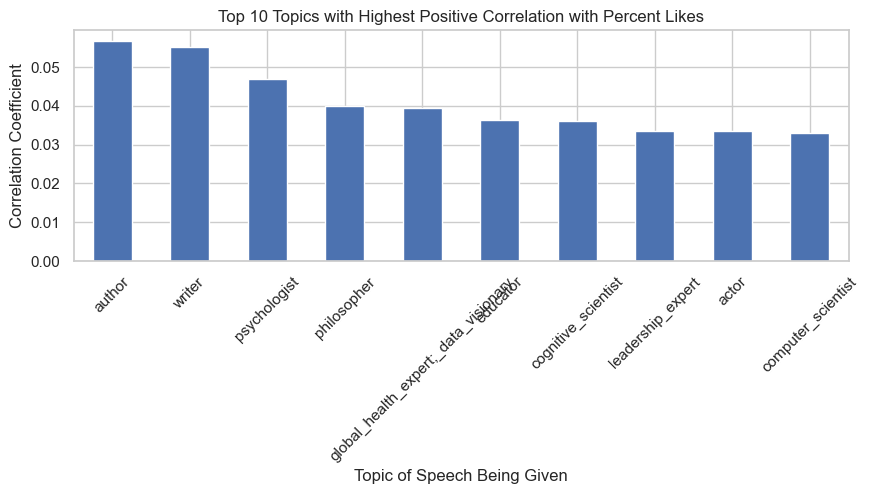

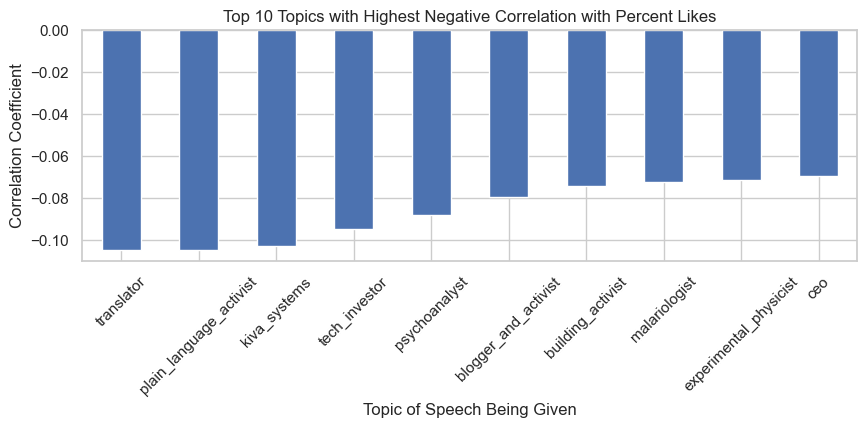

In [245]:
# Top 10 topics with highest positive correlation
top_10_positive_topics = top_10_topics.head(10)

# Top 10 topics with highest negative correlation
# Remember, in bottom_100_topics, the most negative correlations are at the end, so we use tail()
top_10_negative_topics = bottom_10_topics.tail(10)

# Plotting the top 10 topics with highest positive correlation
plt.figure(figsize=(10, 3))
top_10_positive_topics.plot(kind='bar')
plt.title('Top 10 Topics with Highest Positive Correlation with Percent Likes')
plt.xlabel('Topic of Speech Being Given')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()

# Plotting the top 10 topics with highest negative correlation
plt.figure(figsize=(10, 3))
top_10_negative_topics.plot(kind='bar')
plt.title('Top 10 Topics with Highest Negative Correlation with Percent Likes')
plt.xlabel('Topic of Speech Being Given')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()


### Percent_Likes Correlation: Correlating with Various Features

In [246]:
correlation = for_later_use[['questions_per_minute', 'laughs_per_minute', 'words_per_minute', 'percent_likes', 'ted_mainstage', 'published_year', 'published_month', 'recorded_year', 'recorded_month']].corr()
print(correlation['percent_likes'])

questions_per_minute    0.047255
laughs_per_minute       0.081024
words_per_minute       -0.018540
percent_likes           1.000000
ted_mainstage           0.041689
published_year          0.165646
published_month        -0.011491
recorded_year           0.182121
recorded_month         -0.010027
Name: percent_likes, dtype: float64


### Barplot of Linear Regression Coefficients 

In [247]:
for_later_use.drop(["talk_id"], axis=1, inplace=True) # Dropping the talk_id column

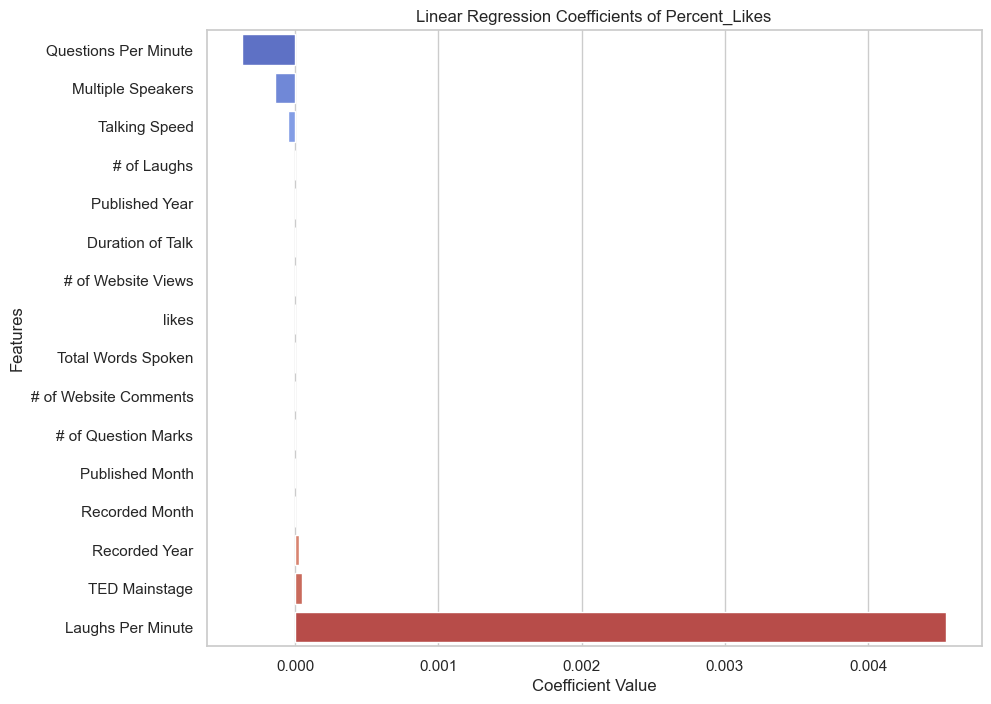

In [248]:
# Define the name mapping
name_mapping = {
    'laughs_per_minute': 'Laughs Per Minute',
    'ted_mainstage': 'TED Mainstage',
    'num_question_marks': '# of Question Marks',
    'comments': '# of Website Comments',
    'word_count': 'Total Words Spoken',
    'duration': 'Duration of Talk',
    'num_laughs': '# of Laughs',
    'words_per_minute': 'Talking Speed',
    'multiple_speakers': 'Multiple Speakers',
    'recorded_year': 'Recorded Year',
    'published_year': 'Published Year',
    'published_month': 'Published Month',
    'recorded_month': 'Recorded Month',
    'view': '# of Website Views',
    'questions_per_minute': 'Questions Per Minute'
}

# Prepare your data
X = for_later_use.select_dtypes(include=[np.number]).drop(columns=['percent_likes'])
y = for_later_use['percent_likes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Extract the coefficients and map the feature names
coefficients = model.coef_
# Map the original feature names to the new names
coef_df = pd.DataFrame(coefficients, X.columns, columns=['Coefficient']).rename(index=name_mapping)

# Sorting the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficient', ascending=True)

# Resetting the index of coef_df to use in seaborn barplot
coef_df_reset = coef_df.reset_index().rename(columns={'index': 'Feature'})

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df_reset, palette='coolwarm')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Linear Regression Coefficients of Percent_Likes')
plt.show()


### Word Cloud

I will create a WordCloud from the transcript text and their coefficients.



In [ ]:
# Transcript Only Dataframe

{
    'mind': 0.090314,
    'students': 0.081181,
    'thinking': 0.081134,
    'exactly': 0.078422,
    'doesnt': 0.077536,
    'instead': 0.070875,
    'hand': 0.067619,
    'happen': 0.067269,
    'computer': 0.066404,
    'number': 0.064237,
    'left': -0.057576,
    'simple': -0.058305,
    'book': -0.059713,
    'working': -0.061128,
    'months': -0.061594,
    'took': -0.063037,
    'bring': -0.071974,
    'decided': -0.072279,
    'build': -0.080311,
    'im going': -0.08575,
    '30 years': -0.088847,
    'tell stories': -0.089245,
    '20 years': -0.091348,
    'going make': -0.09356,
    'weve got': -0.093574,
    'thats going': -0.094823,
    '90 percent': -0.115024,
    'ladies gentlemen': -0.145435,
    'just want': -0.169773,
    'people living': -0.18253,
    'want know': 0.199189,
    'answer question': 0.14301,
    'feels like': 0.140254,
    'people say': 0.138928,
    '30 percent': 0.130456,
    'know people': 0.118156,
    'years later': 0.117891,
    'people think': 0.115096,
    'ill just': 0.112731,
    '20 percent': 0.106108
}


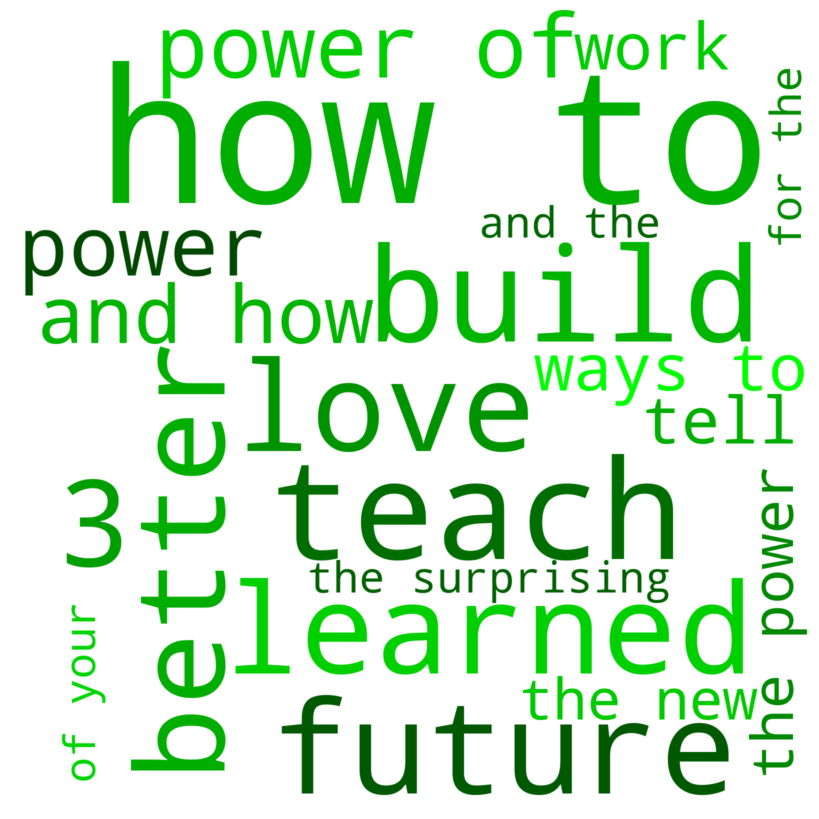

In [11]:
# Your updated dictionary from the previous step
words_coefficients = {
    'how to': 0.123902,
    'power of': 0.045472,
    'and how': 0.039796,
    'ways to': 0.03975,
    'the power': 0.030631,
    'the new': 0.02973,
    'the surprising': 0.028364,
    'and the': 0.028197,
    'of your': 0.028047,
    'for the': 0.027551,
    'new way': -0.025742,
    'new way to': -0.025742,
    'do about': -0.026441,
    'on the': -0.026735,
    'the web': -0.026897,
    'way to': -0.028553,
    'life in': -0.030716,
    'how the': -0.032714,
    'and what': -0.042337,
    'of the': -0.072924,
    'teach': 0.059401,
    'build': 0.053227,
    'future': 0.051909,
    'learned': 0.049527,
    'love': 0.048637,
    'better': 0.047232,
    '3': 0.045885,
    'power': 0.040386,
    'work': 0.03914,
    'tell': 0.038766,
    'making': -0.035987,
    'lives': -0.036566,
    'women': -0.037411,
    'ocean': -0.03851,
    'science': -0.039195,
    'new': -0.041241,
    'cancer': -0.042177,
    'music': -0.050583,
    'art': -0.061308,
    'global': -0.065322
}

class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns different colors based on word coefficients."""

    def __init__(self, color_to_words, default_color):
        self.color_to_words = color_to_words
        self.default_color = default_color

    def get_color_func(self, word):
        """Returns a single color func associated with the word."""
        for color, words in self.color_to_words.items():
            if word in words:
                return get_single_color_func(color)
        return get_single_color_func(self.default_color)

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

# Separate words by coefficient sign
positive_words = {word for word, coeff in words_coefficients.items() if coeff > 0}
negative_words = {word for word, coeff in words_coefficients.items() if coeff < 0}

# Map of color to words
color_to_words = {
    'green': positive_words,
    'red': negative_words
}

# Default color for words not in the above mapping
default_color = 'grey'

# Creating the word cloud with specified colors
wordcloud = WordCloud(width=800, height=800, max_words=150,
                      background_color='white', scale=2,
                      min_font_size=10).generate_from_frequencies(words_coefficients)

# Apply our color function
grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)
wordcloud.recolor(color_func=grouped_color_func)

# Displaying the generated WordCloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


# 8. Conclusion

## A. General Comment on Modelling and Their Train/Test Scores

I ran logistic regression and random forest decision tree models on many different mixes of features.

I used a variety of CountVectorizers (BagOfWords, with various n_grams and max_features; TFIDF; BERT).  I included various mixes of engineered features (words_spoken_per_minute, laughs_per_minute, questions_per_minute, and others) and dummied features (topic, occupation [of speaker], month_published, year_recorded, and others).  

None of these combinations of features that I tested were able to achieve a train/test score of above roughly 64%/61%.  While this IS predictive, it is not largely so.

The majority of the insights gained in this project stem from looking into the features that had the highest coefficients - especially the CountVectorization bigrams and trigrams, and the numerical engineered features.
  

## B. Topic

The topic of speech research yielded some interesting coefficients.  Topics like Society, Personal Growth, and Work had higher positive coefficients, while topics like Global Issues, Design, and Science had negative coefficients.  (See the tables below).  

While these figures do contribute to a speech receiving more ‘likes’ on the TED website, it should be noted that their coefficients are not especially strong, so this statistic should be taken with a grain of salt.  

For a sense of scale, it should be noted that the topic “society”, and whether or not a speech was given on the “ted_mainstage”, accounted for roughly the same degree of influence, with each having a coefficient of 0.036.  

Logistic Regression (Top 10 Coefficients)
| Feature          | Coefficient |
|------------------|-------------|
| society          | 0.036170    |
| personal growth  | 0.024280    |
| work             | 0.021501    |
| social change    | 0.021344    |
| business         | 0.018442    |
| leadership       | 0.017648    |
| psychology       | 0.017092    |
| humanity         | 0.016840    |
| education        | 0.015957    |
| communication    | 0.015277    |

Logistic Regression (Bottom 10 Coefficients)
| Feature       | Coefficient |
|---------------|-------------|
| Africa        | -0.011622   |
| india         | -0.011786   |
| live music    | -0.012104   |
| war           | -0.014104   |
| technology    | -0.015705   |
| TEDx          | -0.017136   |
| art           | -0.018498   |
| science       | -0.019425   |
| design        | -0.027372   |
| global issues | -0.045442   |




## C. Language Used

The below tables of bigrams are a fair representation of the words that were repeatedly shown to have a positive coefficient and negative coefficient.

At 0.09 to 0.06, the unigrams like “mind”, “students”, “thinking”, and “exactly” have a very high coefficients, relative to the larger n_grams seen in the study, which tended to fall below 0.03.

And while bigrams did have significantly weaker coefficients, we can still learn from their diminished contribution.  General words that hint at a crowd’s or an individual’s **thinking** or **feeling** appeared to positively influence the speech’s rating, while exact words like “90 percent” or “30 years” appeared to negatively influence how that speech was rated.  

If you yourself were looking to have your own speech be more well received, I would encourage you to include the words or phrases that have positive coefficients, and avoid the words or phrases that have negative coefficients. 

Logistic Regression (top 10 positive coefficients - unigrams):
| Feature  | Coefficient |
|----------|-------------|
| mind     | 0.090314    |
| students | 0.081181    |
| thinking | 0.081134    |
| exactly  | 0.078422    |
| doesnt   | 0.077536    |
| instead  | 0.070875    |
| hand     | 0.067619    |
| happen   | 0.067269    |
| computer | 0.066404    |
| number   | 0.064237    |

Logistic Regression (bottom 10 positive coefficients - unigrams):
| Feature  | Coefficient |
|----------|-------------|
| left     | -0.057576   |
| simple   | -0.058305   |
| book     | -0.059713   |
| working  | -0.061128   |
| months   | -0.061594   |
| took     | -0.063037   |
| bring    | -0.071974   |
| decided  | -0.072279   |
| build    | -0.080311   |
| im going | -0.085750   |


Logistic Regression (top 10 positive coefficients - bigrams):
| Feature       | Coefficient |
|---------------|-------------|
| want know     | 0.039126    |
| people say    | 0.029091    |
| people think  | 0.026444    |
| feels like    | 0.026033    |
| dont think    | 0.025069    |
| black hole    | 0.024175    |
| know people   | 0.022336    |
| years later   | 0.020470    |
| high school   | 0.020177    |
| answer question| 0.020100    |

Logistic Regression (top 10 negative coefficients - bigrams):
| Feature          | Coefficient |
|------------------|-------------|
| 90 percent       | -0.017563   |
| 30 years         | -0.018234   |
| middle east      | -0.018441   |
| ♫ ♫              | -0.019905   |
| im going         | -0.023090   |
| just want        | -0.023170   |
| ladies gentlemen | -0.025534   |
| looks like       | -0.025968   |
| people living    | -0.029898   |
| weve got         | -0.031898   |

Random Forest Feature Importances - quadgrams:
| Feature                    | Importance |
|----------------------------|------------|
| weve come long way         | 0.108924   |
| thank thank thank thank    | 0.105864   |
| small thing big idea       | 0.092390   |
| thank chris anderson thank | 0.084021   |
| im going talk today        | 0.076134   |
| id like talk today         | 0.063073   |
| let tell little bit        | 0.056309   |
| make world better place    | 0.049534   |
| dont know dont know        | 0.047605   |
| today im going talk        | 0.046653   |



## D. Numerical Engineered Features

The highest degree of influence on whether a speech was rated above the mean or not was whether it was given on the “ted_mainstage”.  

The “laughs_per_minute” and the number of website “comments” seemed to have a similar degree of effect on a speeches rating.  

Interestingly, the rate of speech (the “words_per_minute”) was the weakest coefficient of these variables.  It seems that the audience does rate a speech much more favourably if the speaker talks quickly or slowly.  

I encourage you to look at the tables below and see for yourself what you find interesting about these findings!

Logistic Regression:
| Feature               | Coefficient |
|---------------------|------------|
| ted_mainstage       | 0.169018   |
| num_question_marks  | 0.088434   |
| comments            | 0.074825   |
| laughs_per_minute   | 0.074142   |
| questions_per_minute| 0.070605   |
| num_laughs          | 0.061112   |
| word_count          | 0.036111   |
| duration            | 0.032129   |
| words_per_minute    | 0.028710   |
| multiple_speakers   | -0.049351  |


Random Forest:
| Feature             | Importance |
|---------------------|------------|
| comments            | 0.28       |
| laughs_per_minute   | 0.16       |
| questions_per_minute| 0.12       |
| num_laughs          | 0.10       |
| words_per_minute    | 0.08       |
| num_question_marks  | 0.08       |
| duration            | 0.06       |
| ted_mainstage       | 0.06       |
| word_count          | 0.06       |
| multiple_speakers   | 0.00       |


## E. Title

While the length of a speech’s title didn’t appear to correlate much with the percent_likes it received (R^2 value of 0.016, and a Coefficient of 0.0877), some interesting coefficients were found in the words that a title contains.  Words like “Teach”, “Build”, and “Future” had a positive impact on the speeches likes, while words like “making”, “lives”, and “women” had a negative impact.  

Logistic regression (top 10 positive coefficients):
| Feature | Coefficient |
|---------|-------------|
| teach   | 0.059401    |
| build   | 0.053227    |
| future  | 0.051909    |
| learned | 0.049527    |
| love    | 0.048637    |
| better  | 0.047232    |
| 3       | 0.045885    |
| power   | 0.040386    |
| work    | 0.039140    |
| tell    | 0.038766    |


Logistic regression (top 10 negative coefficients):
| Feature | Coefficient |
|---------|-------------|
| making  | -0.035987   |
| lives   | -0.036566   |
| women   | -0.037411   |
| ocean   | -0.038510   |
| science | -0.039195   |
| new     | -0.041241   |
| cancer  | -0.042177   |
| music   | -0.050583   |
| art     | -0.061308   |
| global  | -0.065322   |



## F. Ted MainStage Impact

Speeches given at MainStage TED events (and not TEDx, or other offshoot events) did receive a higher rating, but not by much.  When normalized, the mean difference in percent_likes was 0.012% higher for mainstage speeches than it was for non-mainstage ones.  Statistically significant, but not major.   




## In Summary

In summary, I have learned that there appear to be features of a speech that do empirically positively impact how well that speech is received.  The “laughs_per_minute” is 2.5x more influential than how fast the presenter speaks (“words_per_minute”).  

Words like “mind”, “students”, “thinking”, and “exactly” had very strong influences relative to other words and/or features.  

General words like “want know”, “people say”, “people think”, and “feels like” had a less strong (compared to the above single-word features) but still positive influence throughout this research.  And words that were more precise, such as “90 percent” or “30 years” had a negative influence.  

And whether or not a talk was given on the “ted_mainstage” had the most influence out of all the features, but while this influence was most significant, this ‘most significant’ feature still only led to a relative 0.012% degree of influence on how many ‘likes’ a talk received on the TED website.  

It has been a pleasure researching this topic, and I look forward to doing more research into what else can influence the impact that a speech can have on its audience.  
